#  DataBase contruction

In [ ]:
import pandas as pd
import itertools
from itertools import combinations

from pandas.core.nanops import nanall
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
from XGBoost_Model import *
import sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

In [ ]:
# reading all the data files
data_clinical_patient = pd.read_csv('pan_origimed_2020/data_clinical_patient.txt', sep="\t")
data_clinical_sample = pd.read_csv('pan_origimed_2020/data_clinical_sample.txt', sep="\t")
data_cna_log2 = pd.read_csv('pan_origimed_2020/data_cna_log2.txt', sep="\t")
data_cna = pd.read_csv('pan_origimed_2020/data_cna.txt', sep="\t")
data_mutations = pd.read_csv('pan_origimed_2020/data_mutations.txt', sep="\t", header=2, dtype={"Exon_Number": "string"})
data_sv = pd.read_csv('pan_origimed_2020/data_sv.txt', sep="\t")

In [ ]:
# removing bad rows
data_clinical_sample = data_clinical_sample[4:]
data_clinical_patient = data_clinical_patient[4:]

In [ ]:
data_clinical_patient = data_clinical_patient.rename(columns={'#Patient Identifier': 'PATIENT_ID'})

In [ ]:
data_clinical_patient.head()

In [ ]:
# matching the sample id to match other tables
data_clinical_patient["SAMPLE_ID"] = data_clinical_patient["PATIENT_ID"].apply(lambda x: "P-" + x[7:])

In [ ]:
# make all sample id header name the same - "SAMPLE_ID"
data_clinical_sample.rename(columns={"Sample Identifier": 'SAMPLE_ID'}, inplace=True)
data_mutations.rename(columns={"Tumor_Sample_Barcode": 'SAMPLE_ID'}, inplace=True)
data_sv.rename(columns={"Sample_Id": 'SAMPLE_ID'}, inplace=True)

In [ ]:
# merge everything
merged_clinical_data = data_clinical_patient.merge(data_clinical_sample, on="SAMPLE_ID", how='outer')
merged_mutations_data = merged_clinical_data.merge(data_mutations, on="SAMPLE_ID", how='outer')
merged_all_data = merged_mutations_data.merge(data_sv, on="SAMPLE_ID", how='outer')

In [ ]:
merged_all_data["SNP_event"] = merged_all_data["Reference_Allele"].fillna("").astype(str) + ">" + merged_all_data["Tumor_Seq_Allele2"].fillna("").astype(str)


In [ ]:
data_for_model = merged_all_data[["PATIENT_ID", "Cancer Type", 'Cancer Type Detailed', 'Tumor Stage',
                                'Sample Type', "Sex", "Diagnosis Age", "Smoke Status", "TMB (nonsynonymous)",
                                "Hugo_Symbol", "Chromosome", "Start_Position", "End_Position",
                                "Consequence", "Variant_Type", "SNP_event", "Protein_position", "Codons",
                                "Exon_Number","VAR_TYPE_SX", "Site1_Hugo_Symbol", "Site2_Hugo_Symbol","Event_Info"]]

In [ ]:
data_for_model["Exon_Number"].isnull().sum()

In [ ]:
data_for_model.head(20)

In [ ]:
# Function to handle the conversion
def convert_exon_number(val):
    try:
        # First, try to convert to 'Month-Year' format (e.g., 'Sep-89' -> '09/89')
        return pd.to_datetime(val, format='%b-%y').strftime('%m/%y')
    except ValueError:
        pass

    try:
        # Then, try to convert to 'DD-Mon' format (e.g., '14-Sep' -> '09/14')
        date_obj = pd.to_datetime(val, format='%d-%b', errors='raise')
        return date_obj.strftime('%m/%d')
    except ValueError:
        # If neither format matches, return the value as is (non-date-like string)
        return val

In [ ]:
# Apply the function to the column
data_for_model.loc[:, 'Exon_Number'] = data_for_model['Exon_Number'].apply(convert_exon_number)

In [ ]:
data_for_model["Exon_Number"].isnull().sum()

In [ ]:
data_for_model["Cancer Type"].value_counts()

In [ ]:
def create_age_range(x):
    if x <= 10:
        return "0-10"
    elif x <= 20:
        return "11-20"
    elif x <= 30:
        return "21-30"
    elif x <= 40:
        return "31-40"
    elif x <= 50:
        return "41-50"
    elif x <= 60:
        return "51-60"
    elif x <= 70:
        return "61-70"
    elif x <= 80:
        return "71-80"
    else:
        return "80+"

In [ ]:
data_for_model.loc[:, 'Diagnosis Age'] = data_for_model['Diagnosis Age'].astype(int).apply(create_age_range).astype("category")

In [ ]:
data_for_model

In [ ]:
tt = dict(enumerate(data_for_model["Exon_Number"].astype('category').cat.categories))
tt.values()
# data[object_columns] = data[object_columns].astype('category')

In [ ]:
# Filter cancer types with at least 2000 samples
cancer_counts = data_for_model['Cancer Type'].value_counts()
valid_cancer_types = cancer_counts[cancer_counts >= 2000].index
data_for_model = data_for_model[data_for_model['Cancer Type'].isin(valid_cancer_types)]
data_for_model = data_for_model[data_for_model['Chromosome'].notnull()]

In [ ]:
data_for_lift = data_for_model.copy()

In [ ]:
data_for_lift["Consequence"].unique()

In [ ]:
data_for_model['Consequence'].str.split(',')
dummy_vars = data_for_model['Consequence'].str.split(',').explode().str.get_dummies().groupby(level=0).sum()
data_for_model = data_for_model.join(dummy_vars)
data_for_model.drop('Consequence', axis=1, inplace=True)

In [ ]:
data_for_model[data_for_model["PATIENT_ID"] == "Patient8178"]

In [ ]:
data_for_model.to_csv("pan_cancer_data_for_model.csv", index=False)

In [ ]:
hypo_data = pd.read_csv("hypotheses.csv")

In [ ]:
hypo_data_updates = hypo_data[hypo_data["support"] > 2].sort_values(["cancer_type", 'support'], ascending=[True, False])
hypo_data_updates.head()

In [ ]:
def cancer_type_correlations(df):
    """
    Print cancer type and non-null feature-value pairs for each row in the DataFrame.

    Parameters:
    - df: DataFrame with columns "cancer_type", feature columns, and "support".
    """
    corr_list = []
    # Iterate through each row
    for index, row in df.iterrows():
        # Extract cancer type and support
        cancer_type = row["cancer_type"]
        support = row["support"]

        # Get feature-value pairs where the feature value is not null
        features = [
            f"{feature}={row[feature]}"
            for feature in df.columns
            if feature not in {"cancer_type", "support"} and not pd.isnull(row[feature])
        ]

        # Format and print the result
        features_str = ", ".join(features)
        corr_list.append(f"{cancer_type}: {features_str}, Support: {support}")
    return corr_list


In [ ]:
corr_list = cancer_type_correlations(hypo_data_updates)

In [ ]:
corr_list

Lift Calculation

In [ ]:
cancer_type_dummy = data_for_lift['Cancer Type'].str.get_dummies().groupby(level=0).sum()
data_for_lift = data_for_lift.join(cancer_type_dummy)

In [ ]:
data_for_lift.head()

In [ ]:
# Combine columns to create specific mutation identifiers
# data_for_lift['Mutation'] = data_for_lift['Chromosome'] + "_" + data_for_lift['Start_Position'].astype(str) + "_" + data_for_lift['Variant_Type']
data_for_lift['Position'] = data_for_lift['Start_Position'].astype(str) + "-" + data_for_lift['End_Position'].astype(str)

In [ ]:
data_for_lift.to_csv("data_for_lift.csv", index=False)

In [ ]:
# Select a subset of columns to analyze (e.g., most relevant ones)
columns_to_combine = ['Sex', 'Smoke Status', 'Chromosome', 'Hugo_Symbol', 'SNP_event', "Consequence", 'Exon_Number',
                      "Diagnosis Age", "TMB (nonsynonymous)", "Position", "Protein_position", "Codons", "VAR_TYPE_SX"]

In [ ]:
cancer_probabilities = {cancer_type: data_for_lift[cancer_type].mean() for cancer_type in list(data_for_lift["Cancer Type"].unique())}

In [ ]:
cancer_probabilities

In [ ]:
    # Iterate over feature combinations
# for num_features in range(2, 6):
feature_combinations = list(combinations(columns_to_combine, 5))
feature_combinations

In [ ]:
# Precompute the mean probabilities for cancer types

lifts = []

for cancer_type, P_B in cancer_probabilities.items():
    for feature in feature_combinations:
        # Combine the selected features into a single feature
        combined_feature = data_for_lift[list(feature)].astype(str).agg('_'.join, axis=1)

        # Compute value counts for the combined feature
        combined_counts = combined_feature.value_counts()
        valid_features = combined_counts[combined_counts >= 100].index

        if valid_features.empty:
            continue  # Skip if no valid combined features

        # Filter the combined feature to include only valid entries
        filtered_data = combined_feature[combined_feature.isin(valid_features)]
        P_A = filtered_data.value_counts(normalize=True)

        # Compute joint probabilities for cancer type
        joint_prob = (
            filtered_data[data_for_lift[cancer_type] == 1]
            .value_counts(normalize=True)
            .reindex(P_A.index, fill_value=0)
        )

        # Calculate lift
        lift = (joint_prob / (P_A * P_B)).round(2)

        # Store results
        lifts.append((cancer_type, feature, lift))


In [ ]:
lifts = []
# Probability of the cancer type
for num_features in range(2, 6):
    feature_combinations = list(combinations(columns_to_combine, num_features))
    for cancer_type in cancer_type_dummy.columns:
        P_B = data_for_lift[cancer_type].mean()
        for feature in feature_combinations:
            # Create a combined feature from three columns
            combined_feature = data_for_lift[feature[0]].astype(str)

            for f in feature[1:]:
                combined_feature += "_" + data_for_lift[f].astype(str)
            # combined_feature = "_".join(data_for_lift[feature].astype(str) for feature in feature_combinations)

            min_count = 100
            P_A_counts = combined_feature.value_counts()

            # Filter combined features based on minimum count
            valid_features = P_A_counts[P_A_counts >= min_count].index
            filtered_data = combined_feature[combined_feature.isin(valid_features)]

            # Probability of the combined feature
            P_A = filtered_data.value_counts(normalize=True)

            # Joint probability of the combined feature and cancer type
            joint = (filtered_data[data_for_lift[cancer_type] == 1].value_counts(normalize=True).reindex(P_A.index, fill_value=0))

            # Calculate lift
            lift = (joint / (P_A * P_B)).round(2)  # Round lift to 2 decimal places for readability

            # Append results as a tuple of the feature triplet and their associated lift values
            lifts.append((cancer_type, feature, lift))

In [ ]:
# Flatten the results for easy visualization
lift_results = []

for cancer_type, feature_pair, lift in lifts:
    for feature_value, lift_value in lift.items():
        lift_results.append({
            'Cancer Type': cancer_type,
            'Feature Pair': feature_pair,
            'Feature Value': feature_value,
            'Lift': lift_value
        })

lift_df = pd.DataFrame(lift_results)
lift_df = lift_df.sort_values(by='Lift', ascending=False)

In [ ]:
lift_df.sort_values(by='Lift', ascending=False)

In [ ]:
filter_triple_data = data[data["Smoke Status"] == "Nonsmoker"]
filter_triple_data = filter_triple_data[filter_triple_data["Hugo_Symbol"] == "TP53"]
filter_triple_data = filter_triple_data[filter_triple_data["SNP_event"] == "G>A"]

In [ ]:
def combine_features(data, feature_combination):
    """
    Combine selected features into a single feature by joining their values.
    """
    return data[list(feature_combination)].astype(str).agg('_'.join, axis=1)

In [ ]:
def filter_and_compute_probabilities(combined_feature, data_for_lift, cancer_type, min_count):
    """
    Filter valid features, compute P(A), and joint probabilities for a cancer type.
    """
    # Step 1: Compute value counts
    combined_counts = combined_feature.value_counts()
    valid_features = combined_counts[combined_counts >= min_count].index

    # Step 2: Skip if no valid combined features
    if valid_features.empty:
        return None, None

    # Step 3: Filter the combined feature
    filtered_data = combined_feature[combined_feature.isin(valid_features)]

    # Step 4: Compute probabilities
    P_A = filtered_data.value_counts(normalize=True)
    joint_prob = (
        filtered_data[data_for_lift[cancer_type] == 1]
        .value_counts(normalize=True)
        .reindex(P_A.index, fill_value=0)
    )

    return P_A, joint_prob


In [ ]:
def calculate_lifts_for_cancer_type(data_for_lift, cancer_type, P_B, feature_combinations, min_count):
    """
    Compute lifts for a single cancer type across all feature combinations.
    """
    lifts = []

    for feature_combination in feature_combinations:
        # Step 1: Combine features
        combined_feature = combine_features(data_for_lift, feature_combination)

        # Step 2: Filter and compute probabilities
        P_A, joint_prob = filter_and_compute_probabilities(
            combined_feature, data_for_lift, cancer_type, min_count
        )

        if P_A is None or joint_prob is None:
            continue  # Skip if no valid combined features

        # Step 3: Calculate lift
        lift = (joint_prob / (P_A * P_B)).round(2)

        # Step 4: Store result
        lifts.append((cancer_type, feature_combination, lift))

    return lifts

In [ ]:
def compute_all_lifts(data_for_lift, cancer_probabilities, feature_combinations, min_count=100):
    """
    Main function to compute lifts for all cancer types.
    """
    all_lifts = []

    for cancer_type, P_B in cancer_probabilities.items():
        lifts = calculate_lifts_for_cancer_type(
            data_for_lift, cancer_type, P_B, feature_combinations, min_count
        )
        all_lifts.extend(lifts)

    return all_lifts

In [ ]:
lifts = compute_all_lifts(data_for_lift, cancer_probabilities, feature_combinations, min_count=100)

In [ ]:
data_dr = pd.read_csv('data_for_rules.csv')

In [ ]:
data_dr.columns

In [ ]:
narrowed = pd.read_csv("narrowed_cancers_data.csv")

In [ ]:
narrowed[narrowed.index == 529]

In [ ]:
from sklearn.impute import KNNImputer
narrowed[['Current_Exon', 'Total_Exons']] = narrowed['Exon_Number'].str.split('/', expand=True)
narrowed[['Current_Exon', 'Total_Exons']] = narrowed[['Current_Exon', 'Total_Exons']].astype(float)

imputer = KNNImputer(n_neighbors=5)
narrowed[["Current_Exon", "Total_Exons"]] = imputer.fit_transform(narrowed[["Current_Exon", "Total_Exons"]])
# ransform(narrowed[["Exon_Number"]])

In [ ]:
narrowed[["Exon_Number", "Current_Exon", "Total_Exons"]]

In [ ]:
df = pd.read_csv("data_for_rules.csv")

In [ ]:
df.head()

In [ ]:
df = df[df["Diagnosis Age"] < 71.5]
df = df[df["Diagnosis Age"] > 47.5]
df = df[df["TMB (nonsynonymous)"] < 0.28]
df = df[df["Sex"] == "Female"]
df

In [ ]:
df["Cancer Type"].drop_duplicates()

In [ ]:
df[["PATIENT_ID", "Cancer Type"]].drop_duplicates()["Cancer Type"].value_counts()

In [ ]:
df

In [ ]:
df_rules = pd.read_csv("data_for_rules.csv")

In [ ]:
df_rules['Exon_Number'].value_counts()

In [ ]:
# Smoke Status - Convert to dummies
dummy_smoking = df_rules['Smoke Status'].str.get_dummies().groupby(level=0).sum()

# Hugo Symbol - Convert to dummies
dummy_hugo_symbol = df_rules['Hugo_Symbol'].str.get_dummies().groupby(level=0).sum()

# Variant Type - Convert to dummies
dummy_Variant_Type = df_rules['Variant_Type'].str.get_dummies().groupby(level=0).sum()

# SNP_event - Keep only top 100 most frequent values
top_100 = df_rules['SNP_event'].value_counts().nlargest(100).index
df_rules['SNP_event'] = df_rules['SNP_event'].where(df_rules['SNP_event'].isin(top_100), other=None)
dummy_snp_event = df_rules['SNP_event'].str.get_dummies().groupby(level=0).sum()

# Combine all dummy variables
dummy_vars = pd.concat([dummy_smoking, dummy_hugo_symbol, dummy_snp_event, dummy_Variant_Type], axis=1)

# Join with original DataFrame
df_rules = df_rules.join(dummy_vars)

# Drop original categorical columns
df_rules.drop(['Smoke Status', 'SNP_event', 'Hugo_Symbol', 'Variant_Type'], axis=1, inplace=True)

In [ ]:
df_rules.head()

In [ ]:
len(list(data_for_model["Event_Info"].unique()))

In [ ]:
df_rules["Cancer Type"].unique()

In [ ]:
df_rules['Exon_Number'] = df_rules['Exon_Number'].str.split('/').str[0].astype(int)

In [ ]:
df_rules.drop('Codons', axis=1, inplace=True)

In [ ]:
df_rules.head(10)

In [ ]:
df_rules.to_csv("data_for_decision.csv", index=False)

In [ ]:
df = data_for_model.copy()
df.drop(['Site1_Hugo_Symbol', 'Site2_Hugo_Symbol', 'Event_Info'], axis=1, inplace=True)

In [ ]:
data_for_model.dropna(inplace=True)
data_for_model['Exon_Number'] = data_for_model['Exon_Number'].str.split('/').str[0].astype(int)

In [ ]:
# Step 1: Prepare your categorical features
categorical_features = ['Sex', 'VAR_TYPE_SX', 'Smoke Status', 'Hugo_Symbol', 'Variant_Type', 'SNP_event', 'Consequence', 'Chromosome']

# Step 2: Handle the special case of Codons
def prepare_data(df, columns):
    # For high-cardinality features like Codons, we can group them
    # Example: Group by first letter of codon or by some domain knowledge

    # Method 1: Keep only the most frequent codons and group others
    for column in columns:
        top_codons = df[column].value_counts().nlargest(100).index.tolist()
        df[f'{column}_grouped'] = df[column].apply(lambda x: x if x in top_codons else 'Other')

    # OR Method 2: Group by first nucleotide
    # df['Codons_grouped'] = df['Codons'].apply(lambda x: x[0] + '_codons' if isinstance(x, str) else 'Unknown')

    return df

# Step 3: Encoding categorical features
def encode_features(df, categorical_cols):
    label_encoders = {}

    # Store original values for interpretation
    feature_values = {}

    for col in categorical_cols + ['SNP_event_grouped']:
        if col in df.columns:
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col])

            # Store mapping for interpretation
            label_encoders[col] = le
            feature_values[col] = dict(zip(le.transform(le.classes_), le.classes_))

    return df, label_encoders, feature_values

def extract_rules(clf, feature_names, class_names, feature_values):
    tree_ = clf.tree_

    feature_name = [
        feature_names[i] if i != tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, path, paths):
        if tree_.feature[node] != tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Special handling for chromosome dummy variables
            if name.startswith('chr_'):
                # Extract chromosome number
                chr_num = name.split('_')[1]

                # For dummy variables, typically threshold is 0.5
                if threshold <= 0.5:
                    # chr_X ≤ 0.5 means the mutation is NOT on this chromosome
                    path.append((name, "chromosome", {"excluded": chr_num}, f"Chromosome is not {chr_num}"))
                    recurse(tree_.children_left[node], path, paths)
                    path.pop()

                    # chr_X > 0.5 means the mutation IS on this chromosome
                    path.append((name, "chromosome", {"included": chr_num}, f"Chromosome is {chr_num}"))
                    recurse(tree_.children_right[node], path, paths)
                    path.pop()
            # Handle categorical features
            elif name.endswith('_encoded'):
                original_name = name.replace('_encoded', '')

                if original_name in feature_values:
                    # Handle categorical feature
                    left_values = [feature_values[original_name][i] for i in range(len(feature_values[original_name]))
                                  if i <= threshold]
                    right_values = [feature_values[original_name][i] for i in range(len(feature_values[original_name]))
                                   if i > threshold]

                    # Store as tuples: (feature_name, "categorical", values_list, readable_condition)
                    if len(left_values) <= 3:
                        left_condition = f"{original_name} is {' or '.join(map(str, left_values))}"
                    else:
                        left_condition = f"{original_name} is in a group of {len(left_values)} values"

                   # Handle special case for Codons
                    if original_name == 'SNP_event_grouped' and 'Other' in left_values:
                        left_condition = f"SNP event is among the less common types"
                    if original_name == 'SNP_event_grouped' and 'Other' in right_values:
                        right_condition = f"SNP event is among the less common types"

                    path.append((original_name, "categorical", set(left_values), left_condition))
                    recurse(tree_.children_left[node], path, paths)
                    path.pop()

                    if len(right_values) <= 3:
                        right_condition = f"{original_name} is {' or '.join(map(str, right_values))}"
                    else:
                        right_condition = f"{original_name} is in a group of {len(right_values)} values"

                    path.append((original_name, "categorical", set(right_values), right_condition))
                    recurse(tree_.children_right[node], path, paths)
                    path.pop()
                else:
                    # Standard case for encoded features without mapping
                    path.append((original_name, "categorical", {f"≤ category {threshold:.0f}"},
                                f"{original_name} ≤ category {threshold:.0f}"))
                    recurse(tree_.children_left[node], path, paths)
                    path.pop()

                    path.append((original_name, "categorical", {f"> category {threshold:.0f}"},
                                f"{original_name} > category {threshold:.0f}"))
                    recurse(tree_.children_right[node], path, paths)
                    path.pop()
            else:
                # Numerical features - ensure we use consistent 4-tuple format
                left_condition = f"{name} ≤ {threshold:.2f}"
                path.append((name, "numerical", {"min": float("-inf"), "max": threshold}, left_condition))
                recurse(tree_.children_left[node], path, paths)
                path.pop()

                right_condition = f"{name} > {threshold:.2f}"
                path.append((name, "numerical", {"min": threshold, "max": float("inf")}, right_condition))
                recurse(tree_.children_right[node], path, paths)
                path.pop()
        else:
            class_idx = np.argmax(tree_.value[node][0])
            paths.append((path.copy(), class_names[class_idx]))

    recurse(0, [], paths)

    # Generate human-readable sentences with consolidated features
    rules = []
    for path, outcome in paths:
        if path:
            # Group by feature name
            feature_groups = {}
            for condition in path:
                feature, cond_type, value_info, readable = condition  # Now this should always work
                if feature not in feature_groups:
                    feature_groups[feature] = []
                feature_groups[feature].append((cond_type, value_info, readable))

            # Process chromosome features
            chromosomes_included = []
            chromosomes_excluded = []
            other_feature_groups = {}

            for feature, conditions in feature_groups.items():
                if any(c[0] == "chromosome" for c in conditions):
                    for cond_type, value_info, _ in conditions:
                        if "included" in value_info:
                            chromosomes_included.append(value_info["included"])
                        if "excluded" in value_info:
                            chromosomes_excluded.append(value_info["excluded"])
                else:
                    other_feature_groups[feature] = conditions

            # Create consolidated conditions
            consolidated_conditions = []

            # Add chromosome conditions
            if chromosomes_included:
                if len(chromosomes_included) == 1:
                    consolidated_conditions.append(f"Chromosome is {chromosomes_included[0]}")
                else:
                    consolidated_conditions.append(f"Chromosome is one of {', '.join(chromosomes_included)}")

            if chromosomes_excluded:
                if len(chromosomes_excluded) <= 3:
                    consolidated_conditions.append(f"Chromosome is not {', '.join(chromosomes_excluded)}")

            # Process other features
            for feature, conditions in other_feature_groups.items():
                if all(c[0] == "numerical" for c in conditions):
                    # For numerical features
                    min_val = float("-inf")
                    max_val = float("inf")

                    for _, value_info, _ in conditions:
                        min_val = max(min_val, value_info.get("min", float("-inf")))
                        max_val = min(max_val, value_info.get("max", float("inf")))

                    if min_val > float("-inf") and max_val < float("inf"):
                        consolidated_conditions.append(f"{feature} is between {min_val:.2f} and {max_val:.2f}")
                    elif min_val > float("-inf"):
                        consolidated_conditions.append(f"{feature} > {min_val:.2f}")
                    elif max_val < float("inf"):
                        consolidated_conditions.append(f"{feature} ≤ {max_val:.2f}")

                elif all(c[0] == "categorical" for c in conditions):
                    # For categorical features - find intersection of values
                    value_sets = [c[1] for c in conditions]

                    # Find intersection of all sets
                    common_values = set.intersection(*value_sets) if value_sets else set()

                    # If intersection is non-empty, it's the stricter condition
                    if common_values:
                        if len(common_values) <= 3:
                            consolidated_conditions.append(f"{feature} is {' or '.join(map(str, common_values))}")
                        else:
                            consolidated_conditions.append(f"{feature} is in a group of {len(common_values)} values")
                    else:
                        # If no intersection (shouldn't happen in a valid tree), use original conditions
                        for _, _, readable in conditions:
                            consolidated_conditions.append(readable)

            # Create the final rule
            rule = "If " + " AND ".join(consolidated_conditions) + f", THEN cancer type is {outcome}"
            rules.append(rule)

    return rules

In [ ]:
df = df_rules.copy()
df.head()

In [ ]:
# d = prepare_data(df)
df, label_encoders, feature_values = encode_features(df, ['Sex', 'VAR_TYPE_SX'])
df.head()

In [ ]:
features_to_drop = ['Cancer Type', 'Cancer Type Detailed', 'Tumor Stage', 'Sample Type', 'Sex', 'VAR_TYPE_SX']
                    # 'Smoke Status', 'Hugo_Symbol', 'Variant_Type', 'SNP_event', 'SNP_event_grouped', 'Codons', 'Consequence', 'Chromosome']
y = df['Cancer Type']
X = df.drop(features_to_drop, axis=1)
X_train, X_test, y_train, y_test, X_test_with_id = stratified_split_by_patient(X, y)
feature_names = list(X_train.columns)
class_names = list(df['Cancer Type'].unique())
clf = tree.DecisionTreeClassifier(random_state=39)#, min_samples_leaf=10)#, max_depth=1000)
clf.fit(X_train, y_train)
sentences = extract_rules(clf, feature_names, class_names, feature_values)

# for sentence in sentences:
#     print(sentence)
sentences

In [ ]:
feature_names

In [ ]:
data_for_model.head()

In [ ]:
df = prepare_data(data_for_model, ['SNP_event', 'Codons',])

In [ ]:
df = pd.read_csv('models_hypotheses/combined_hypotheses.csv')
df['plausibility'] = None
df['novelty'] = None
df['comments'] = None

In [ ]:
df[df['rank'] <= 10].to_excel('models_hypotheses/hypotheses_for_professional_evaluation.xlsx', index=False)

In [ ]:
df['Tumor Stage'].value_counts()

In [ ]:
data = df[df['Tumor Stage'] in ['III', 'IV', 'II', 'I']]

In [ ]:
df = pd.read_csv('llm_results/evaluations_20250409_151350.csv')

In [ ]:
combine_hyp = pd.read_csv('models_hypotheses/combined_hypotheses.csv')
combine_hyp.rename(columns={'hypo_id': 'hypothesis_id'}, inplace=True)
combine_hyp.head()

In [ ]:
# Make sure both columns are the same type (e.g., convert both to string or both to int)
df['hypothesis_id'] = df['hypothesis_id'].astype(str)
combine_hyp['hypothesis_id'] = combine_hyp['hypothesis_id'].astype(str)

# Now you can safely join
merged_df = df.join(combine_hyp.set_index('hypothesis_id'), on='hypothesis_id')

In [ ]:
merged_df.sort_values(by=['novelty', 'plausibility'], ascending=[False, False])

In [ ]:
data = merged_df[merged_df['novelty'] > 6]
data = data[data['plausibility'] > 6]
data['novelty'] = None
data['plausibility'] = None
data.drop(columns=['timestamp', 'model'], inplace=True)

In [ ]:
data.to_excel('models_hypotheses/hypotheses_for_professional2.xlsx', index=False)

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data(filepath):
    features_to_drop = ['Cancer Type Detailed', 'Tumor Stage', 'Sample Type', "Site2_Hugo_Symbol", "Site1_Hugo_Symbol", "Event_Info"]
    label = 'Cancer Type'
    data = pd.read_csv(filepath)
    cancer_types = data["Cancer Type"].unique()
    # mapping = {}
    # # Convert object columns to categorical
    # object_columns = data.select_dtypes(include=['object', 'bool']).columns
    # for col in object_columns:
    #     mapping[col] = dict(enumerate(data[col].astype('category').cat.categories))
    # data[object_columns] = data[object_columns].astype('category')
    #
    # # Encode categorical columns using cat.codes
    # for col in data.select_dtypes(include='category').columns:
    #     data[col] = data[col].cat.codes

    # Separate features and labels
    data.drop(features_to_drop, axis=1, inplace=True)
    data.dropna(inplace=True)
    X = data.drop(label, axis=1)
    y, uniques = pd.factorize(data['Cancer Type'])
    # label_dict = {cancer: idx for idx, cancer in enumerate(cancer_types)}
    # X.replace(-1, np.nan, inplace=True)
    return X, y#, label_dict, mapping


In [3]:
def stratified_split_by_patient(X, y, train_ratio=0.7, test_ratio=0.3):
    """
    Split data into training and testing sets with stratification by PATIENT_ID.
    """
    # Ensure the ratios sum to 1
    assert train_ratio + test_ratio == 1, "Ratios must sum to 1."

    # Get unique patient IDs
    unique_ids = X['PATIENT_ID'].unique()

    # Map PATIENT_ID to a corresponding target value (first occurrence)
    patient_labels = dict(zip(X['PATIENT_ID'], y))
    unique_patient_labels = [patient_labels[pid] for pid in unique_ids]

    # Initial split: train+val and test
    train_ids, test_ids = train_test_split(
        unique_ids,
        test_size=test_ratio,
        stratify=unique_patient_labels,
        random_state=42
    )

    # Split data into subsets
    X_train = X[X['PATIENT_ID'].isin(train_ids)].drop(columns=['PATIENT_ID'])
    X_test = X[X['PATIENT_ID'].isin(test_ids)].drop(columns=['PATIENT_ID'])
    X_test_with_id = X[X['PATIENT_ID'].isin(test_ids)]  # Keep validation set with PATIENT_ID for patient-level analysis

    y_train = y[X['PATIENT_ID'].isin(train_ids)]
    # y_val = y[X['PATIENT_ID'].isin(val_ids)]
    y_test = y[X['PATIENT_ID'].isin(test_ids)]

    return X_train, X_test, y_train, y_test, X_test_with_id

In [4]:
def analyze_feature_combinations_for_cancer(model, X, y, cancer_type, cancer_names,
                                           top_n=5, cat_features=None,
                                           interaction_depth=2):
    """
    Analyze feature combinations specific to a cancer type

    Parameters:
    -----------
    model : CatBoostClassifier
        Trained model
    X : DataFrame
        Feature data
    y : Series
        Target labels
    cancer_type : int
        The specific cancer type to analyze
    cancer_names : list
        List of cancer type names corresponding to encoded values
    top_n : int
        Number of top combinations to return
    cat_features : list
        List of categorical feature names
    interaction_depth : int
        Max number of features to consider in combinations
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import shap

    # Get actual cancer name
    cancer_name = cancer_names[cancer_type]

    # Get samples for this cancer type
    cancer_indices = np.where(y == cancer_type)[0]
    X_cancer = X.iloc[cancer_indices]

    # Get samples for other cancer types
    other_indices = np.where(y != cancer_type)[0]
    X_other = X.iloc[other_indices]

    print(f"\n===== ANALYZING CANCER TYPE: {cancer_name} =====")
    print(f"Number of samples: {len(X_cancer)}")

    # Get feature importance for this specific cancer type
    # Use SHAP values for better feature importance
    try:
        print("\nCalculating SHAP values for feature importance...")
        explainer = shap.TreeExplainer(model)

        # Get class-specific SHAP values
        # Sample for efficiency if dataset is large
        sample_size = min(len(X), 1000)
        X_sample = X.sample(sample_size, random_state=42)
        shap_values = explainer.shap_values(X_sample)

        # Get SHAP values for this cancer type
        cancer_shap = shap_values[cancer_type]

        # Calculate mean absolute SHAP value for each feature
        feature_importance = np.abs(cancer_shap).mean(0)
        feature_names = X.columns

        # Sort features by importance
        sorted_idx = np.argsort(-feature_importance)

        # Plot SHAP values
        plt.figure(figsize=(12, 10))
        shap.summary_plot(cancer_shap, X_sample, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance for {cancer_name}')
        plt.tight_layout()
        plt.show()

        # List top important features
        print(f"\nTop features for {cancer_name}:")
        for i in range(min(10, len(sorted_idx))):
            idx = sorted_idx[i]
            print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

        # Get top features for interaction analysis
        top_features = [feature_names[i] for i in sorted_idx[:15]]  # Use top 15 features

    except Exception as e:
        print(f"SHAP analysis error: {e}")
        print("Falling back to CatBoost feature importance")

        # Use CatBoost feature importance
        feature_importance = model.get_feature_importance()
        feature_names = X.columns
        sorted_idx = np.argsort(-feature_importance)

        # Plot feature importance
        plt.figure(figsize=(12, 10))
        plt.barh(range(min(15, len(sorted_idx))),
                feature_importance[sorted_idx[:15]])
        plt.yticks(range(min(15, len(sorted_idx))),
                  [feature_names[i] for i in sorted_idx[:15]])
        plt.title(f'Feature Importance for {cancer_name}')
        plt.tight_layout()
        plt.show()

        # Get top features for interaction analysis
        top_features = [feature_names[i] for i in sorted_idx[:15]]  # Use top 15 features

    # Analyze feature distributions for this cancer type vs others
    print("\nAnalyzing feature distributions...")

    # Select features for analysis (mix of top important and categorical)
    analysis_features = top_features.copy()
    if cat_features:
        for cf in cat_features:
            if cf not in analysis_features:
                analysis_features.append(cf)

    # Keep unique features only
    analysis_features = list(set(analysis_features))

    # Analyze individual feature distributions
    for feature in analysis_features[:10]:  # Limit to top 10 for clarity
        if feature in cat_features if cat_features else []:
            # Categorical feature analysis
            cancer_dist = X_cancer[feature].value_counts(normalize=True)
            other_dist = X_other[feature].value_counts(normalize=True)

            # Compute lift ratio (how much more likely in this cancer type)
            lift = pd.DataFrame({
                'Cancer': cancer_dist,
                'Other': other_dist
            }).fillna(0)
            lift['Lift'] = lift['Cancer'] / lift['Other'].replace(0, 0.001)
            lift = lift.sort_values('Lift', ascending=False)

            print(f"\nFeature: {feature}")
            print("Top values by lift ratio:")
            print(lift[['Cancer', 'Other', 'Lift']].head(3))

            # Plot distribution comparison
            plt.figure(figsize=(12, 6))

            # Get top categories by frequency
            top_cats = set(cancer_dist.nlargest(5).index) | set(other_dist.nlargest(5).index)

            # Filter both distributions to these categories
            plot_data = pd.DataFrame({
                f'{cancer_name}': cancer_dist.reindex(top_cats).fillna(0),
                'Other Cancer Types': other_dist.reindex(top_cats).fillna(0)
            })

            plot_data.plot(kind='bar', ax=plt.gca())
            plt.title(f'Distribution of {feature} ({cancer_name} vs Others)')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            # Numerical feature analysis - Fix for TypeError
            plt.figure(figsize=(12, 6))

            # Check if feature is numeric
            if pd.api.types.is_numeric_dtype(X[feature]):
                # KDE plot for numeric data
                sns.kdeplot(X_cancer[feature].astype(float), label=f'{cancer_name}')
                sns.kdeplot(X_other[feature].astype(float), label='Other Cancer Types')
                plt.title(f'Distribution of {feature} ({cancer_name} vs Others)')
                plt.xlabel(feature)
                plt.ylabel('Density')
                plt.legend()
            else:
                # For non-numeric data, use countplot instead of kdeplot
                plot_data = pd.DataFrame({
                    'value': pd.concat([X_cancer[feature], X_other[feature]]),
                    'group': (['This Cancer'] * len(X_cancer)) + (['Other Cancers'] * len(X_other))
                })
                sns.countplot(x='value', hue='group', data=plot_data)
                plt.title(f'Distribution of {feature} ({cancer_name} vs Others)')
                plt.xlabel(feature)
                plt.ylabel('Count')
                plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

            # Calculate statistics for numeric features
            if pd.api.types.is_numeric_dtype(X[feature]):
                cancer_mean = X_cancer[feature].mean()
                other_mean = X_other[feature].mean()
                mean_diff_pct = ((cancer_mean - other_mean) / other_mean * 100
                                if other_mean != 0 else float('inf'))

                print(f"\nFeature: {feature}")
                print(f"Mean for {cancer_name}: {cancer_mean:.4f}")
                print(f"Mean for Other Cancer Types: {other_mean:.4f}")
                print(f"Difference: {mean_diff_pct:.2f}%")

    # Feature interaction analysis
    if cat_features and len(cat_features) >= 2:
        print("\nAnalyzing categorical feature interactions...")

        # Select categorical features for analysis
        cat_features_for_analysis = [f for f in analysis_features if f in cat_features]
        cat_features_for_analysis = cat_features_for_analysis[:min(len(cat_features_for_analysis), 5)]

        if len(cat_features_for_analysis) >= 2:
            feature_combinations = []

            # Analyze pairwise combinations
            for i, feat1 in enumerate(cat_features_for_analysis):
                for feat2 in cat_features_for_analysis[i+1:]:
                    # Get value counts for both features in cancer subset
                    combo_cancer = X_cancer.groupby([feat1, feat2]).size().reset_index()
                    combo_cancer.columns = [feat1, feat2, 'cancer_count']
                    combo_cancer['cancer_pct'] = combo_cancer['cancer_count'] / len(X_cancer) * 100

                    # Get value counts for both features in other subset
                    combo_other = X_other.groupby([feat1, feat2]).size().reset_index()
                    combo_other.columns = [feat1, feat2, 'other_count']
                    combo_other['other_pct'] = combo_other['other_count'] / len(X_other) * 100

                    # Merge and calculate lift
                    combo_merged = pd.merge(combo_cancer, combo_other, on=[feat1, feat2], how='left')
                    combo_merged.fillna({'other_count': 0, 'other_pct': 0.001}, inplace=True)
                    combo_merged['lift'] = combo_merged['cancer_pct'] / combo_merged['other_pct']

                    # Filter to significant combinations (with enough samples)
                    combo_merged = combo_merged[combo_merged['cancer_count'] >= 5]

                    # Sort by lift
                    combo_merged.sort_values('lift', ascending=False, inplace=True)

                    # Add top combinations to results
                    for _, row in combo_merged.head(3).iterrows():
                        feature_combinations.append({
                            'Feature1': feat1,
                            'Value1': row[feat1],
                            'Feature2': feat2,
                            'Value2': row[feat2],
                            'Cancer_Count': row['cancer_count'],
                            'Cancer_Pct': row['cancer_pct'],
                            'Other_Pct': row['other_pct'],
                            'Lift': row['lift']
                        })

            # Sort all combinations by lift and display top results
            if feature_combinations:
                combinations_df = pd.DataFrame(feature_combinations)
                combinations_df.sort_values('Lift', ascending=False, inplace=True)

                print(f"\nTop feature combinations for {cancer_name}:")
                pd.set_option('display.max_colwidth', 30)
                print(combinations_df.head(top_n))

                # Plot top combinations
                plt.figure(figsize=(14, 8))
                bars = plt.barh(range(len(combinations_df.head(top_n))),
                                combinations_df.head(top_n)['Lift'],
                                color='skyblue')
                plt.yticks(range(len(combinations_df.head(top_n))),
                          [f"{row['Feature1']}={row['Value1']}, {row['Feature2']}={row['Value2']}"
                           for _, row in combinations_df.head(top_n).iterrows()])
                plt.xlabel('Lift (How much more common in this cancer type)')
                plt.title(f'Top Feature Combinations for {cancer_name}')

                # Add value labels
                for i, bar in enumerate(bars):
                    plt.text(bar.get_width() + 0.2,
                            bar.get_y() + bar.get_height()/2,
                            f"{combinations_df.iloc[i]['Lift']:.2f}x",
                            va='center')

                plt.tight_layout()
                plt.show()
            else:
                print("No significant feature combinations found.")
        else:
            print("Not enough categorical features for combination analysis.")

In [5]:
def main():
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    from catboost import CatBoostClassifier, Pool
    from sklearn.metrics import classification_report

    # Load your data here
    features_to_drop = ['Cancer Type Detailed', 'Tumor Stage', 'Sample Type', "Site2_Hugo_Symbol", "Site1_Hugo_Symbol", "Event_Info"]
    label = 'Cancer Type'
    data = pd.read_csv("narrowed_cancers_data.csv")
    data.drop(features_to_drop, axis=1, inplace=True)
    data.dropna(inplace=True)
    X = data.drop(label, axis=1)

    # Get cancer names and encoded values
    y, cancer_names = pd.factorize(data['Cancer Type'])
    cancer_names = cancer_names.tolist()  # Convert to list for indexing

    # Split data
    X_train, X_test, y_train, y_test, X_test_with_id = stratified_split_by_patient(X, y)
    categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

    # Create CatBoost Pool with categorical features identified
    train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
    test_pool = Pool(X_test, y_test, cat_features=categorical_columns)

    # Initialize and train CatBoost model
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        random_seed=42,
        verbose=100
    )

    model.fit(train_pool)

    # Evaluate model performance
    print("\nModel evaluation:")
    predictions = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, predictions, target_names=cancer_names))

    cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # ====== FEATURE COMBINATION ANALYSIS FOR EACH CANCER TYPE ======
    print("Analyzing feature combinations for each cancer type...")
    unique_cancer_types = np.unique(y)

    for cancer_type in unique_cancer_types:
        analyze_feature_combinations_for_cancer(
            model, X, y, cancer_type, cancer_names,
            top_n=5, cat_features=cat_features
        )

    print("Analysis complete!")

0:	learn: 2.2975171	total: 681ms	remaining: 5m 40s
100:	learn: 1.2411345	total: 1m	remaining: 3m 57s
200:	learn: 1.1430746	total: 2m 2s	remaining: 3m 1s
300:	learn: 1.0738569	total: 3m 9s	remaining: 2m 5s
400:	learn: 1.0355434	total: 4m 20s	remaining: 1m 4s
499:	learn: 1.0122972	total: 5m 38s	remaining: 0us

Model evaluation:

Classification Report:
                                 precision    recall  f1-score   support

           Colorectal Carcinoma       0.59      0.79      0.68      6602
 Liver Hepatocellular Carcinoma       0.40      0.58      0.48      2395
            Soft Tissue Sarcoma       0.52      0.23      0.32       584
                 Gastric Cancer       0.36      0.23      0.28      2951
              Pancreatic Cancer       0.40      0.20      0.27       838
               Breast Carcinoma       0.36      0.48      0.41       549
Extrahepatic Cholangiocarcinoma       0.03      0.01      0.01       685
           Esophageal Carcinoma       0.30      0.33      0.31 

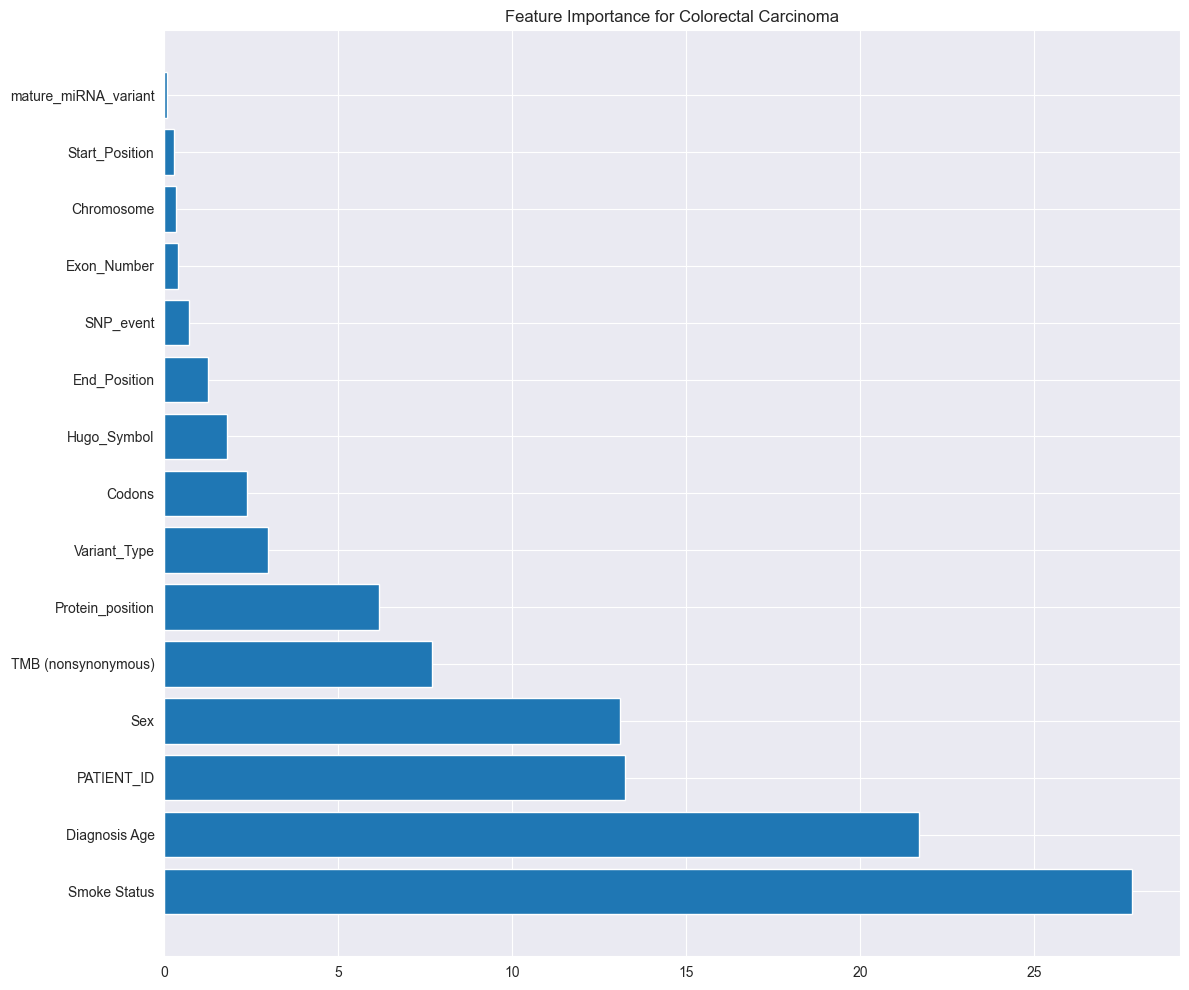


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
TCF7L2       0.008849  0.000836  10.580617
APC          0.055934  0.006353   8.804598
SOX9         0.007430  0.001904   3.902197


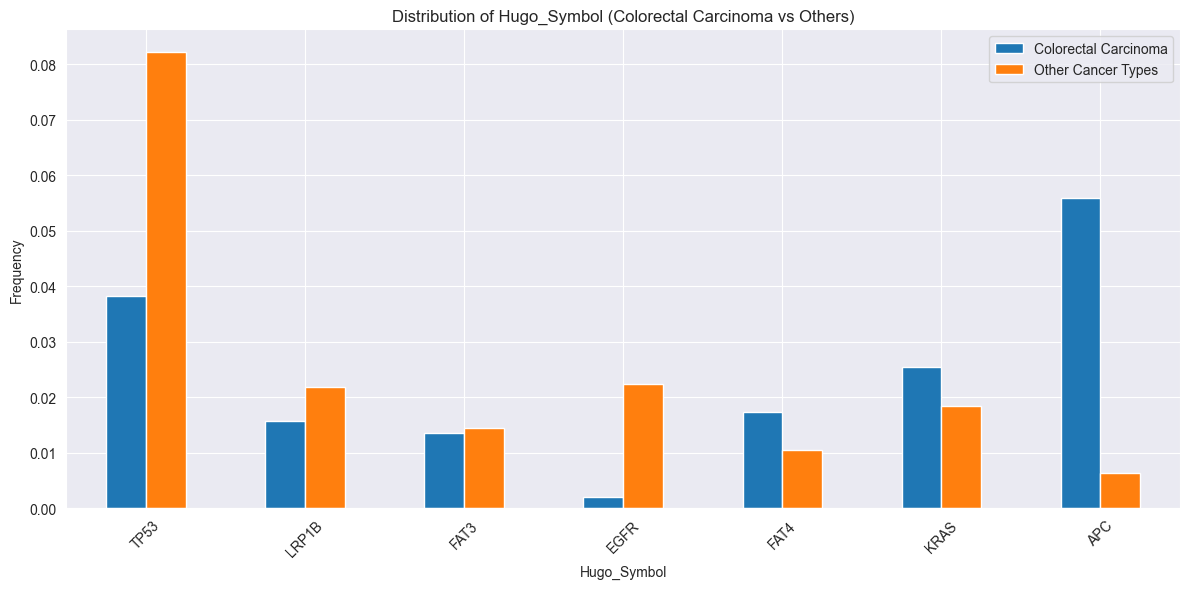


Feature: Sex
Top values by lift ratio:
         Cancer     Other      Lift
Sex                                
Female  0.37559  0.301765  1.244642
Male    0.62441  0.698235  0.894270


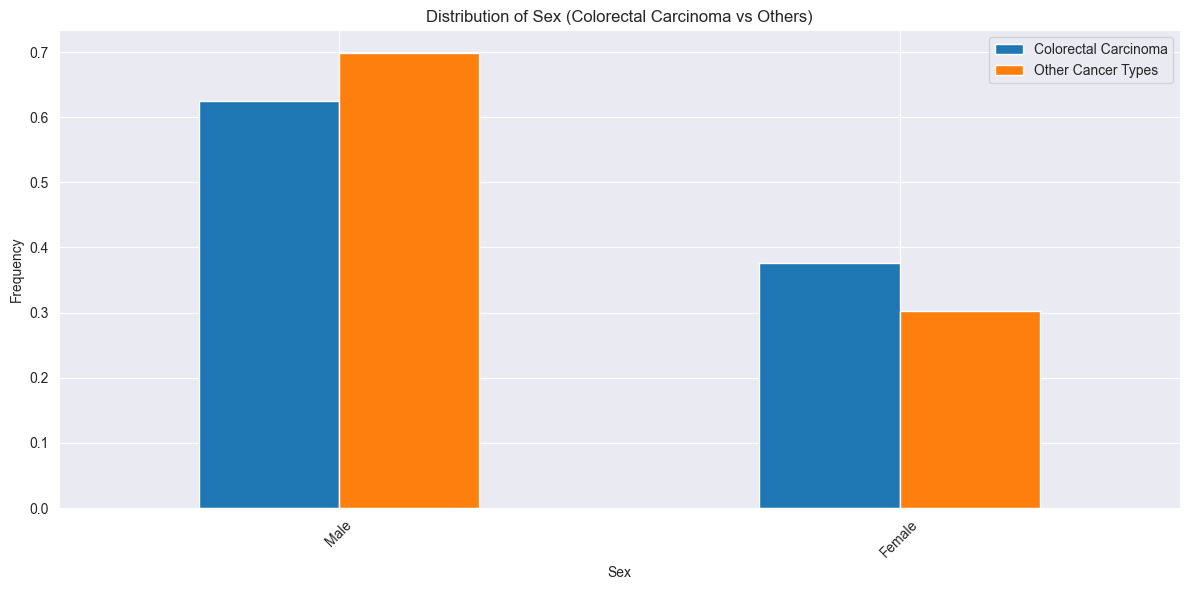


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
TNP           0.000042  0.000018  2.345703
INS           0.041908  0.034611  1.210841
DEL           0.108236  0.099865  1.083822


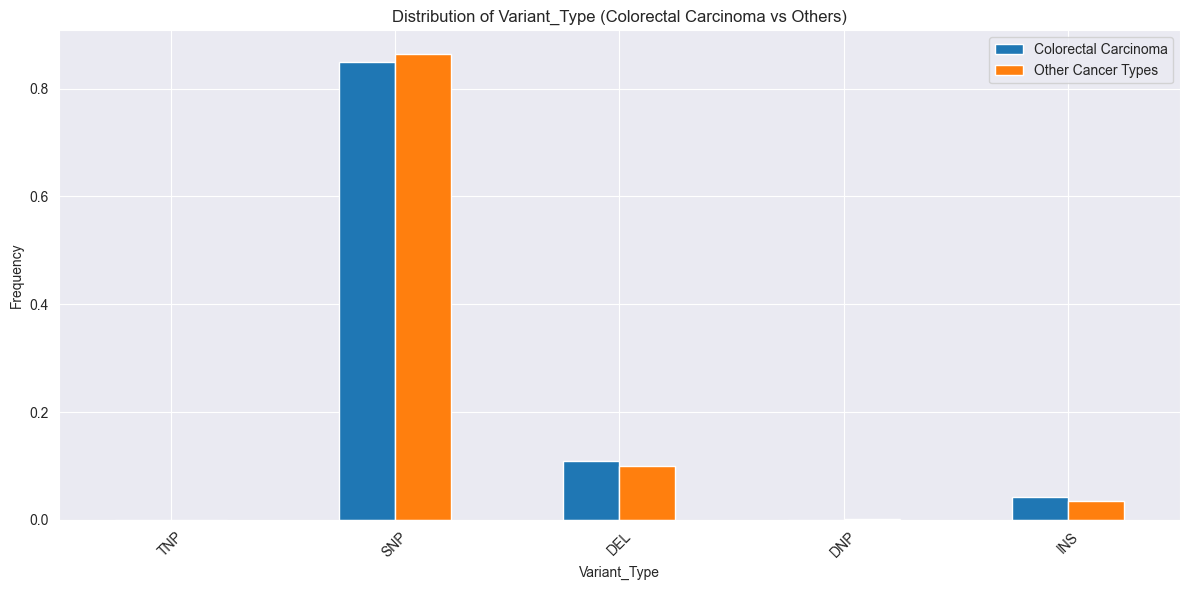


Feature: SNP_event
Top values by lift ratio:
             Cancer     Other       Lift
SNP_event                               
AAAAG>-    0.001044  0.000071  14.660642
GG>A       0.000209  0.000036   5.864257
GTT>-      0.000292  0.000053   5.473306


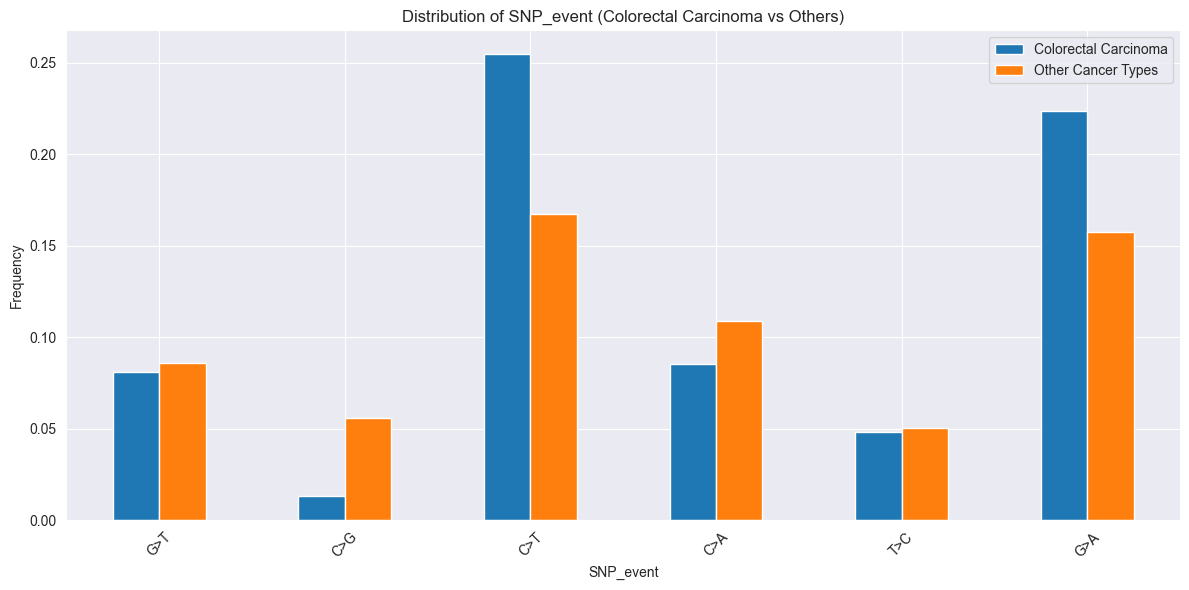


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.731298  1.367432
Nonsmoker        0.0  0.123514  0.000000
Smoker           0.0  0.145188  0.000000


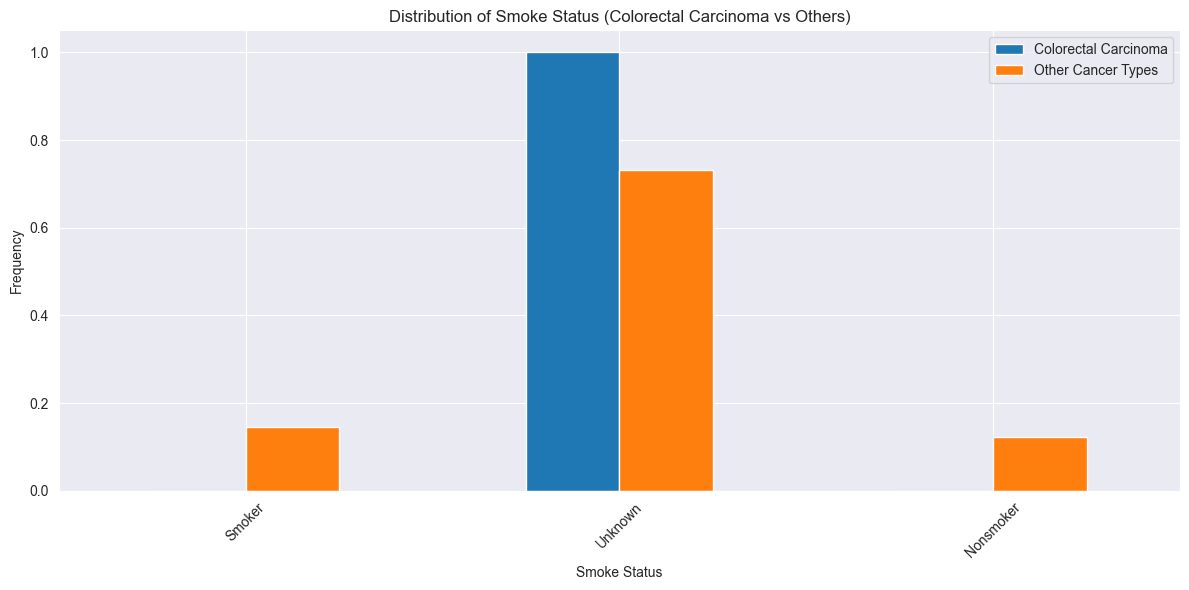

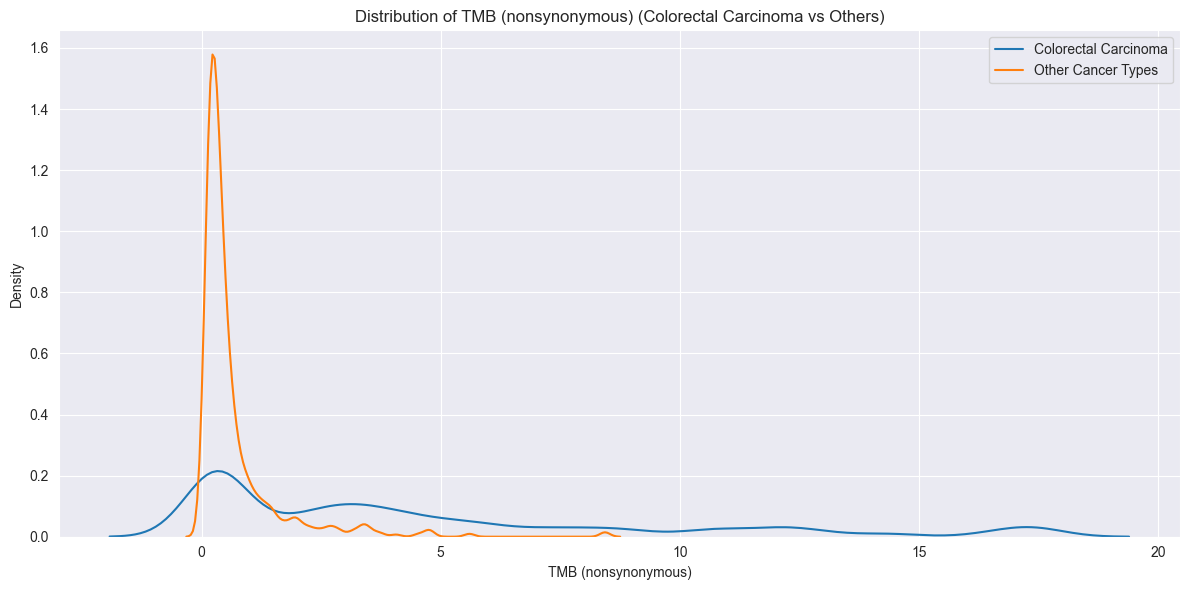


Feature: TMB (nonsynonymous)
Mean for Colorectal Carcinoma: 4.5501
Mean for Other Cancer Types: 0.6728
Difference: 576.25%


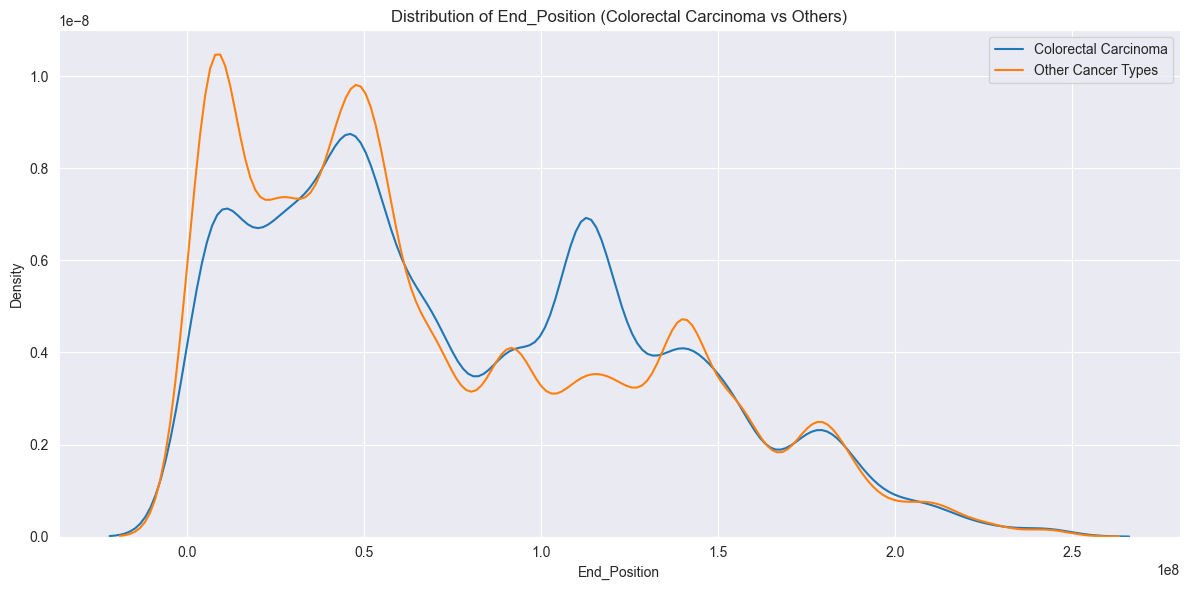


Feature: End_Position
Mean for Colorectal Carcinoma: 79413072.9857
Mean for Other Cancer Types: 72797090.2855
Difference: 9.09%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Truncation          0.249322  0.205904  1.210862
Substitution/Indel  0.750678  0.794096  0.945325


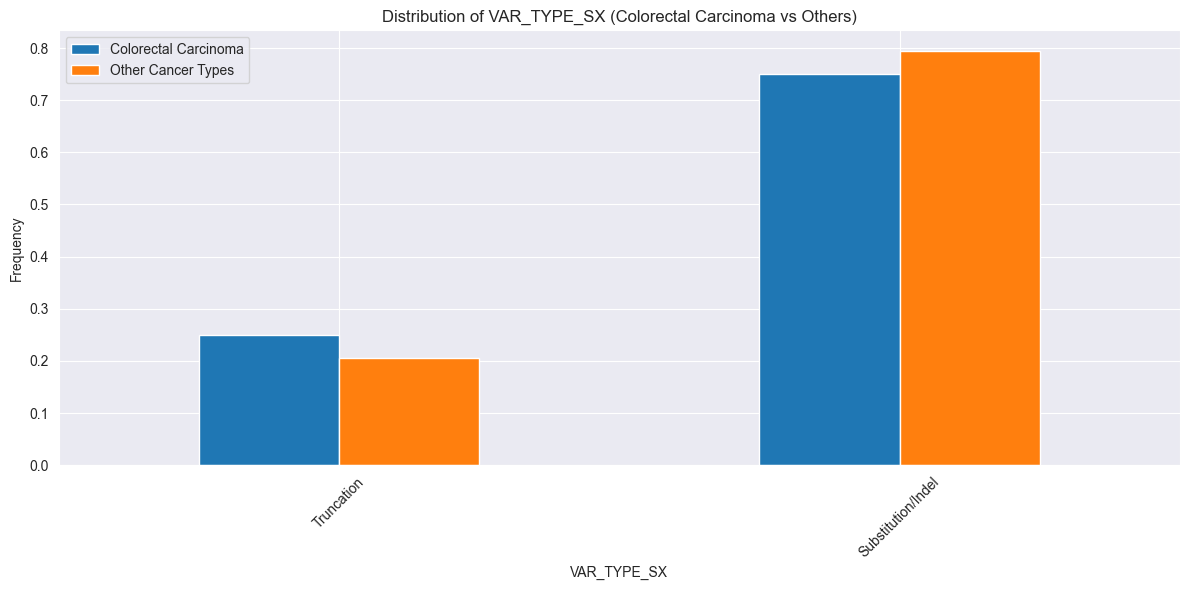

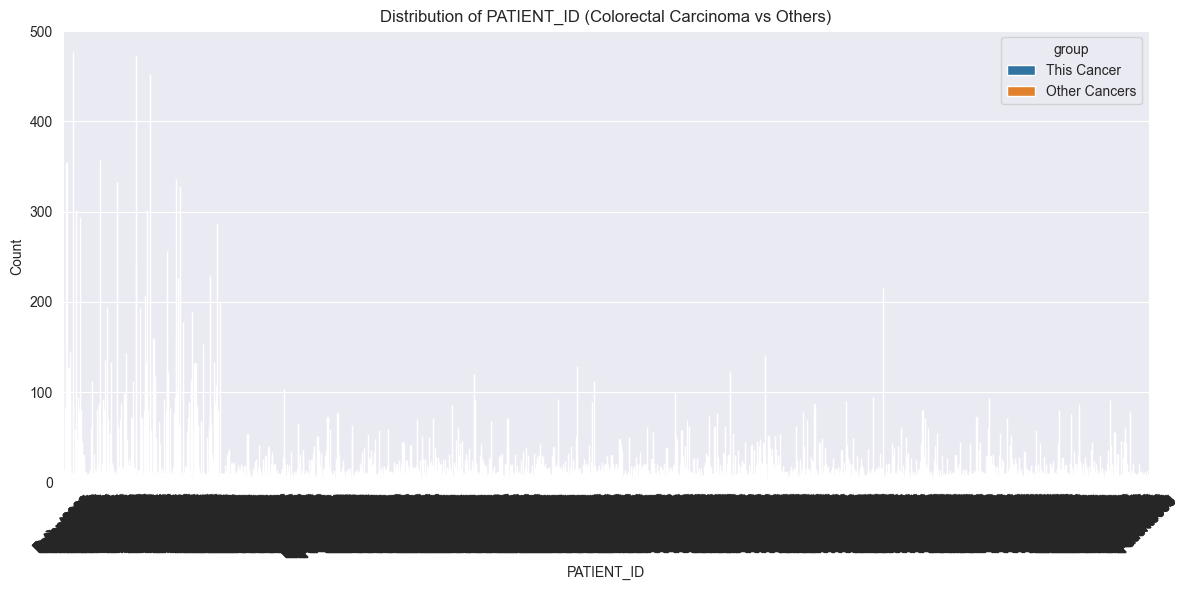

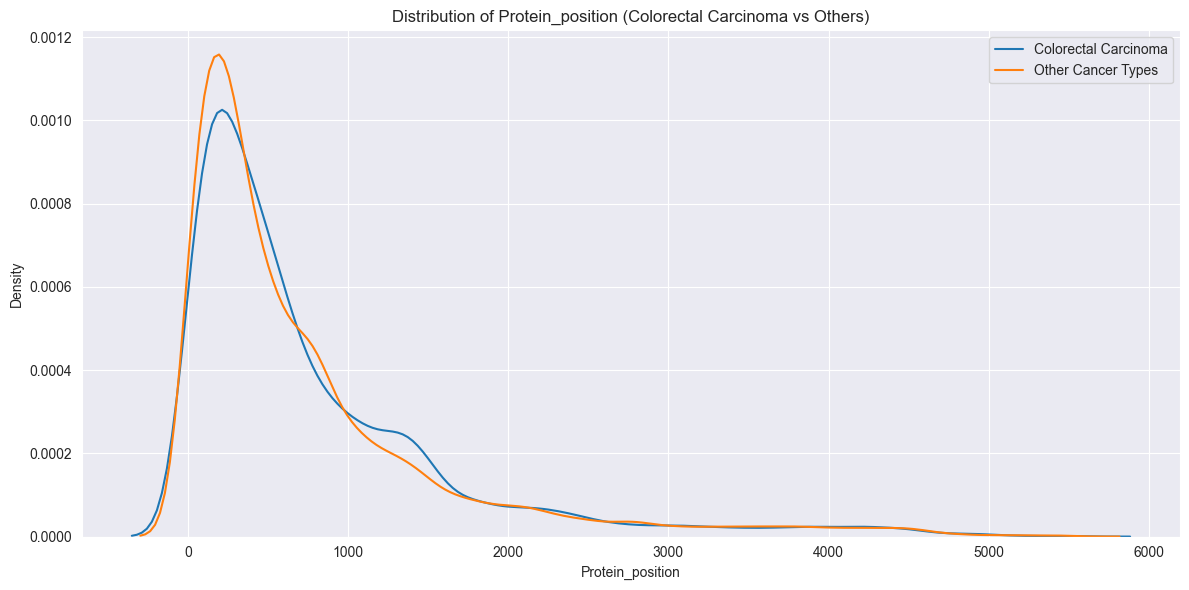


Feature: Protein_position
Mean for Colorectal Carcinoma: 787.8664
Mean for Other Cancer Types: 757.6787
Difference: 3.98%

Analyzing categorical feature interactions...

Top feature combinations for Colorectal Carcinoma:
       Feature1  Value1      Feature2   Value2  Cancer_Count  Cancer_Pct  \
6   Hugo_Symbol     APC     SNP_event      T>-            63    0.262971   
7   Hugo_Symbol  TCF7L2     SNP_event      ->A             9    0.037567   
8   Hugo_Symbol   EP300     SNP_event      ->C             8    0.033393   
15          Sex    Male     SNP_event  AAAAG>-            18    0.075135   
3   Hugo_Symbol     ERG  Variant_Type      DEL             5    0.020871   

    Other_Pct       Lift  
6    0.003559  73.889636  
7    0.001000  37.567308  
8    0.001000  33.393163  
15   0.003559  21.111324  
3    0.001000  20.870727  


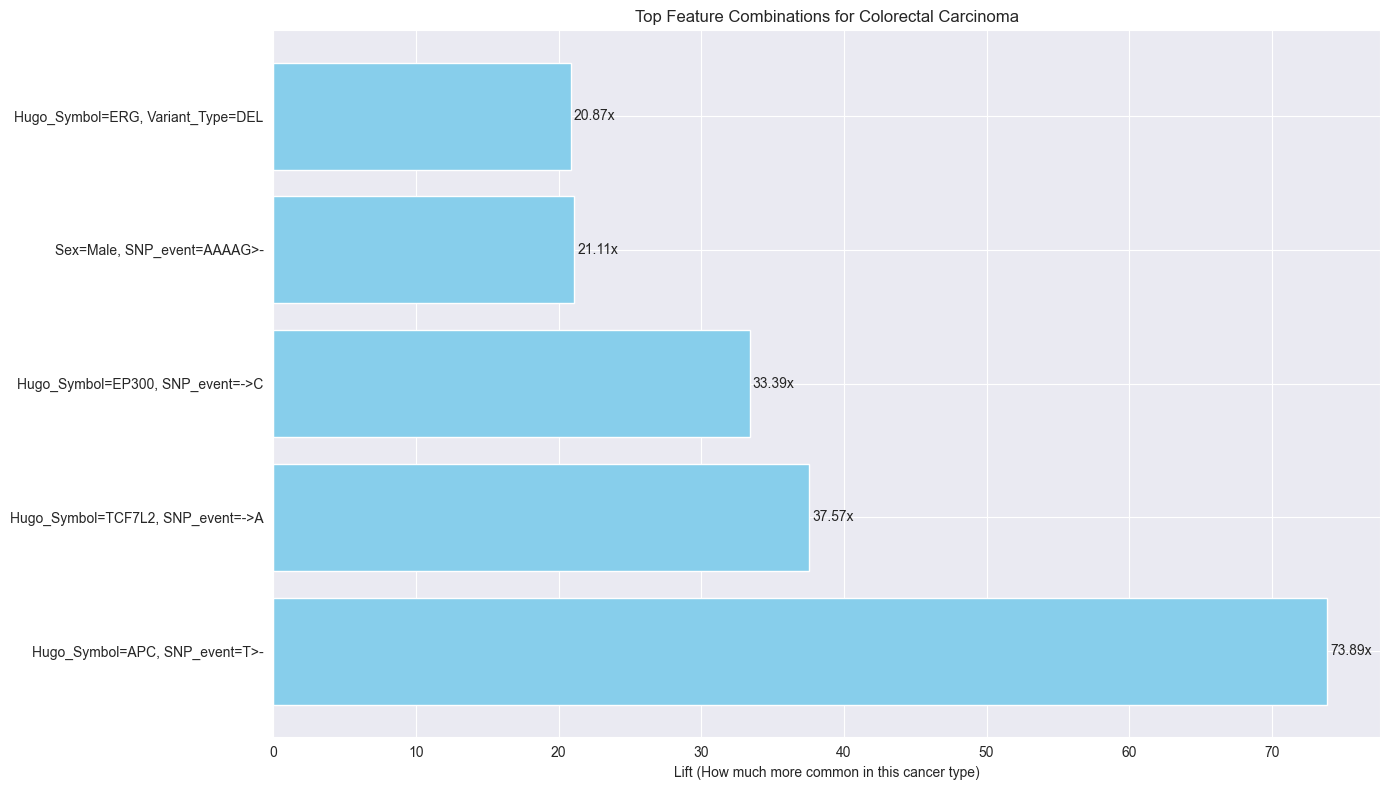


===== ANALYZING CANCER TYPE: Liver Hepatocellular Carcinoma =====
Number of samples: 7832

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


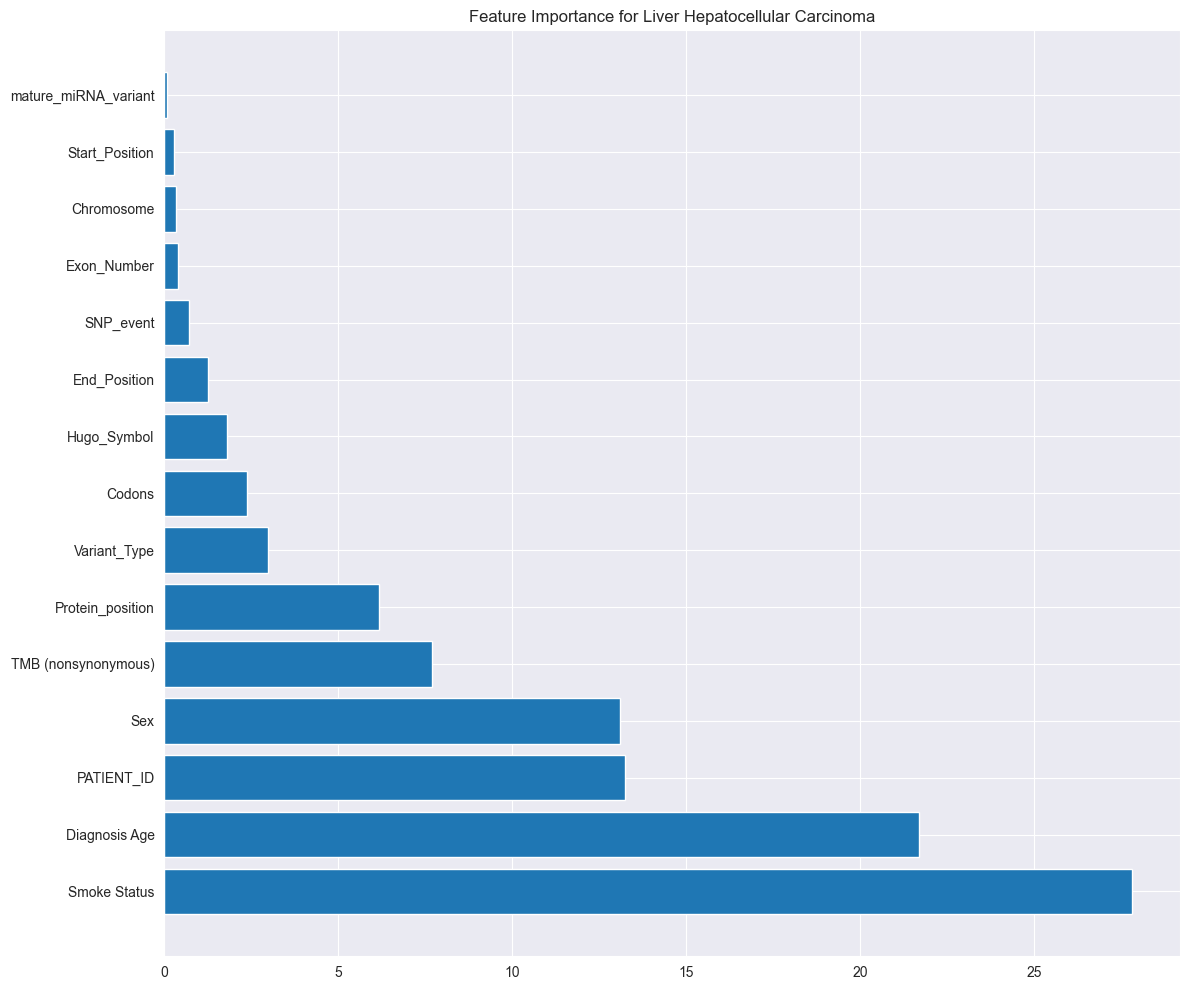


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other      Lift
Hugo_Symbol                              
AXIN1        0.016343  0.001950  8.382674
CTNNB1       0.032048  0.004314  7.428667
CDKN1A       0.002554  0.000470  5.431788


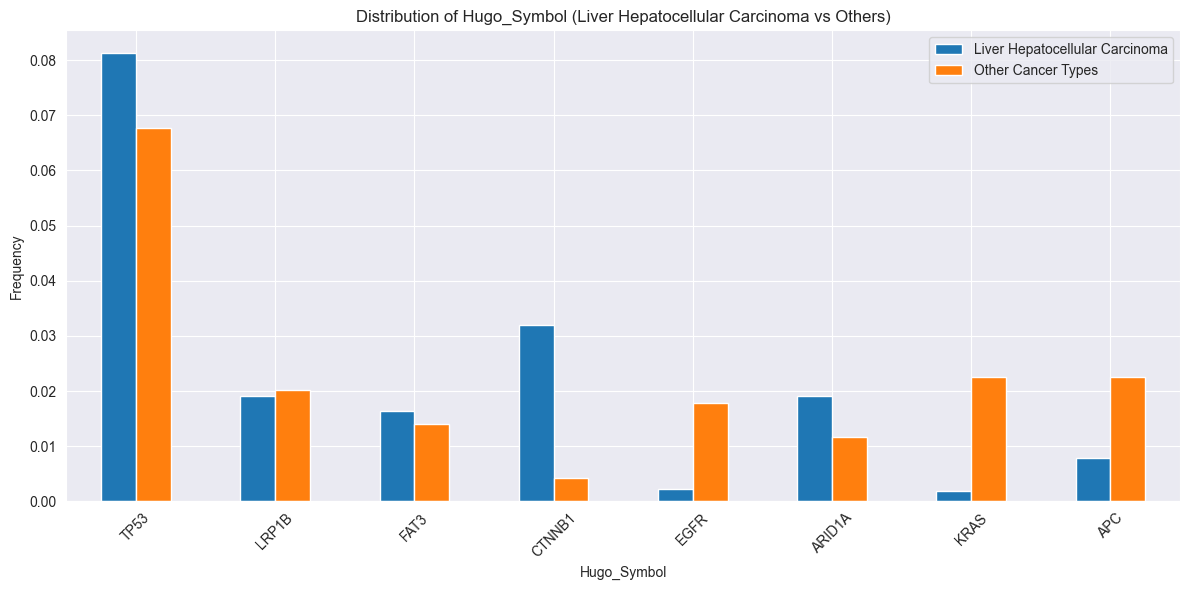


Feature: Sex
Top values by lift ratio:
          Cancer     Other      Lift
Sex                                 
Male    0.892109  0.652784  1.366622
Female  0.107891  0.347216  0.310731


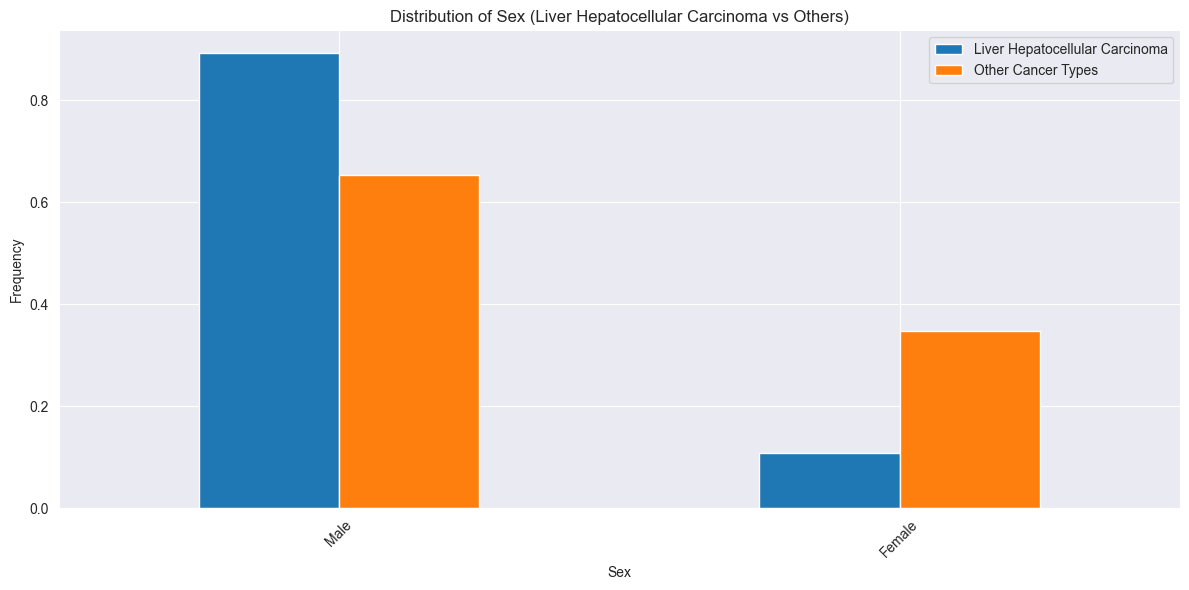


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
SNP           0.898876  0.856169  1.049882
DEL           0.077375  0.105073  0.736390
INS           0.023621  0.038218  0.618053


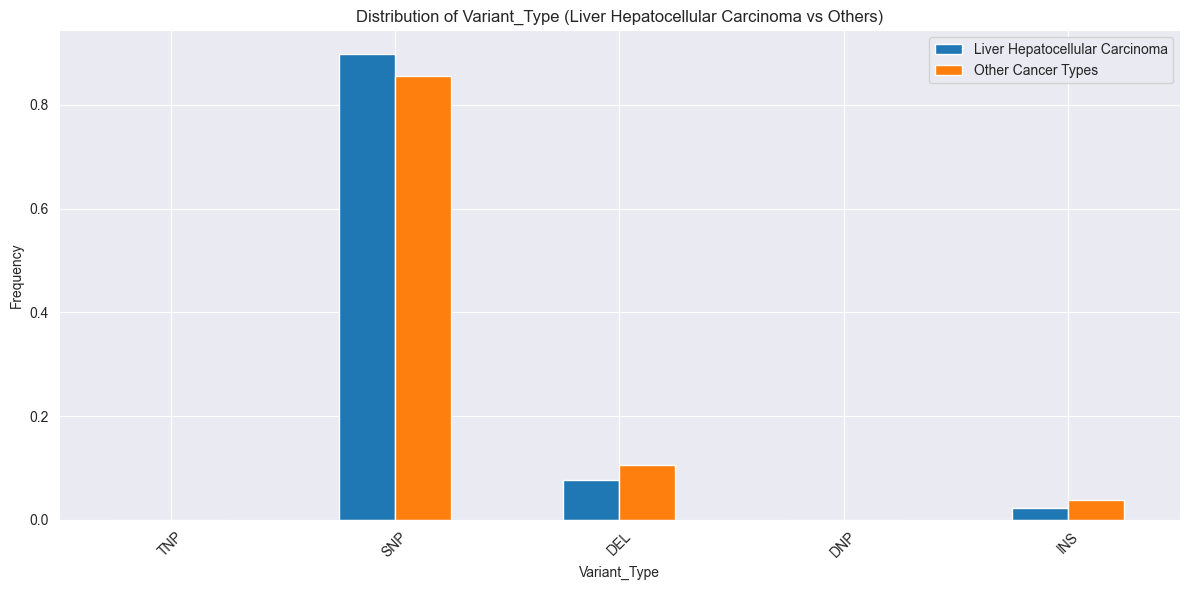


Feature: SNP_event
Top values by lift ratio:
                          Cancer     Other      Lift
SNP_event                                           
CTGT>-                  0.000383  0.000014  27.70212
->CGCC                  0.000255  0.000014  18.46808
CAACAATGCTGGCTGCAGCG>-  0.000255  0.000014  18.46808


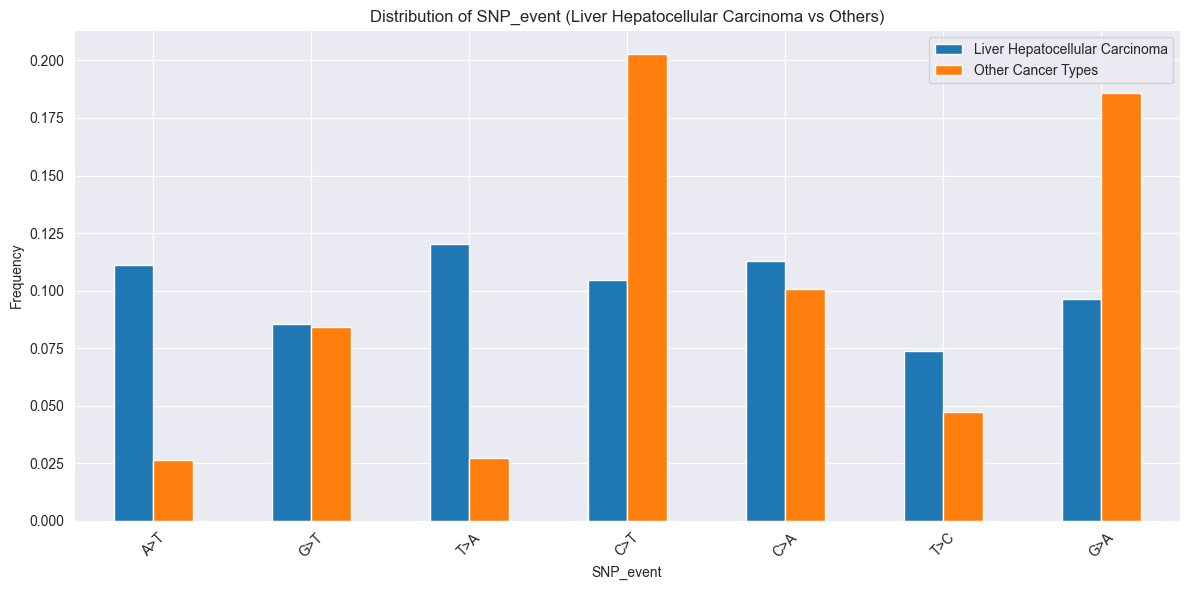


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.791209  1.263889
Nonsmoker        0.0  0.095975  0.000000
Smoker           0.0  0.112816  0.000000


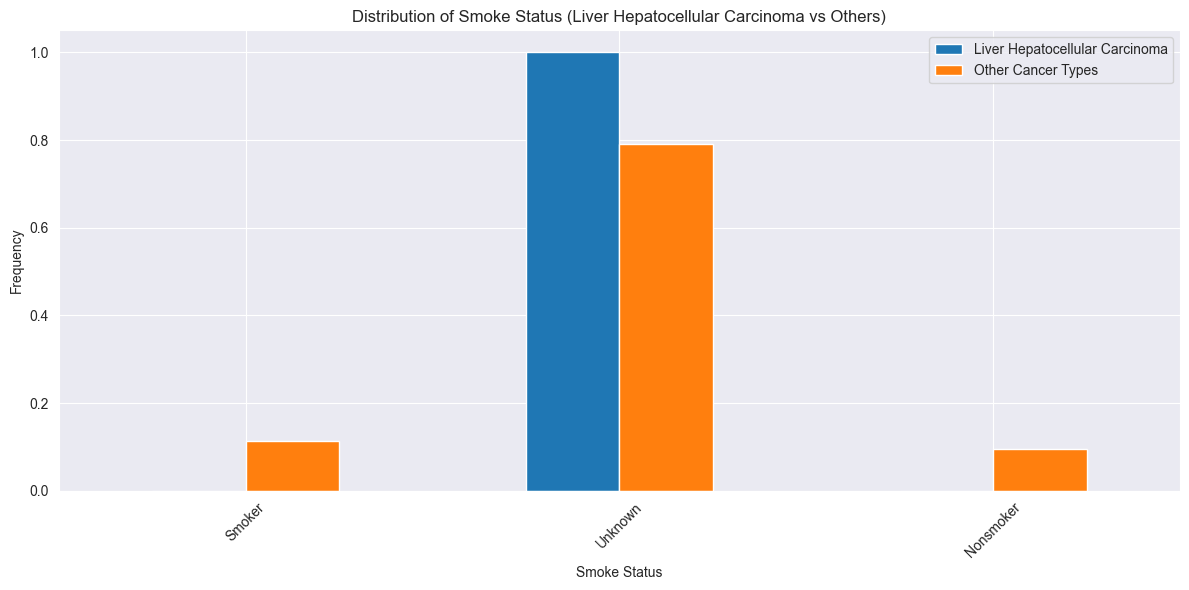

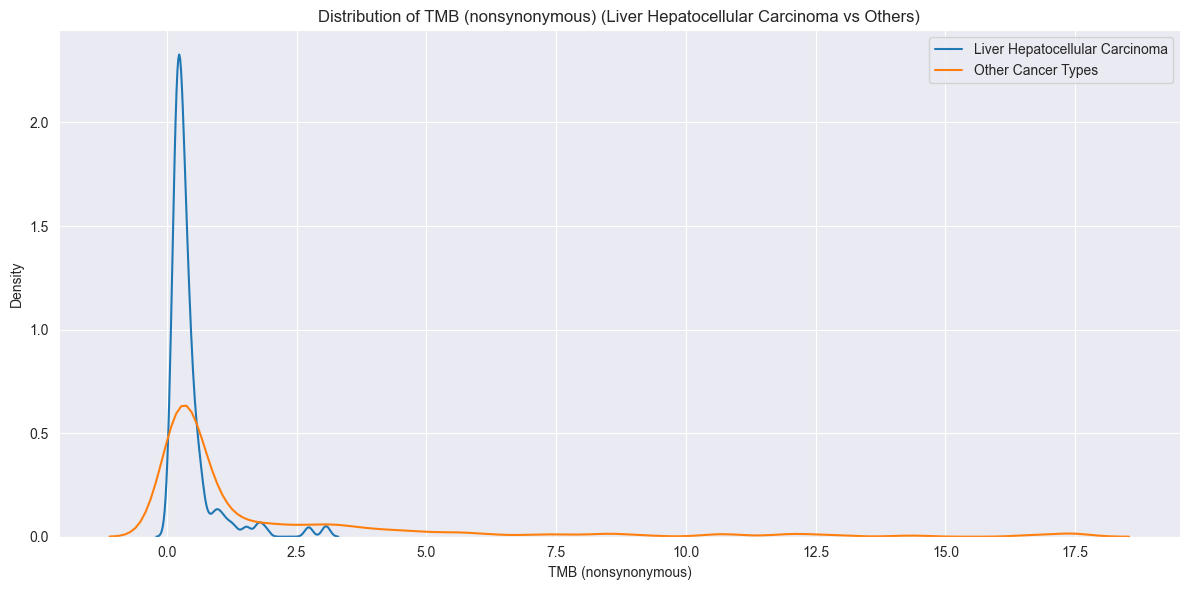


Feature: TMB (nonsynonymous)
Mean for Liver Hepatocellular Carcinoma: 0.4326
Mean for Other Cancer Types: 1.9832
Difference: -78.19%


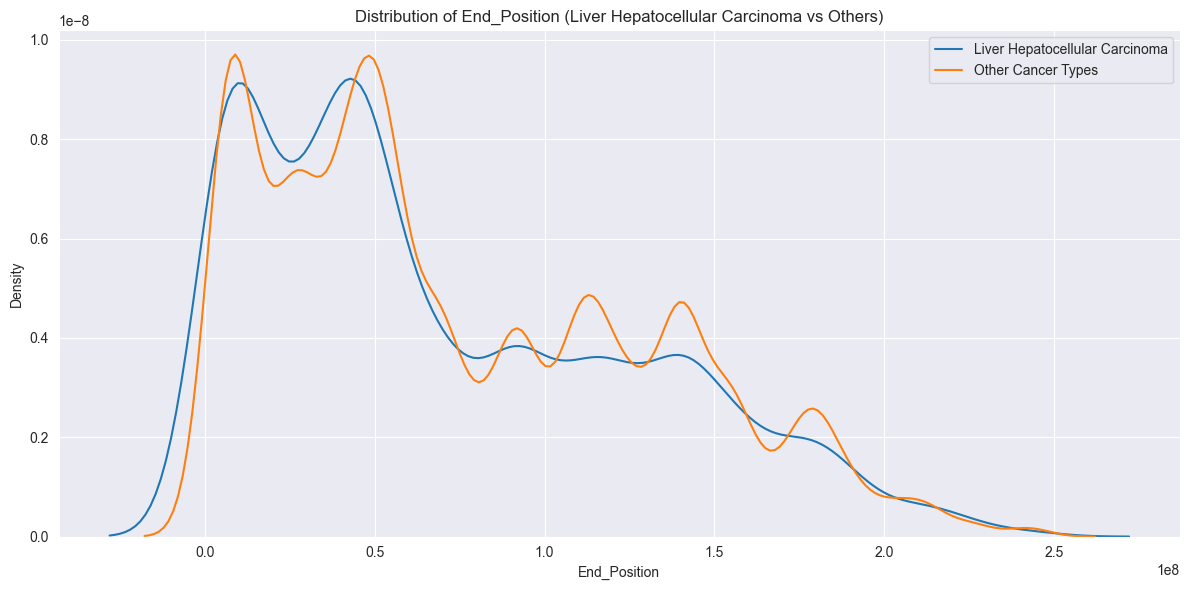


Feature: End_Position
Mean for Liver Hepatocellular Carcinoma: 70450985.7416
Mean for Other Cancer Types: 75242767.0369
Difference: -6.37%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Substitution/Indel  0.810521  0.777934  1.041888
Truncation          0.189479  0.222066  0.853257


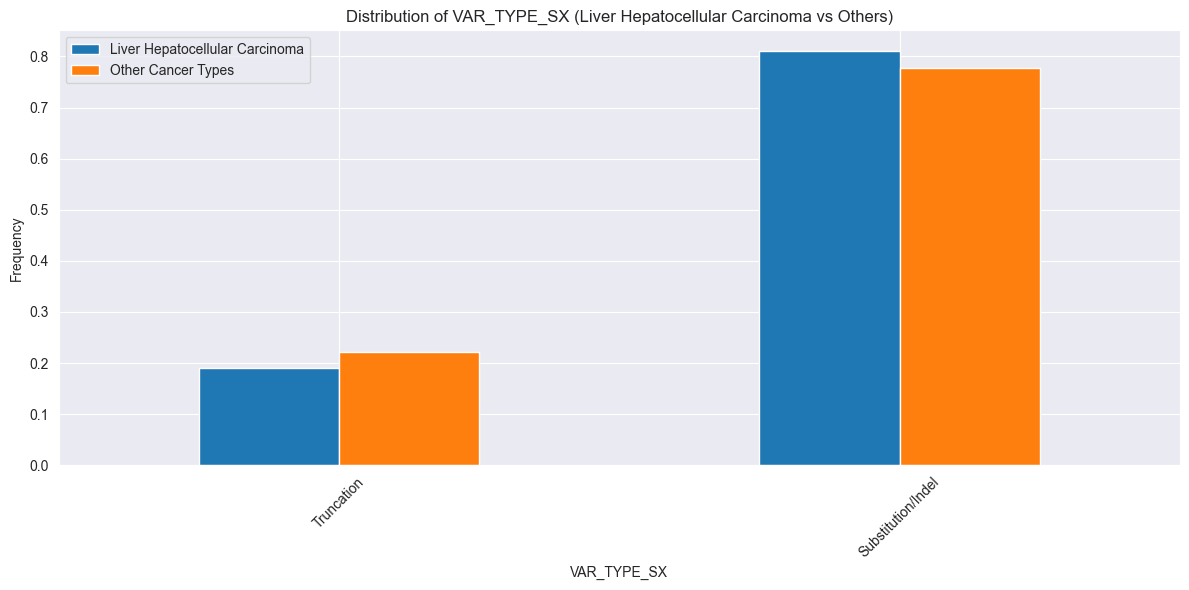

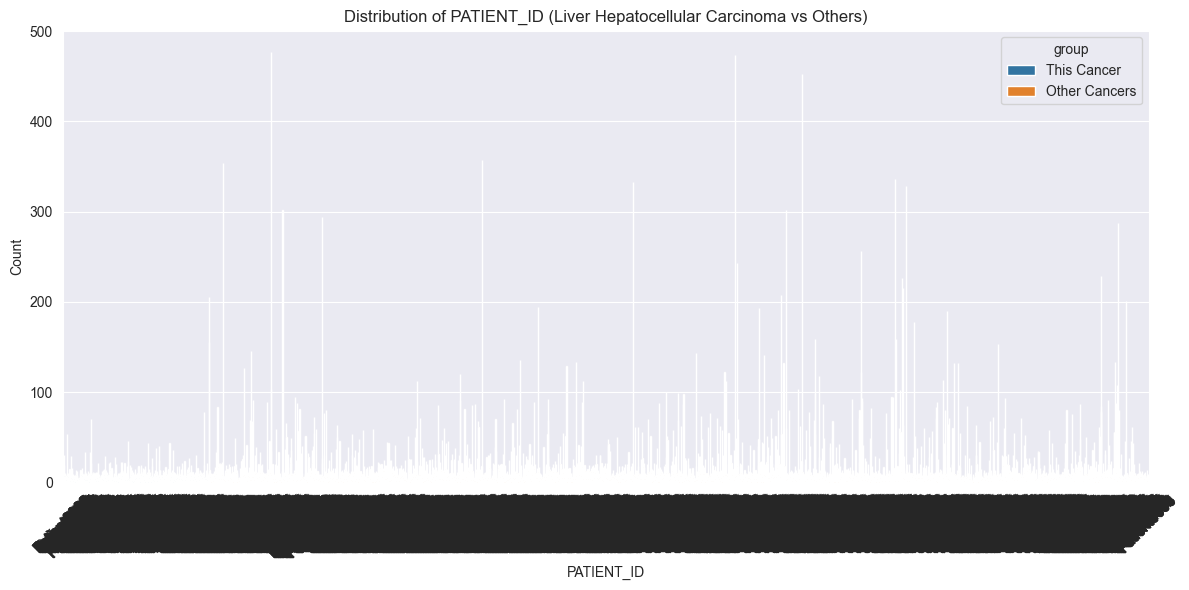

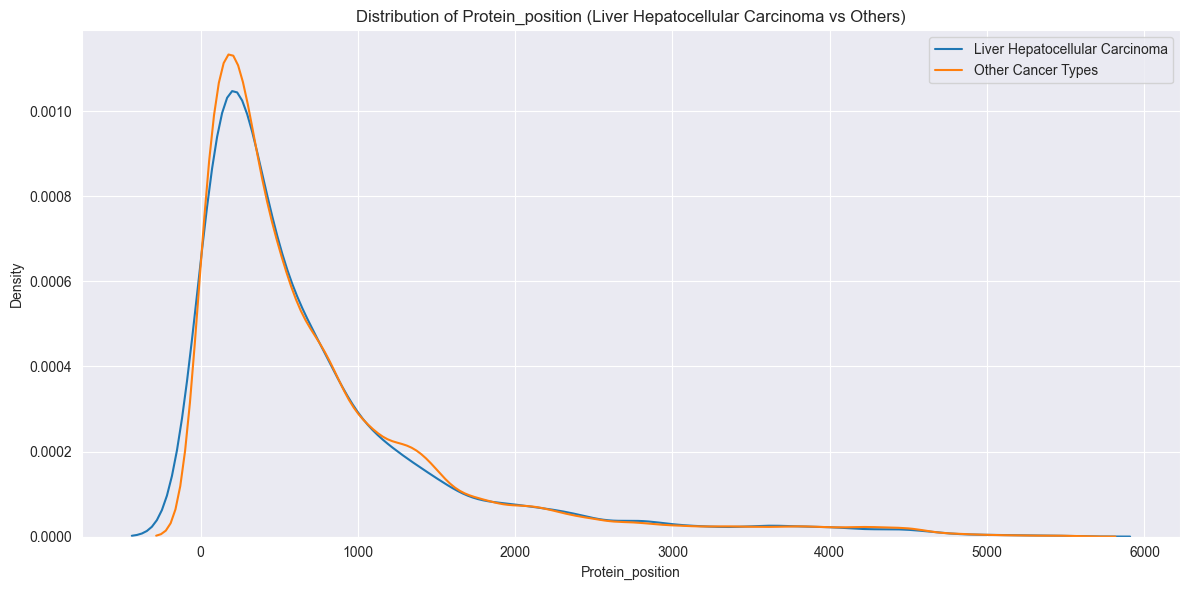


Feature: Protein_position
Mean for Liver Hepatocellular Carcinoma: 749.7075
Mean for Other Cancer Types: 768.5419
Difference: -2.45%

Analyzing categorical feature interactions...

Top feature combinations for Liver Hepatocellular Carcinoma:
      Feature1  Value1      Feature2 Value2  Cancer_Count  Cancer_Pct  \
6  Hugo_Symbol   STAT3     SNP_event    T>A            10    0.127681   
7  Hugo_Symbol     AXL     SNP_event    T>A             8    0.102145   
8  Hugo_Symbol    TSC1     SNP_event    T>A             7    0.089377   
3  Hugo_Symbol  CDKN1A  Variant_Type    DEL            10    0.127681   
4  Hugo_Symbol    TSC2  Variant_Type    INS             8    0.102145   

   Other_Pct        Lift  
6   0.001000  127.681307  
7   0.001383   73.872319  
8   0.001383   64.638279  
3   0.005531   23.085100  
4   0.005531   18.468080  


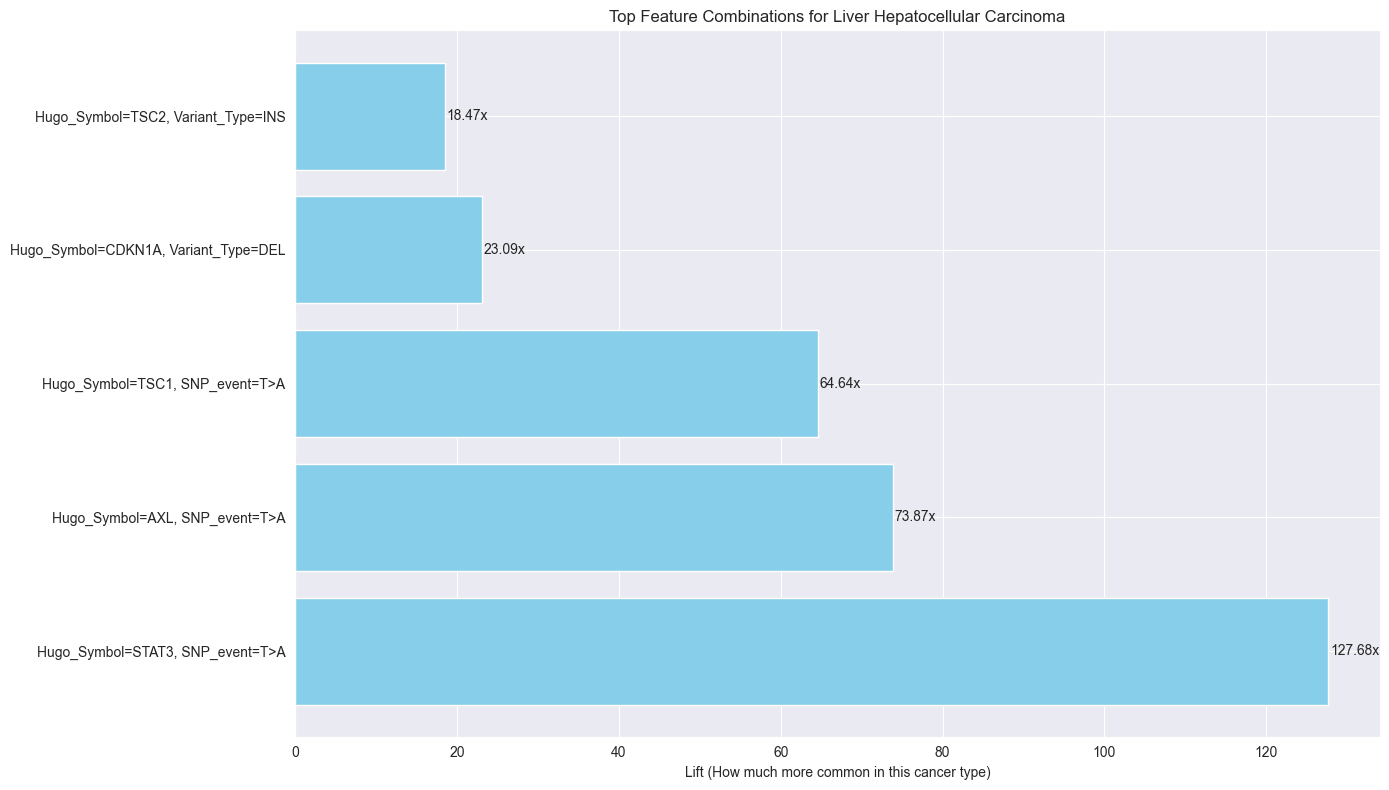


===== ANALYZING CANCER TYPE: Soft Tissue Sarcoma =====
Number of samples: 1803

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


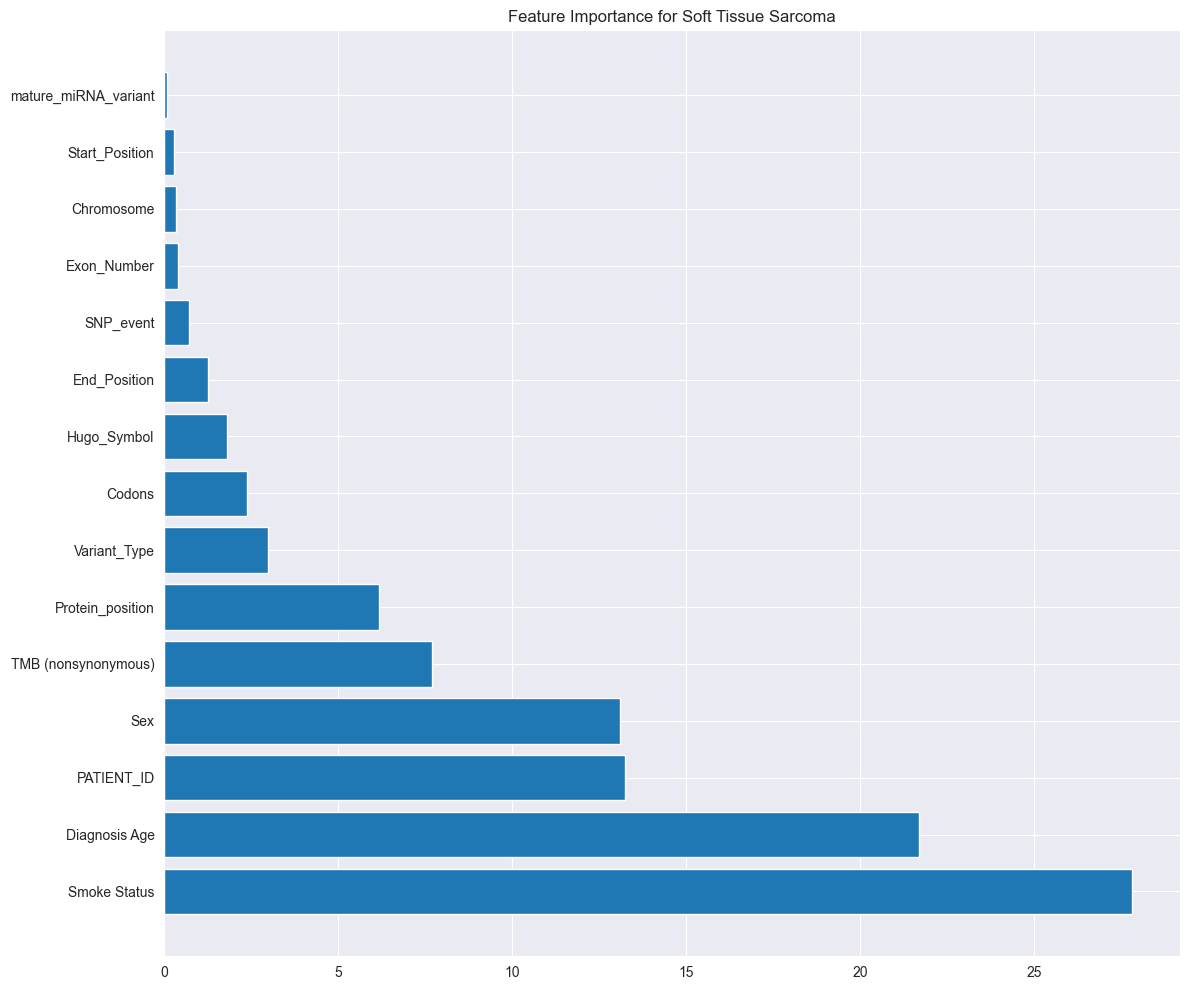


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
KIT          0.034942  0.001927  18.130379
BCL2L11      0.002773  0.000243  11.435619
BCL2L1       0.001109  0.000128   8.691070


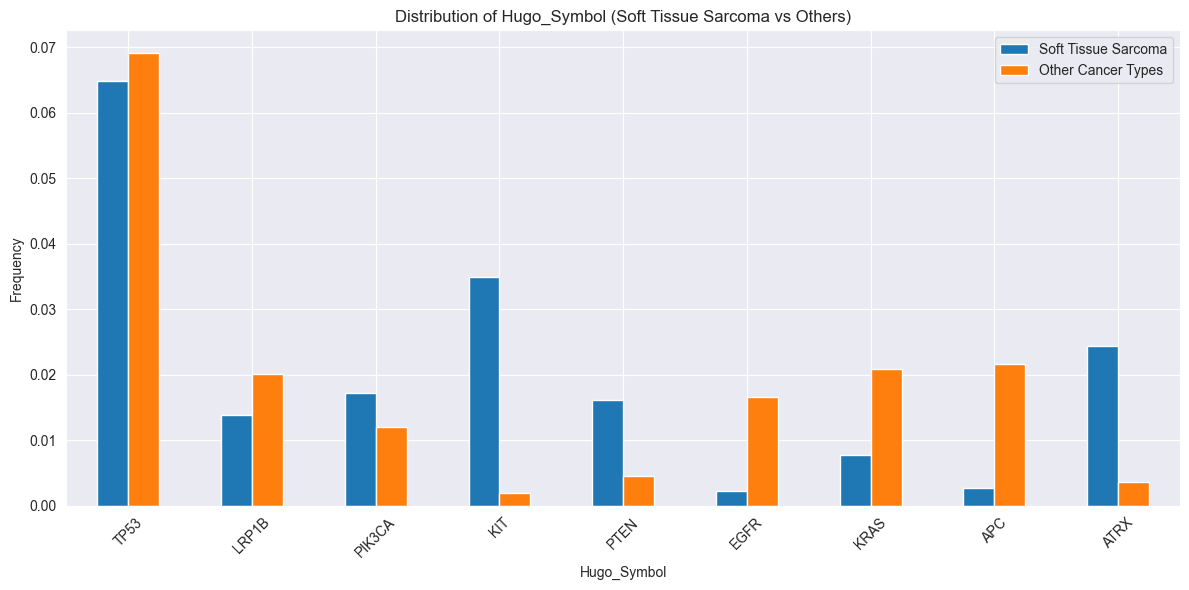


Feature: Sex
Top values by lift ratio:
         Cancer     Other      Lift
Sex                                
Female  0.38325  0.322463  1.188508
Male    0.61675  0.677537  0.910283


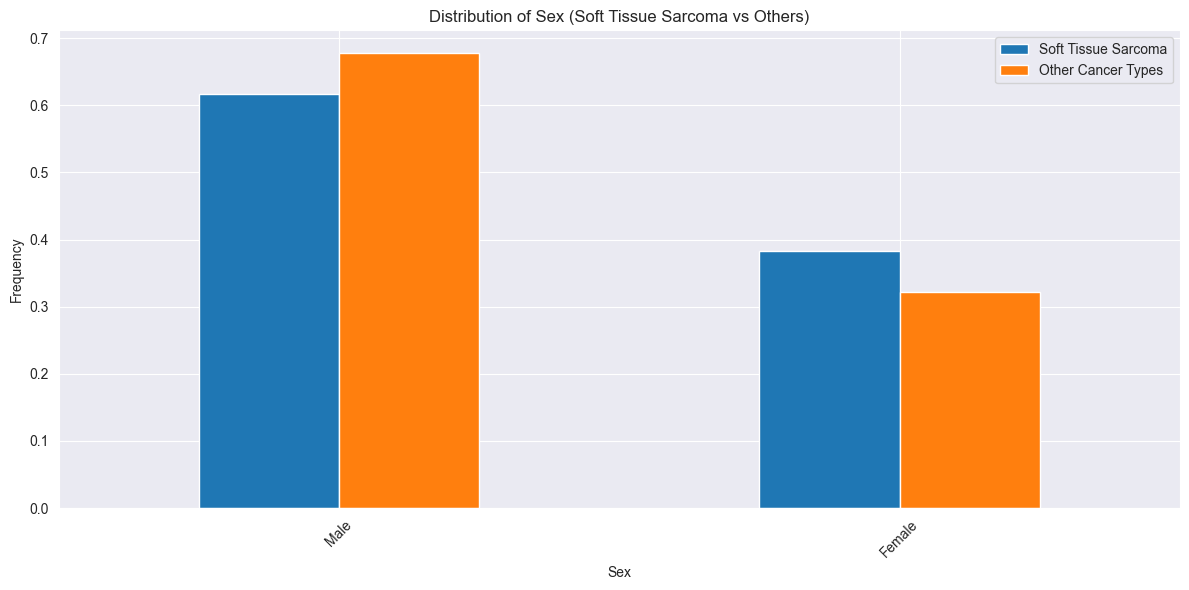


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
DNP           0.001109  0.000459  2.414186
DEL           0.112035  0.102144  1.096836
INS           0.038824  0.036745  1.056573


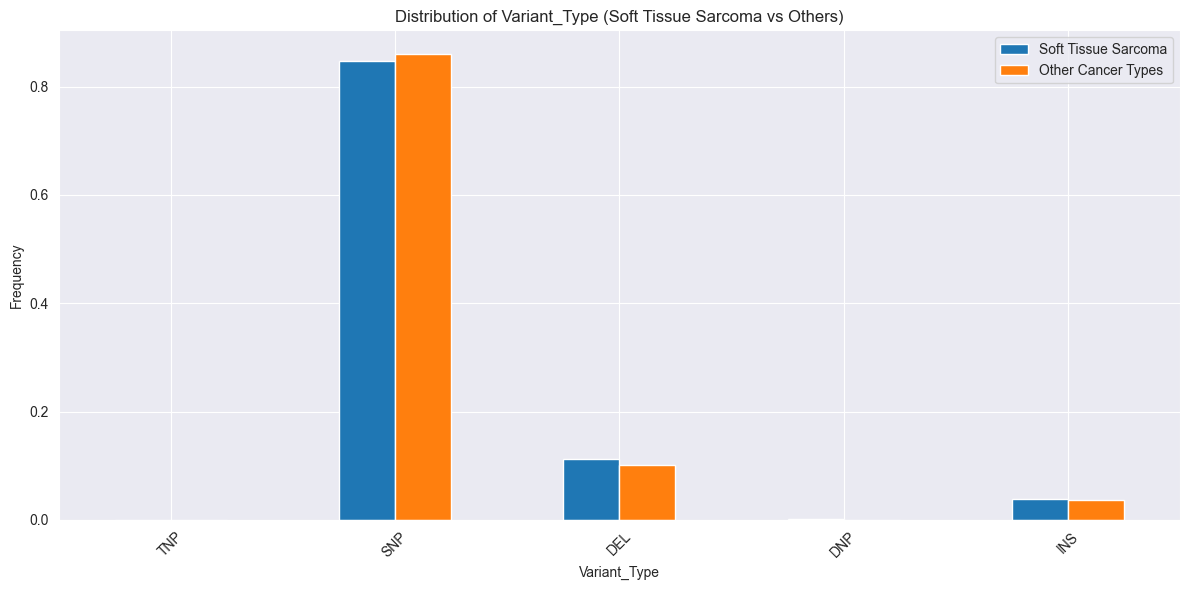


Feature: SNP_event
Top values by lift ratio:
             Cancer     Other       Lift
SNP_event                               
->GGC      0.000555  0.000013  43.455352
->TAC      0.000555  0.000013  43.455352
->AAT      0.000555  0.000013  43.455352


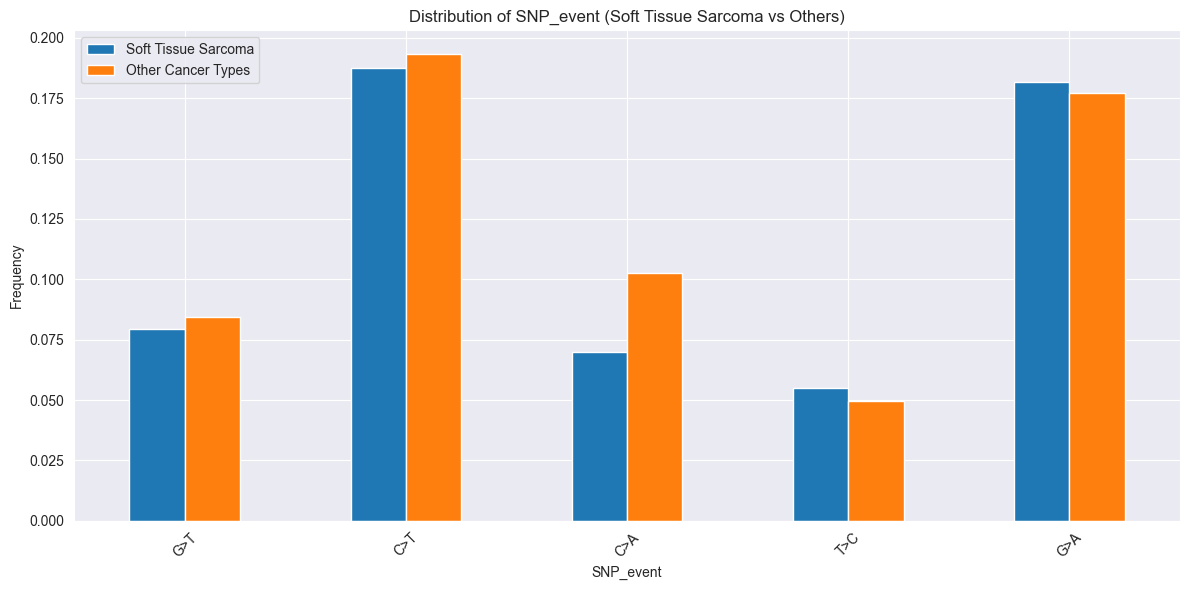


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.807275  1.238735
Nonsmoker        0.0  0.088590  0.000000
Smoker           0.0  0.104135  0.000000


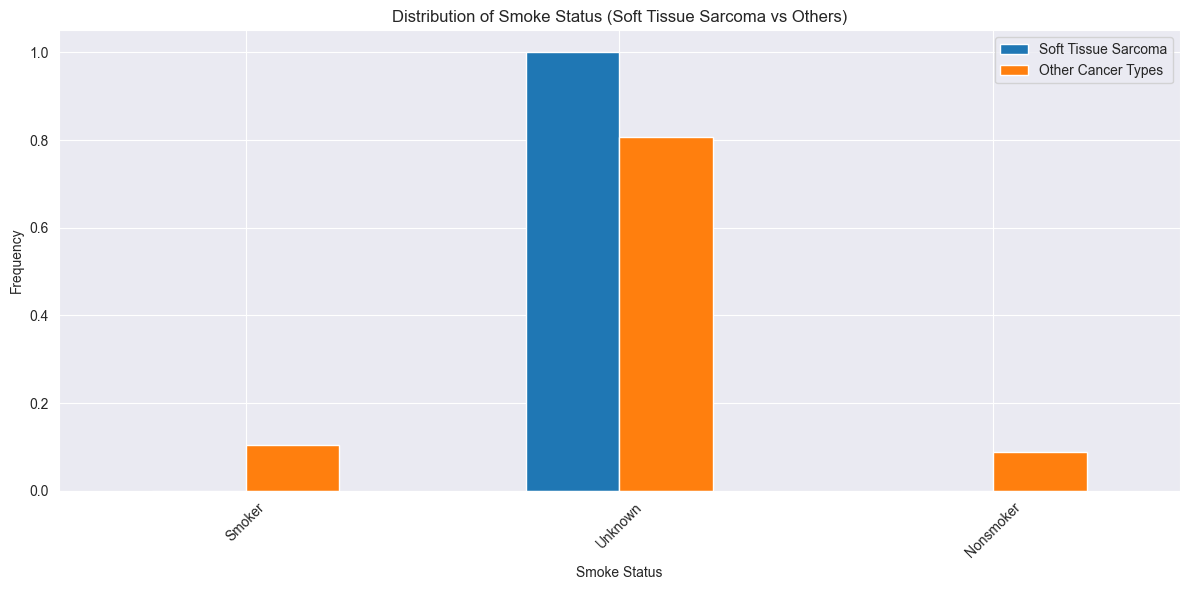

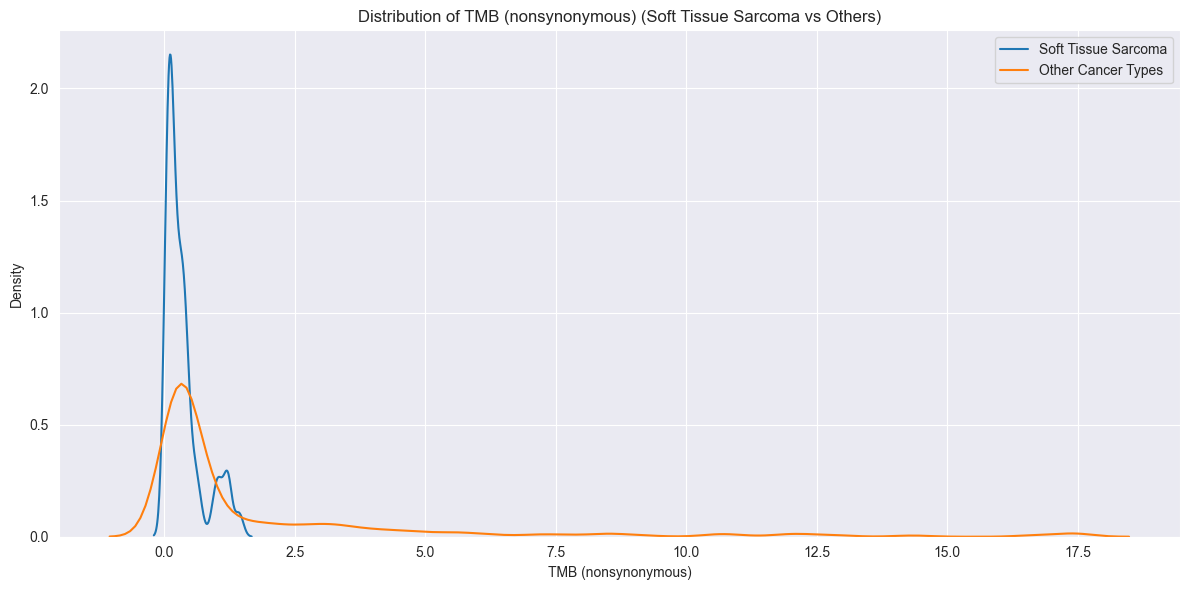


Feature: TMB (nonsynonymous)
Mean for Soft Tissue Sarcoma: 0.3512
Mean for Other Cancer Types: 1.8658
Difference: -81.18%


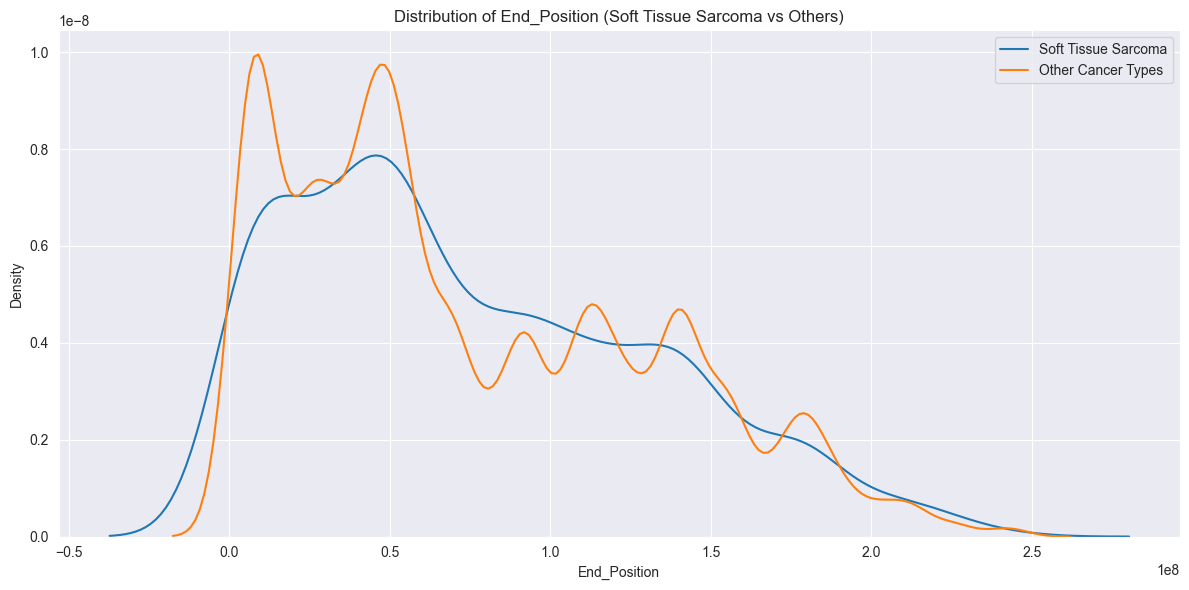


Feature: End_Position
Mean for Soft Tissue Sarcoma: 75841028.6295
Mean for Other Cancer Types: 74750005.1128
Difference: 1.46%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                    Cancer     Other      Lift
VAR_TYPE_SX                                   
Substitution/Indel  0.8264  0.780077  1.059384
Truncation          0.1736  0.219923  0.789364


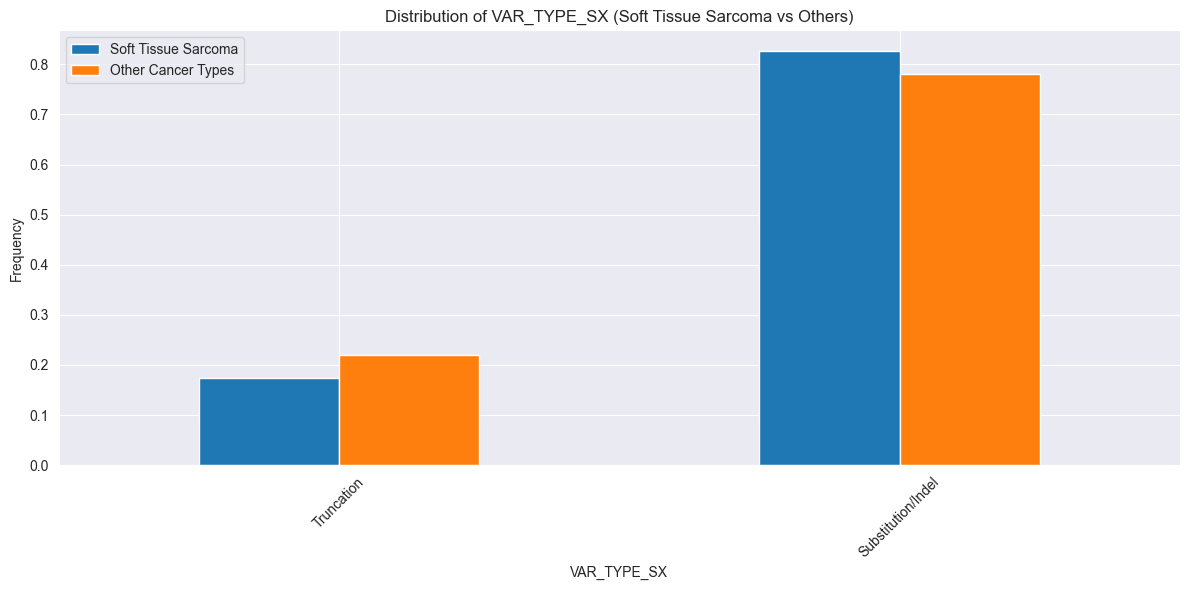

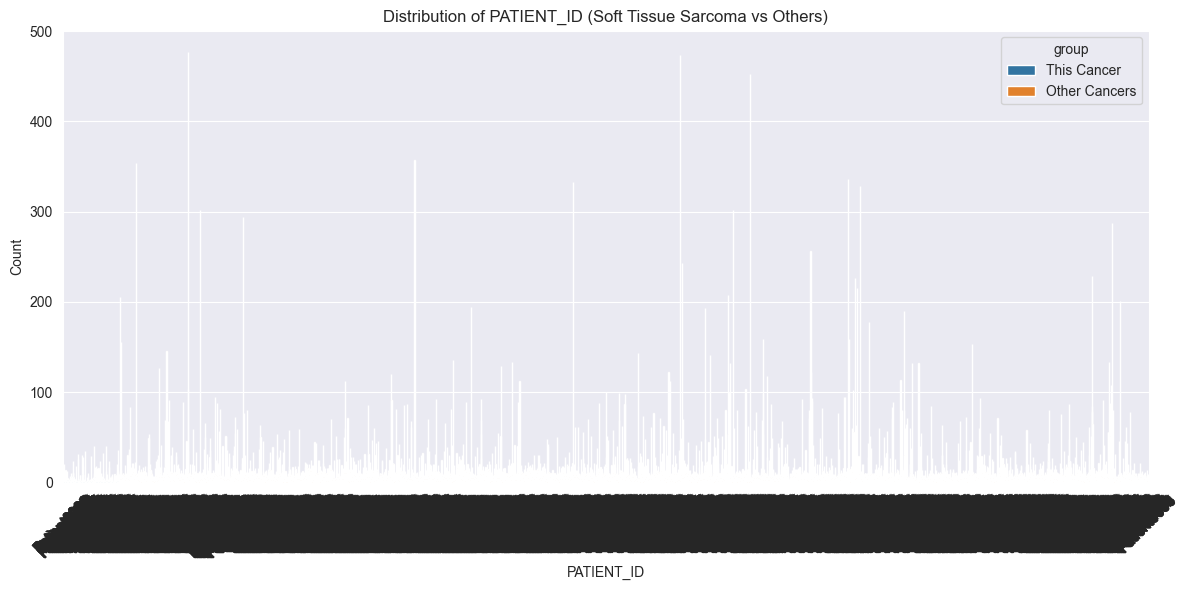

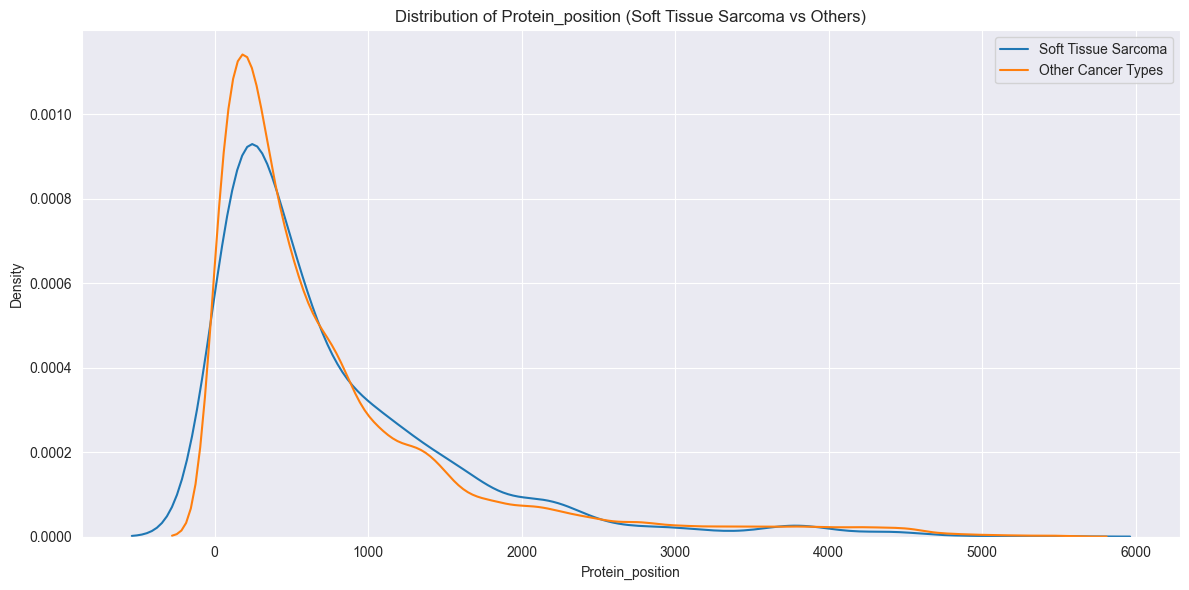


Feature: Protein_position
Mean for Soft Tissue Sarcoma: 760.4831
Mean for Other Cancer Types: 766.8446
Difference: -0.83%

Analyzing categorical feature interactions...

Top feature combinations for Soft Tissue Sarcoma:
        Feature1    Value1      Feature2    Value2  Cancer_Count  Cancer_Pct  \
3    Hugo_Symbol       KIT  Variant_Type       INS            17    0.942873   
6    Hugo_Symbol       KIT     SNP_event  ->TGCCTA            10    0.554631   
20  Variant_Type       INS     SNP_event  ->TGCCTA            10    0.554631   
26     SNP_event  ->TGCCTA  Smoke Status   Unknown            10    0.554631   
15           Sex      Male     SNP_event  ->TGCCTA             8    0.443705   

    Other_Pct        Lift  
3    0.001276  738.740987  
6    0.001000  554.631170  
20   0.001000  554.631170  
26   0.001000  554.631170  
15   0.001000  443.704936  


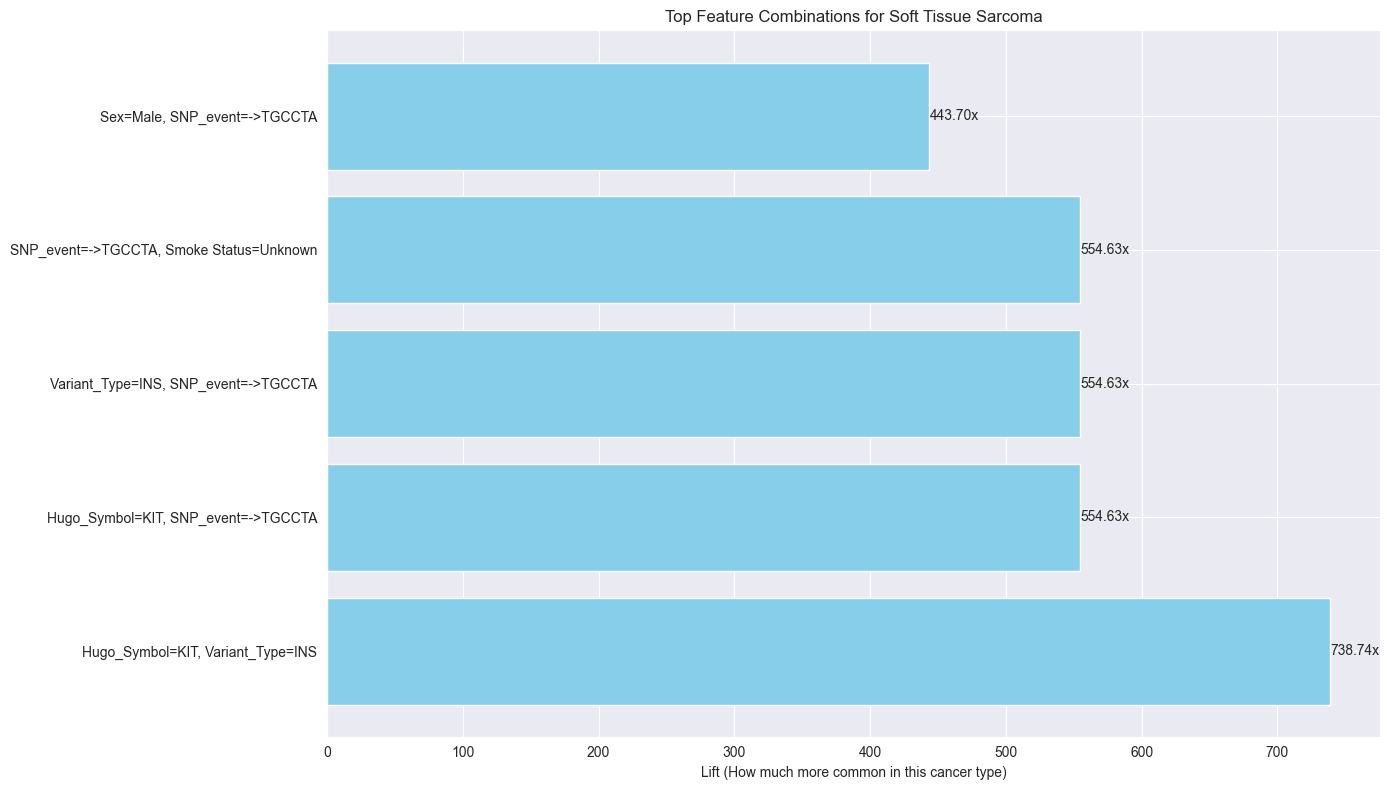


===== ANALYZING CANCER TYPE: Gastric Cancer =====
Number of samples: 9031

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


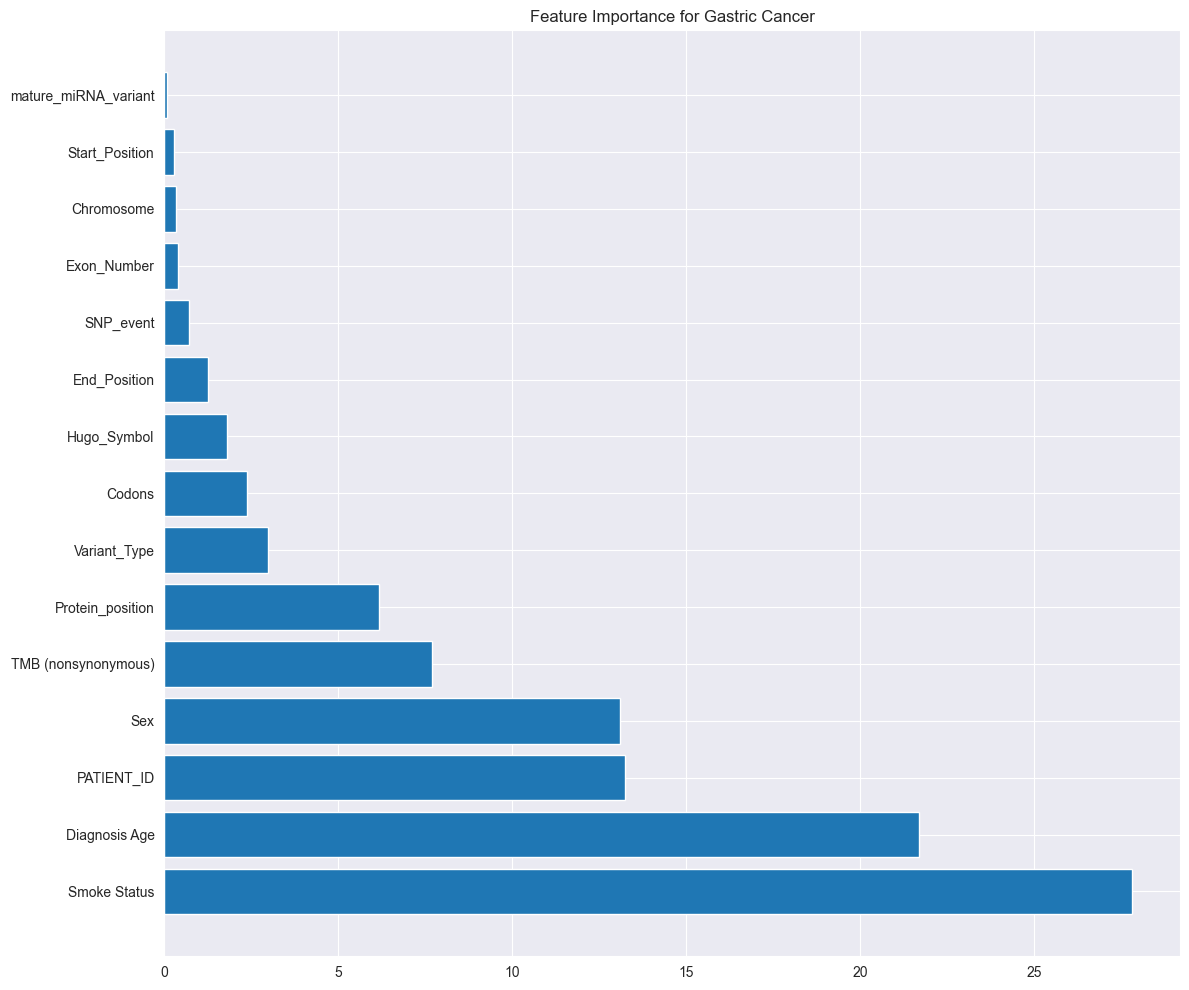


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
RHOA         0.006865  0.000492  13.950564
CDH1         0.013841  0.001406   9.844148
ERBB3        0.008858  0.003079   2.876829


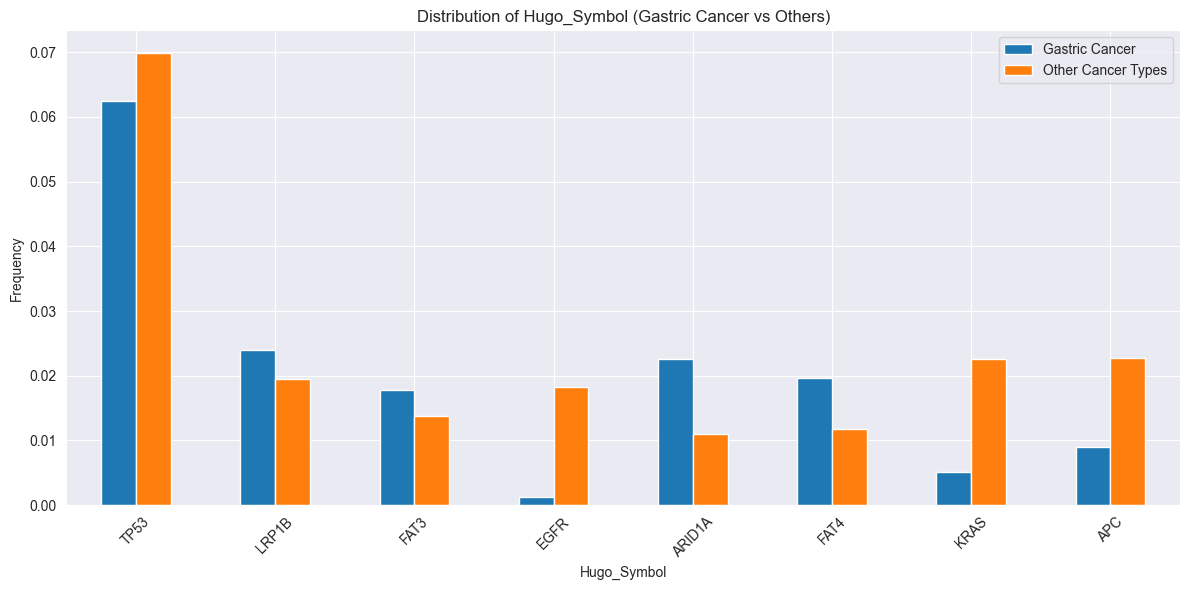


Feature: Sex
Top values by lift ratio:
          Cancer     Other      Lift
Sex                                 
Male    0.719411  0.670679  1.072661
Female  0.280589  0.329321  0.852022


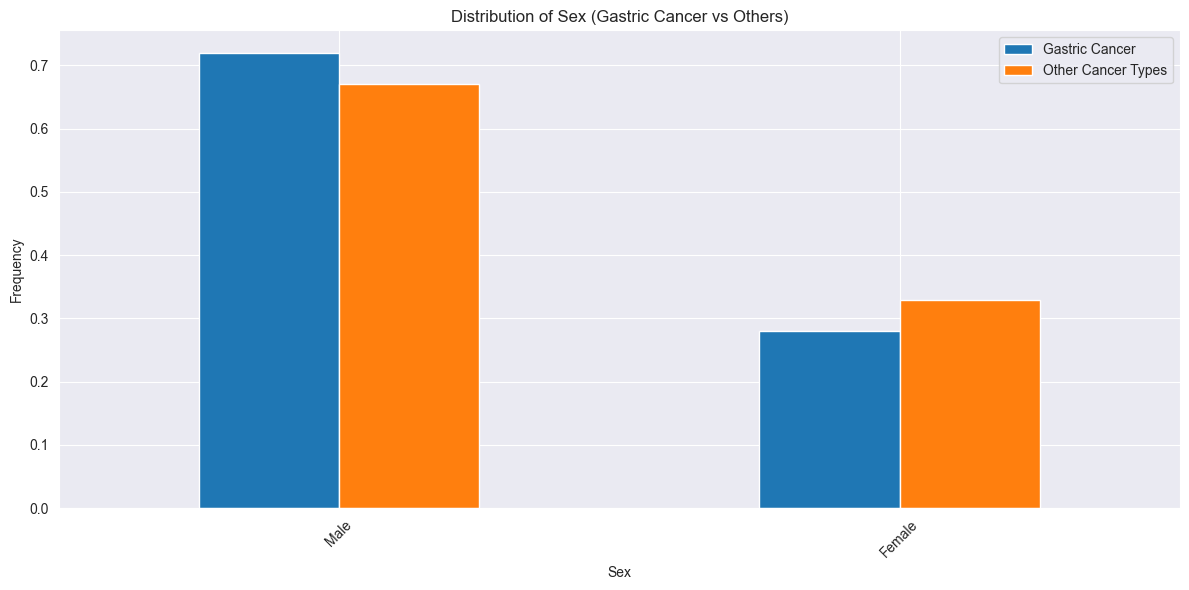


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
DEL           0.139409  0.097663  1.427444
INS           0.044292  0.035840  1.235829
SNP           0.816078  0.865963  0.942394


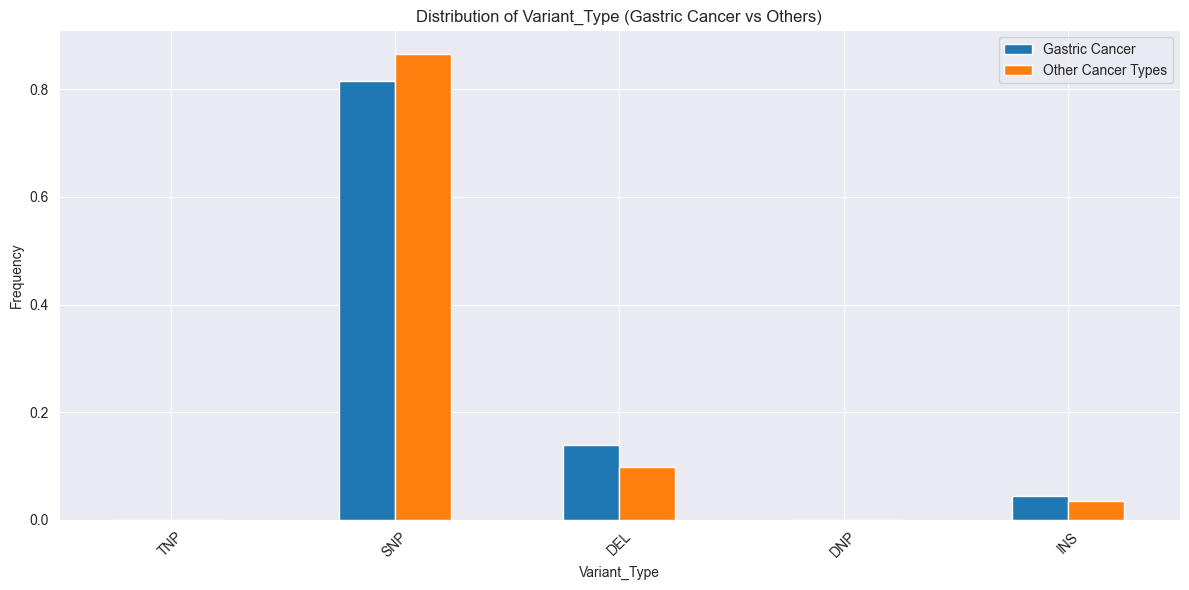


Feature: SNP_event
Top values by lift ratio:
                                Cancer     Other       Lift
SNP_event                                                  
CCCGCCGCCGCCAGCAGCCTGGGCAA>-  0.000332  0.000014  23.625955
TAAT>-                        0.000443  0.000028  15.750637
TGTC>-                        0.000221  0.000014  15.750637


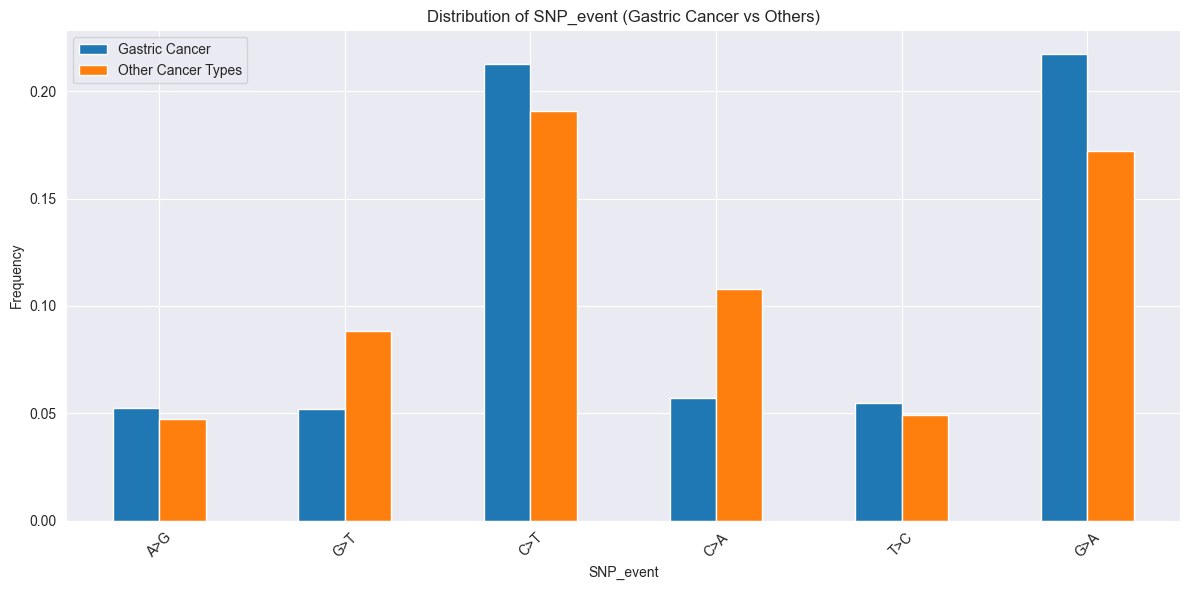


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.787689  1.269537
Nonsmoker        0.0  0.097593  0.000000
Smoker           0.0  0.114718  0.000000


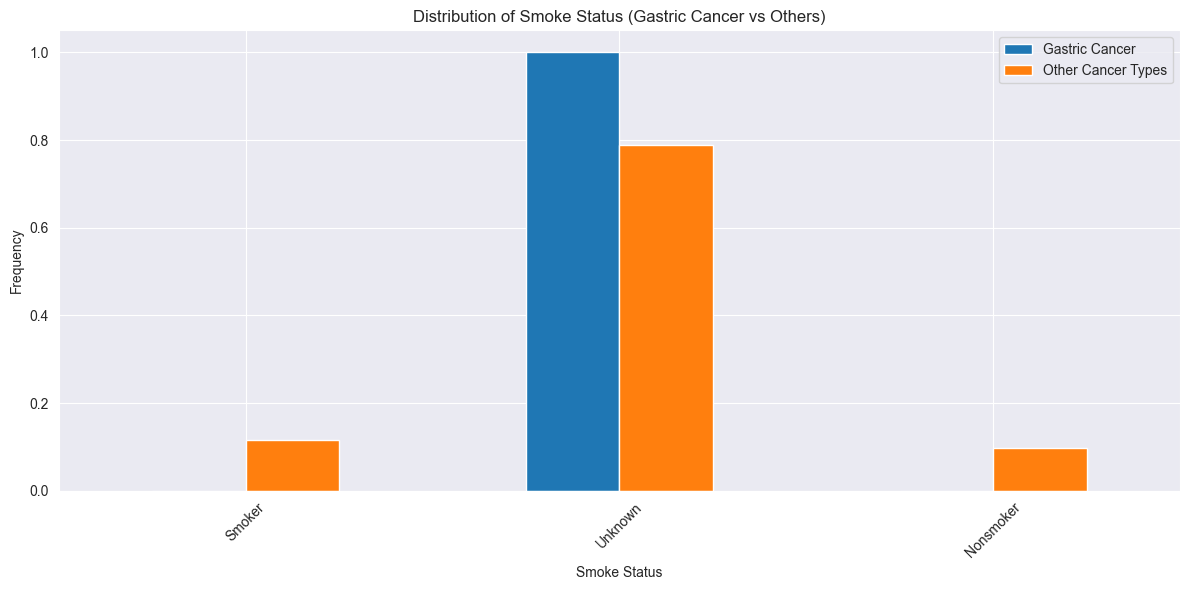

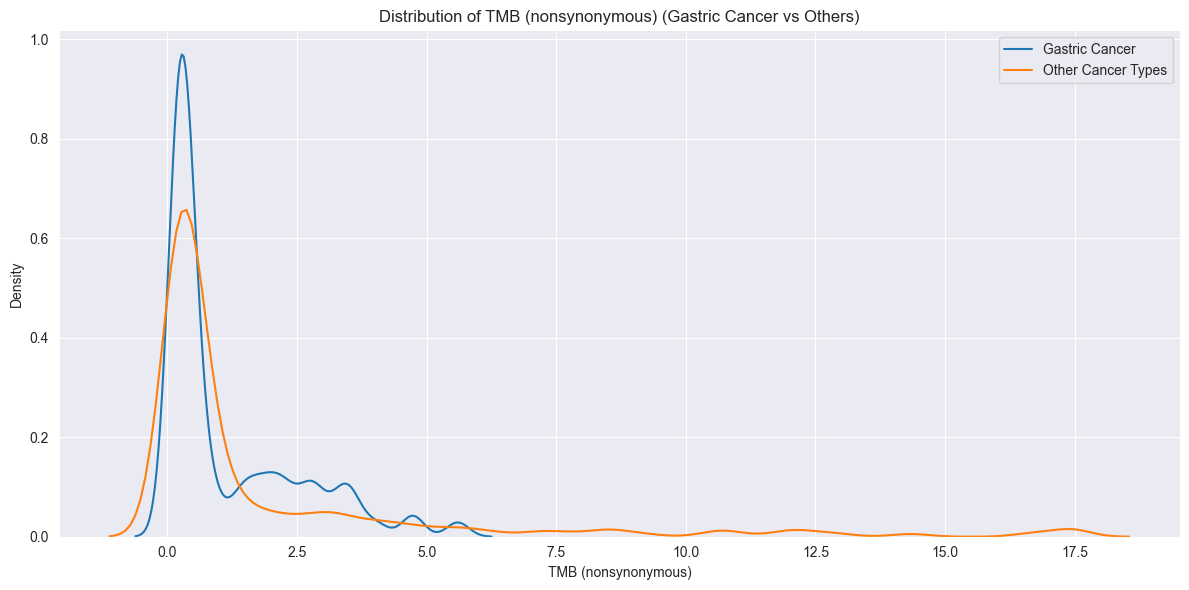


Feature: TMB (nonsynonymous)
Mean for Gastric Cancer: 1.1718
Mean for Other Cancer Types: 1.9155
Difference: -38.82%


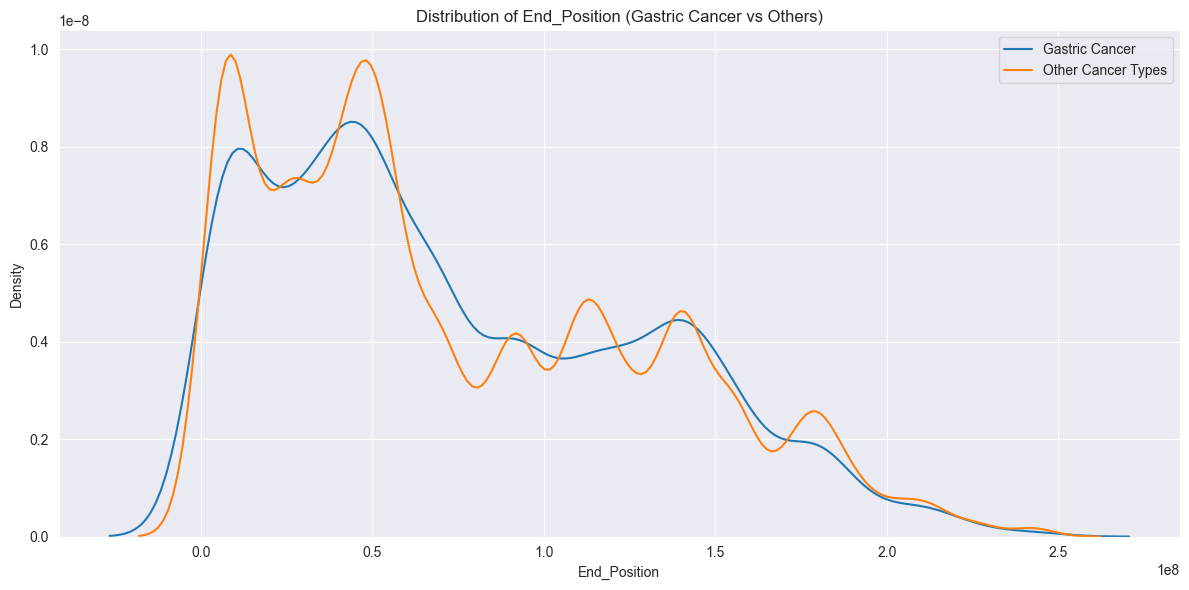


Feature: End_Position
Mean for Gastric Cancer: 74642319.5817
Mean for Other Cancer Types: 74791337.2383
Difference: -0.20%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Truncation          0.232422  0.217162  1.070268
Substitution/Indel  0.767578  0.782838  0.980507


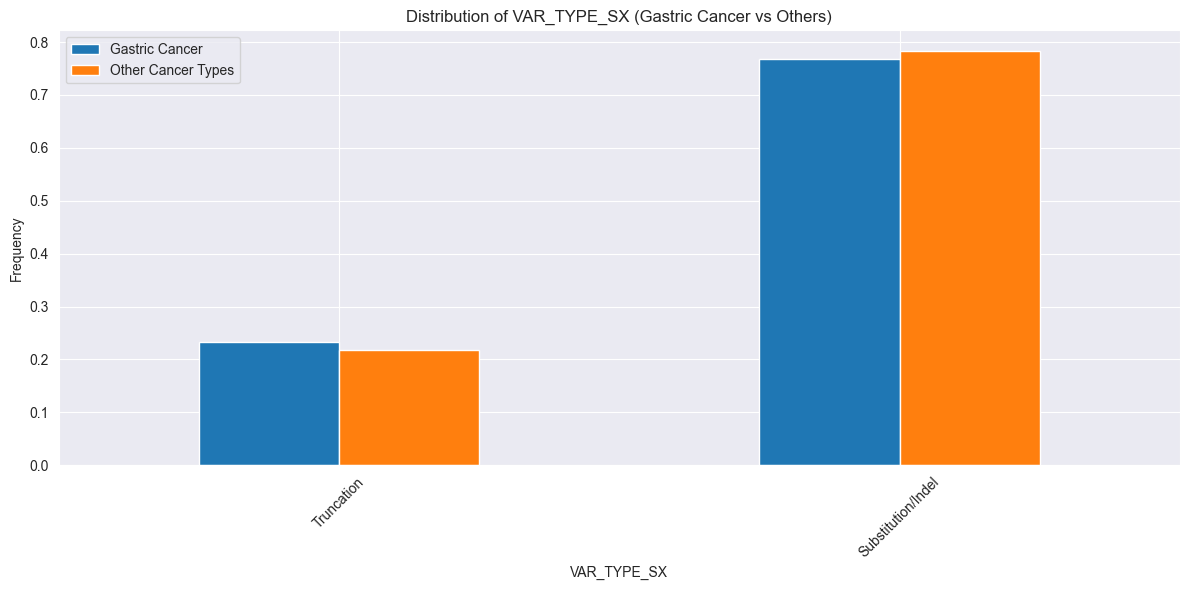

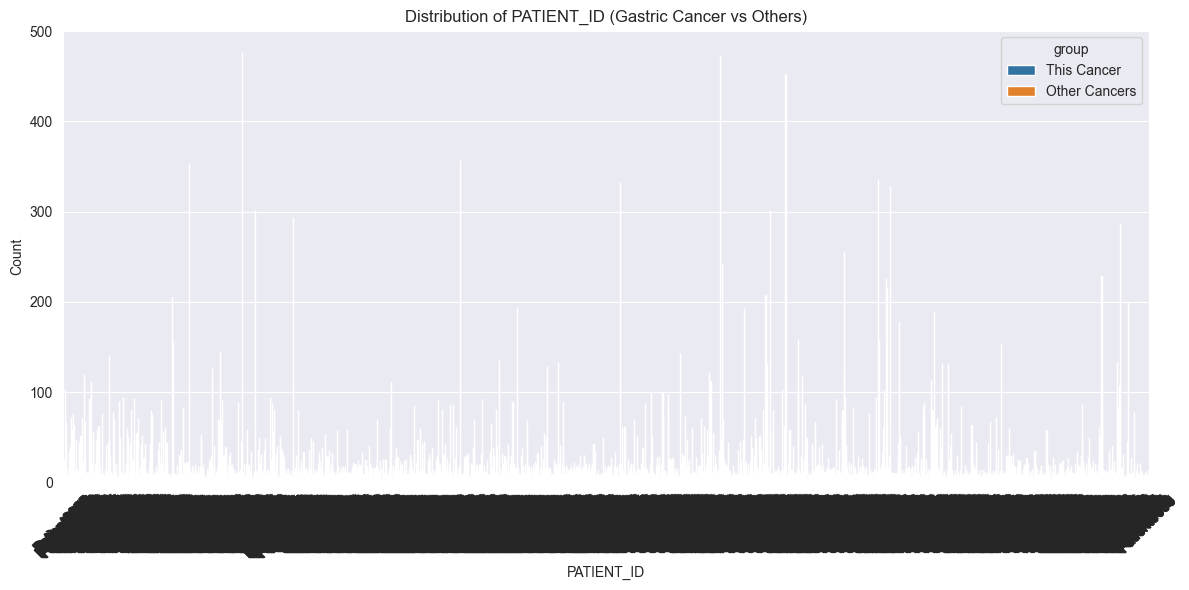

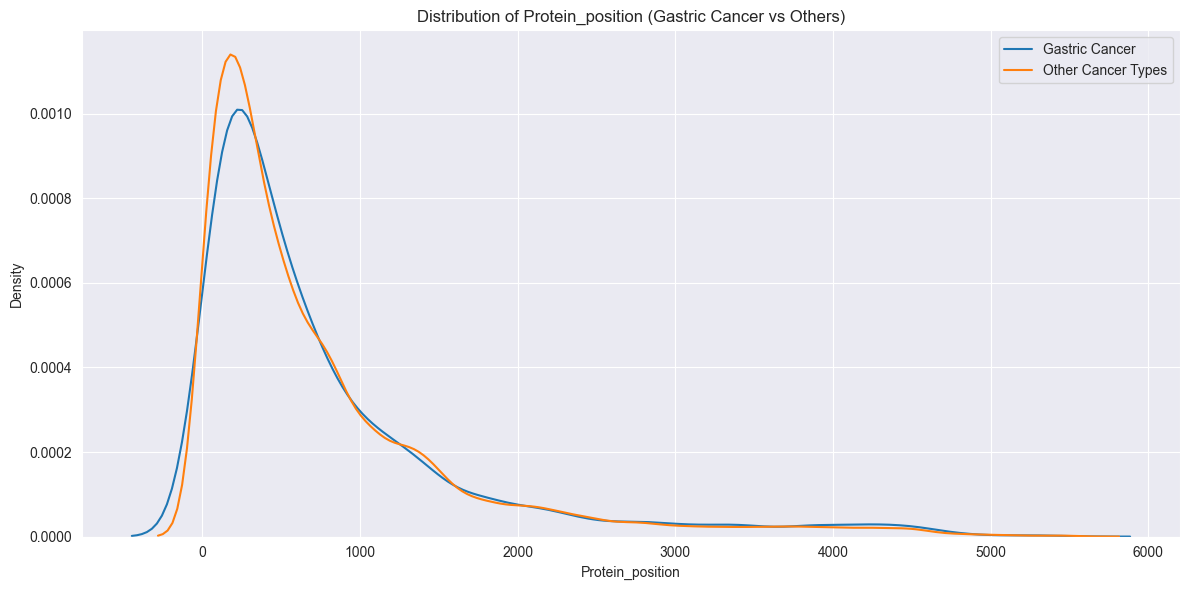


Feature: Protein_position
Mean for Gastric Cancer: 796.0532
Mean for Other Cancer Types: 762.9745
Difference: 4.34%

Analyzing categorical feature interactions...

Top feature combinations for Gastric Cancer:
        Feature1         Value1      Feature2         Value2  Cancer_Count  \
6    Hugo_Symbol          GATA6     SNP_event            A>T            10   
7    Hugo_Symbol           CDH1     SNP_event            T>G             9   
20  Variant_Type            DEL     SNP_event  GCGGCCCCTCC>-             5   
8    Hugo_Symbol          SMAD3     SNP_event            C>-             5   
26     SNP_event  GCGGCCCCTCC>-  Smoke Status        Unknown             5   

    Cancer_Pct  Other_Pct        Lift  
6     0.110730      0.001  110.729709  
7     0.099657      0.001   99.656738  
20    0.055365      0.001   55.364854  
8     0.055365      0.001   55.364854  
26    0.055365      0.001   55.364854  


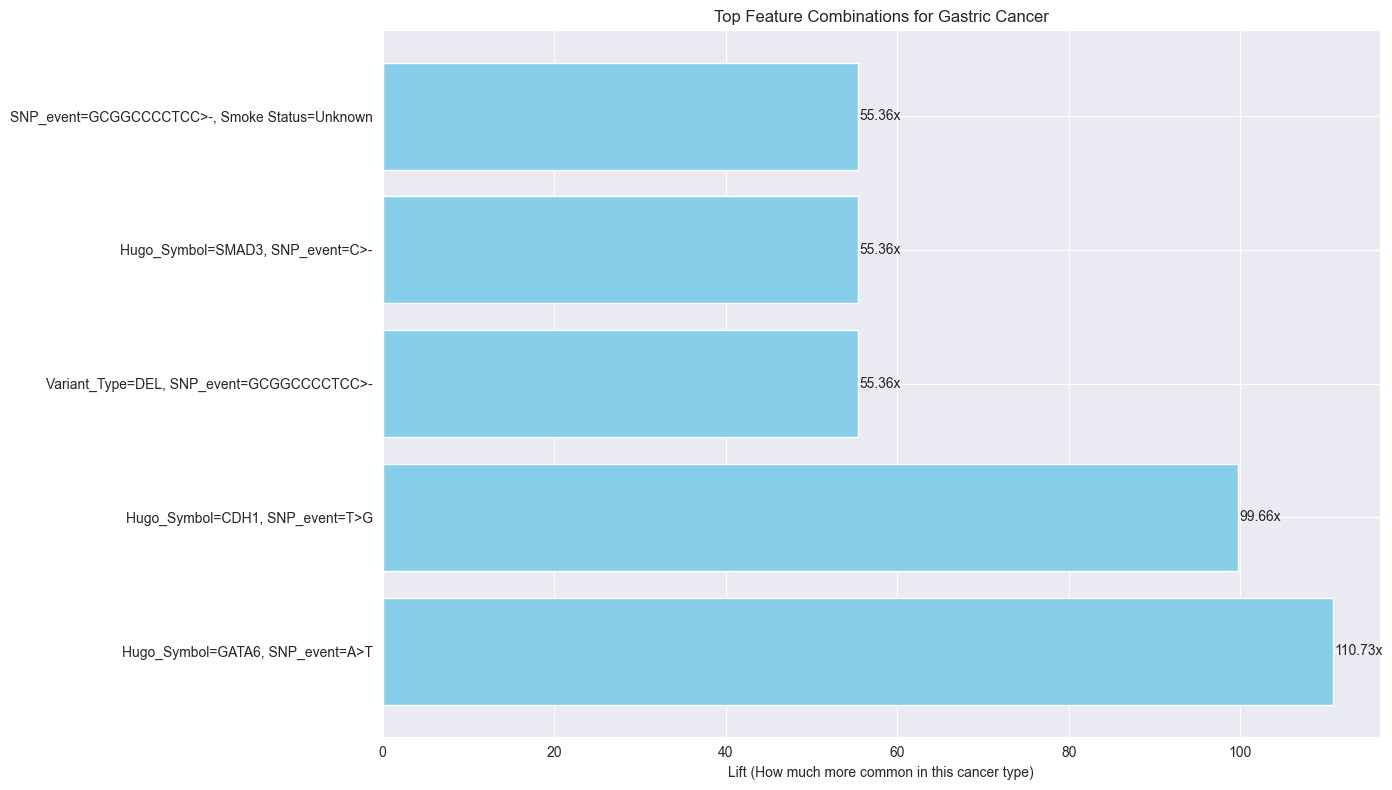


===== ANALYZING CANCER TYPE: Pancreatic Cancer =====
Number of samples: 2656

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


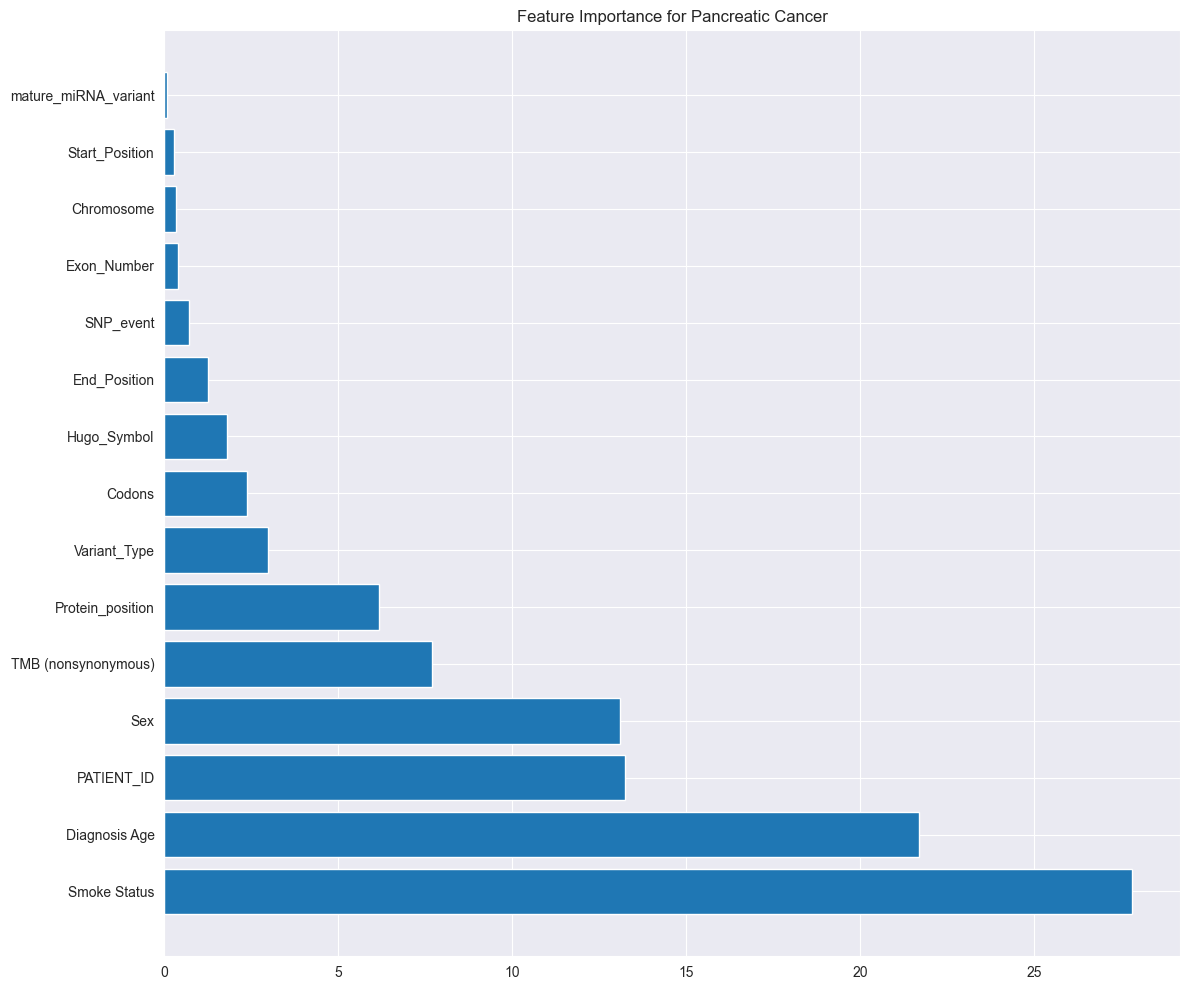


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
KRAS         0.162651  0.015717  10.348878
MEF2B        0.000377  0.000039   9.726029
CDKN2A       0.042922  0.005742   7.474836


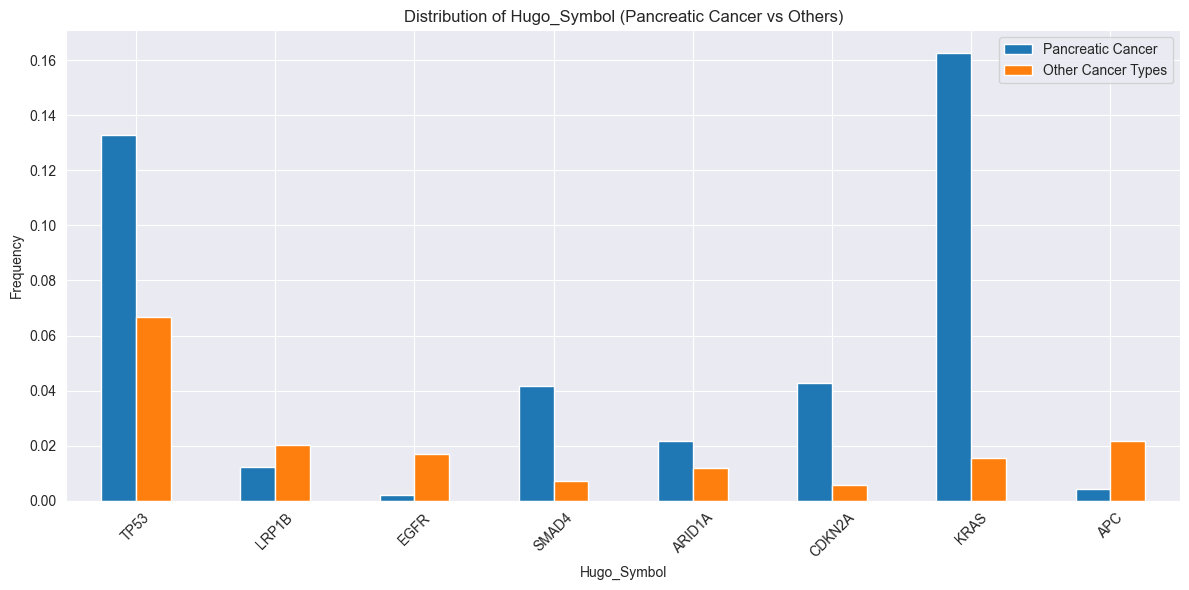


Feature: Sex
Top values by lift ratio:
          Cancer   Other      Lift
Sex                               
Female  0.400602  0.3212  1.247207
Male    0.599398  0.6788  0.883025


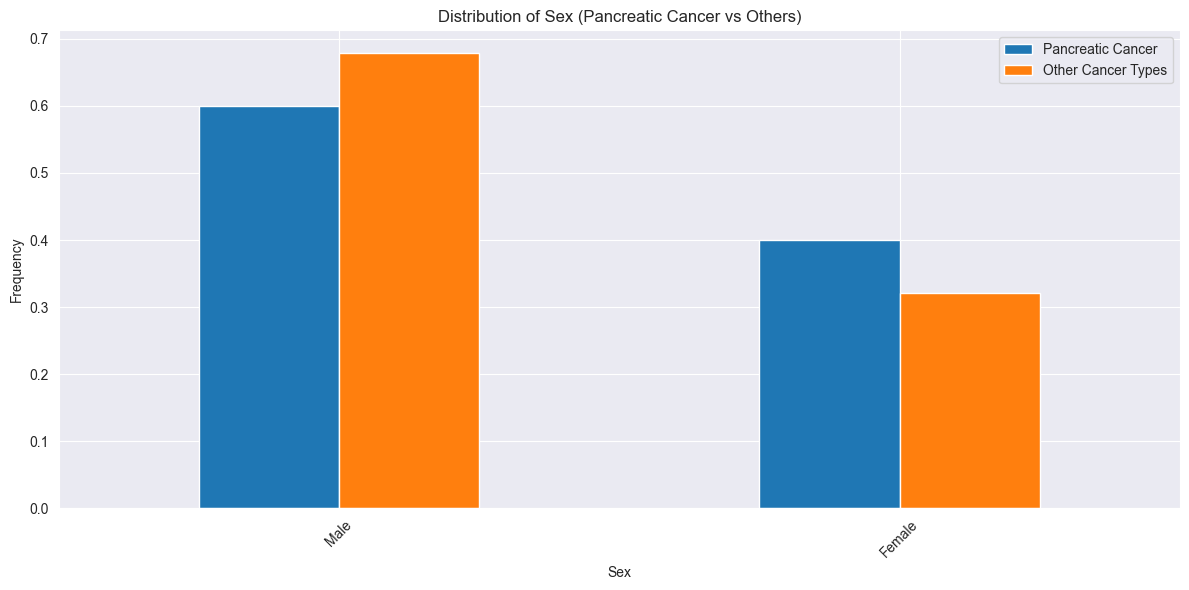


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other       Lift
Variant_Type                               
TNP           0.000377  0.000013  29.178087
DNP           0.000753  0.000465   1.621005
INS           0.050452  0.036324   1.388939


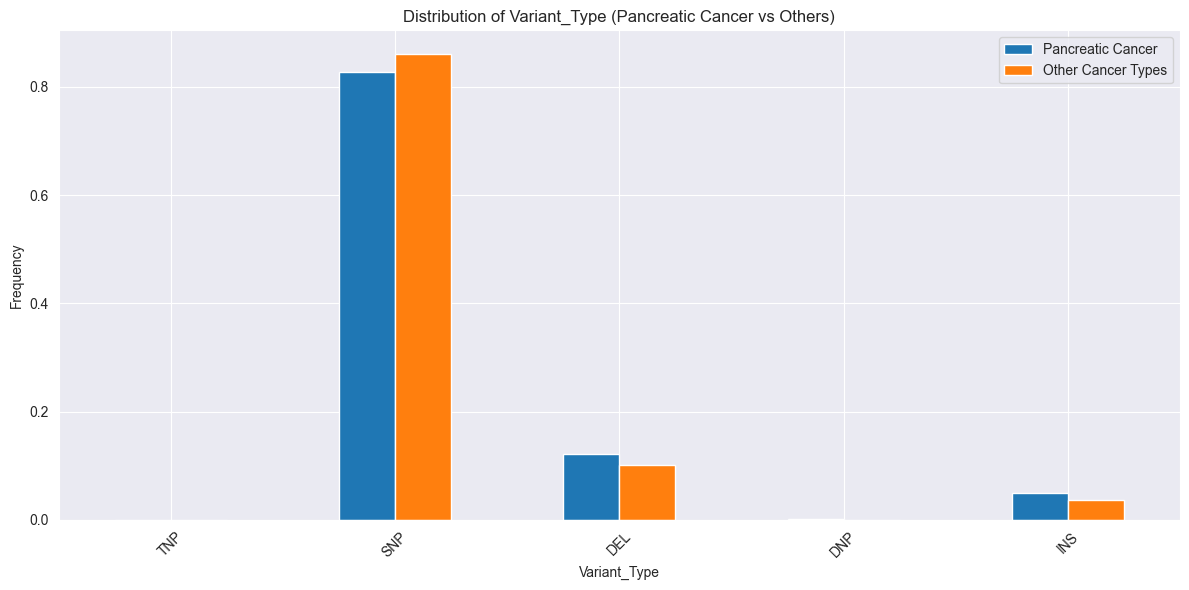


Feature: SNP_event
Top values by lift ratio:
                     Cancer     Other       Lift
SNP_event                                       
TAGGTGCTGTCACAT>-  0.001883  0.000026  72.945218
->GGCCGT           0.000377  0.000013  29.178087
->CTC              0.000377  0.000013  29.178087


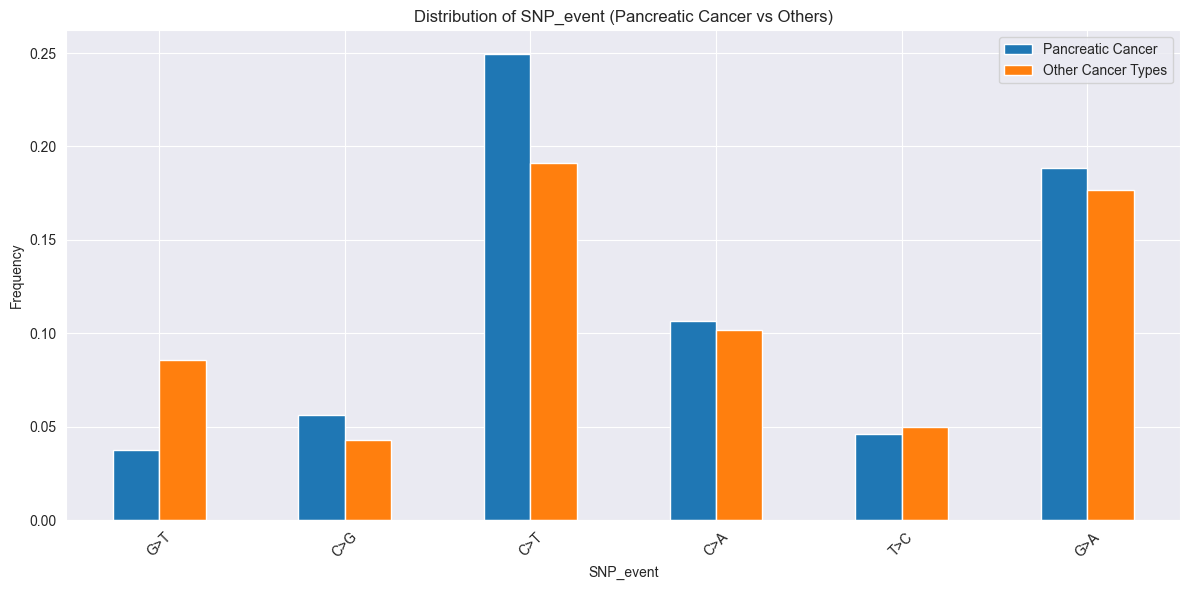


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.805154  1.241999
Nonsmoker        0.0  0.089565  0.000000
Smoker           0.0  0.105281  0.000000


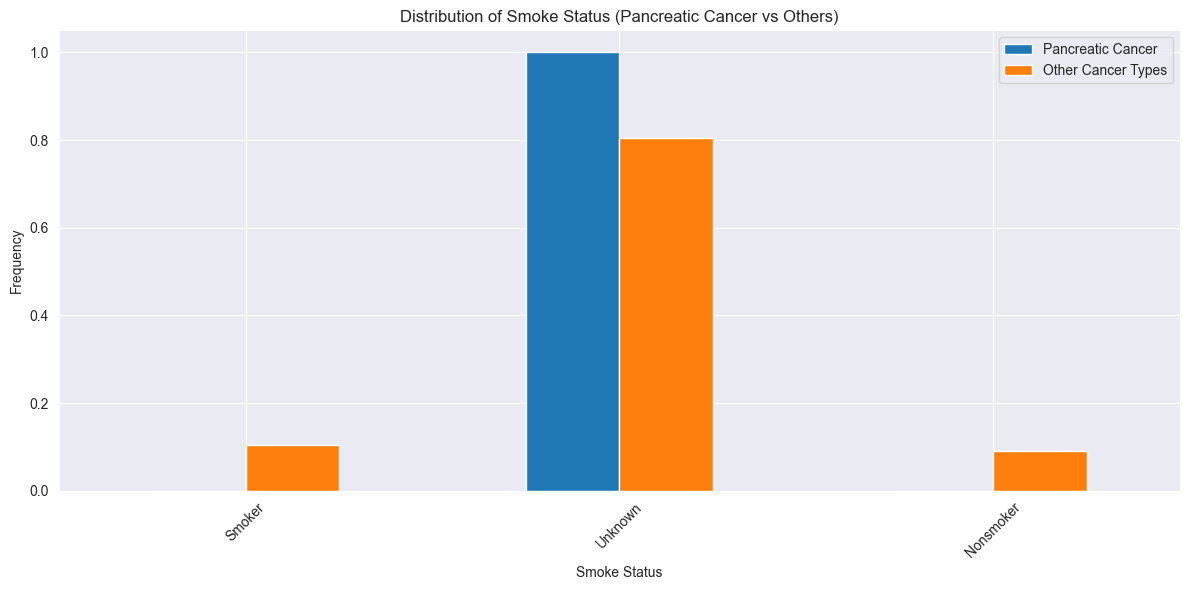

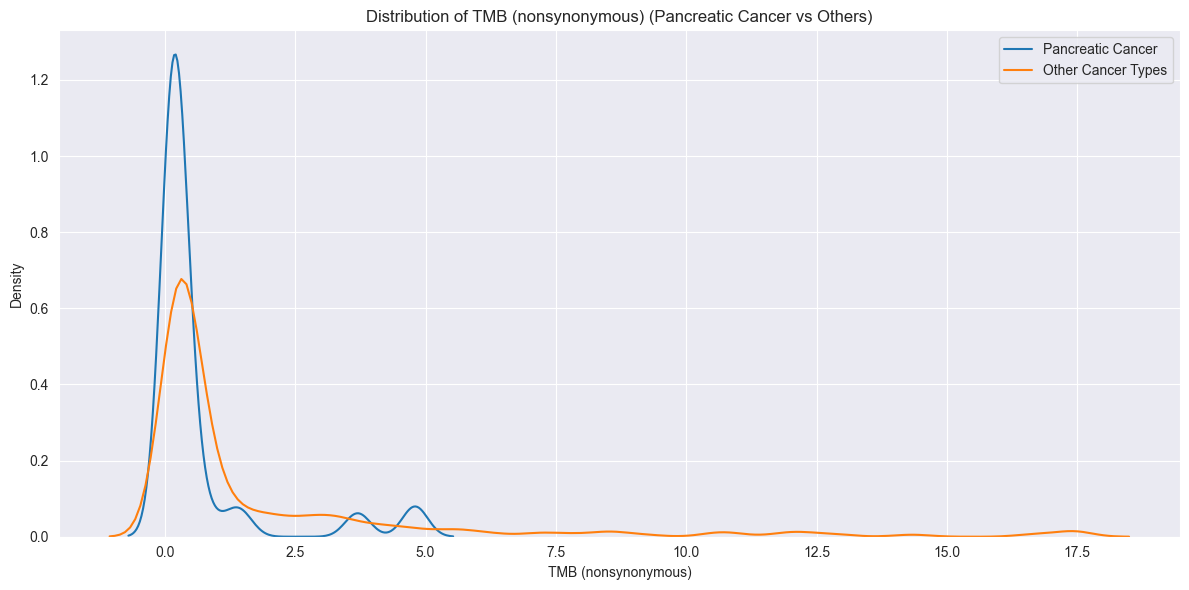


Feature: TMB (nonsynonymous)
Mean for Pancreatic Cancer: 0.6360
Mean for Other Cancer Types: 1.8727
Difference: -66.04%


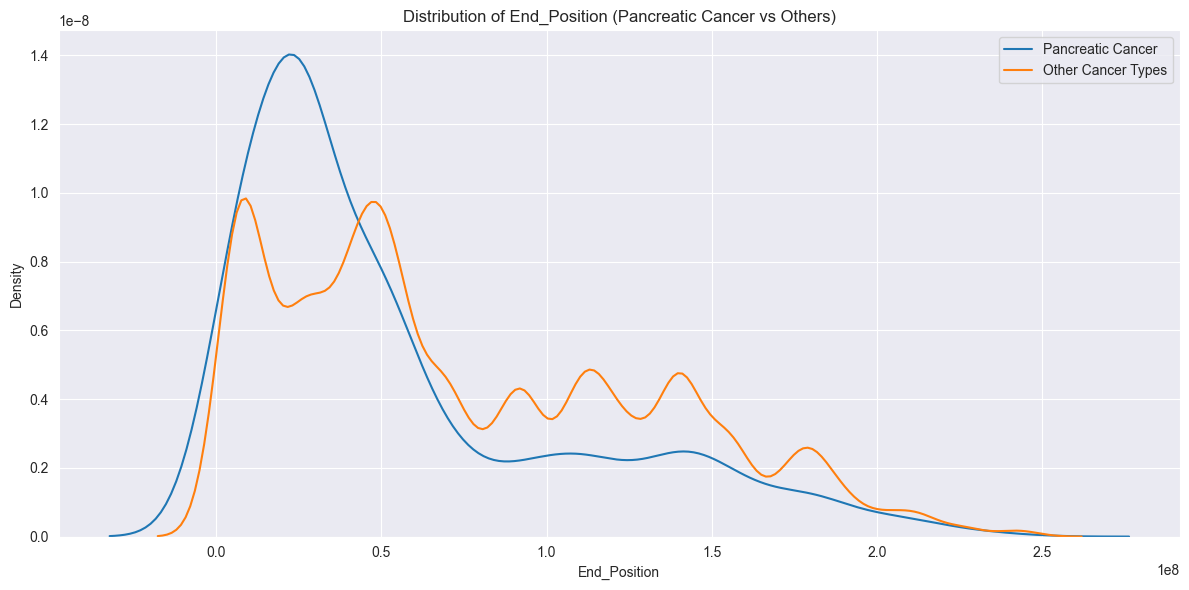


Feature: End_Position
Mean for Pancreatic Cancer: 56117140.7760
Mean for Other Cancer Types: 75413979.2418
Difference: -25.59%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Truncation          0.243976  0.218021  1.119046
Substitution/Indel  0.756024  0.781979  0.966809


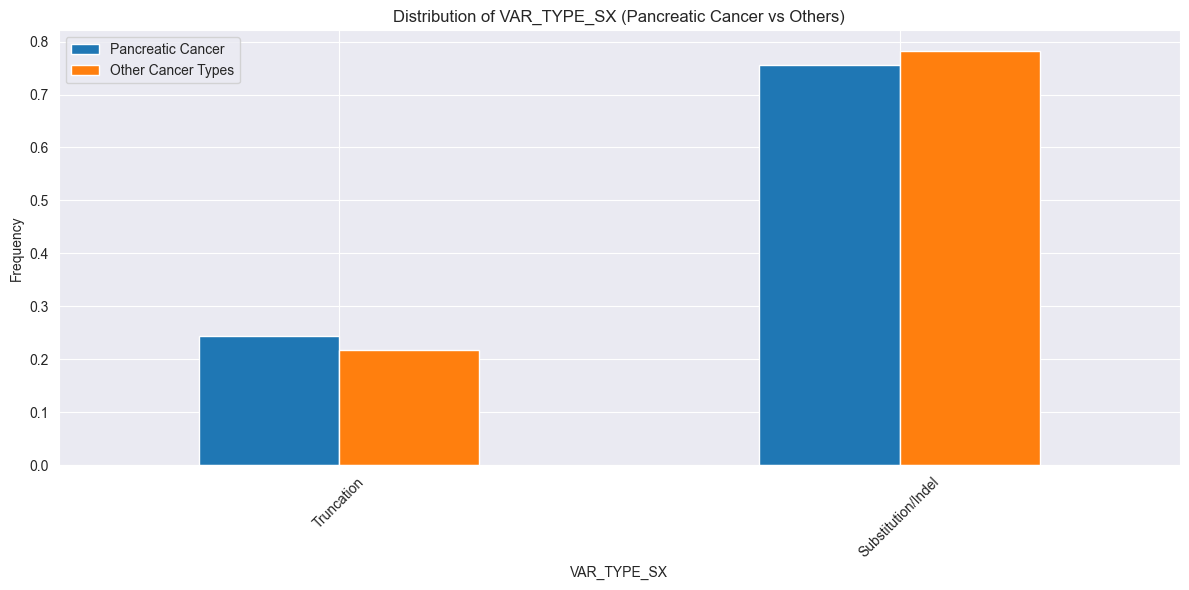

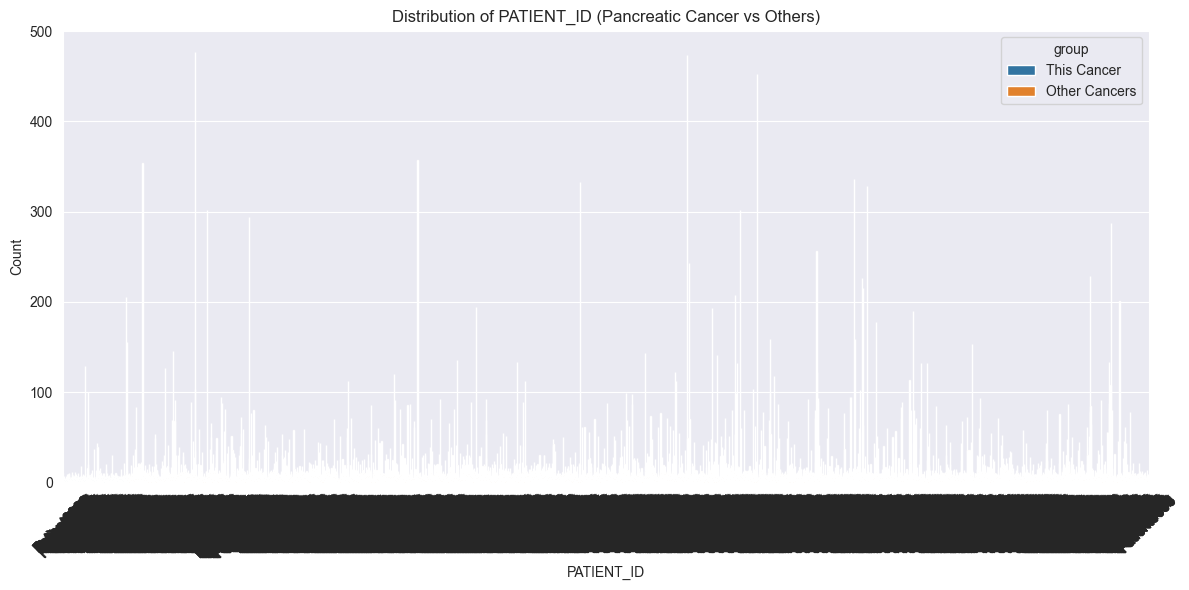

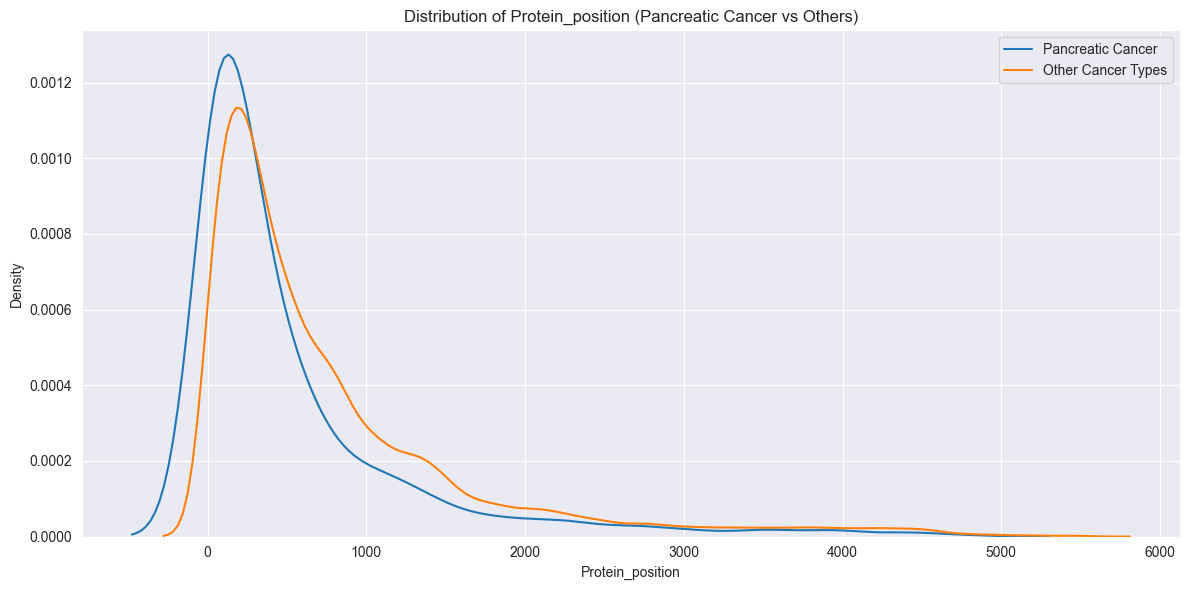


Feature: Protein_position
Mean for Pancreatic Cancer: 535.2169
Mean for Other Cancer Types: 774.6350
Difference: -30.91%

Analyzing categorical feature interactions...

Top feature combinations for Pancreatic Cancer:
        Feature1             Value1      Feature2             Value2  \
20  Variant_Type                DEL     SNP_event  TAGGTGCTGTCACAT>-   
26     SNP_event  TAGGTGCTGTCACAT>-  Smoke Status            Unknown   
6    Hugo_Symbol               BRAF     SNP_event  TAGGTGCTGTCACAT>-   
7    Hugo_Symbol               DDR2     SNP_event                C>G   
15           Sex               Male     SNP_event             GCCA>-   

    Cancer_Count  Cancer_Pct  Other_Pct       Lift  
20             5    0.188253   0.002581  72.945218  
26             5    0.188253   0.002581  72.945218  
6              5    0.188253   0.002581  72.945218  
7              6    0.225904   0.003871  58.356175  
15             7    0.263554   0.007742  34.041102  


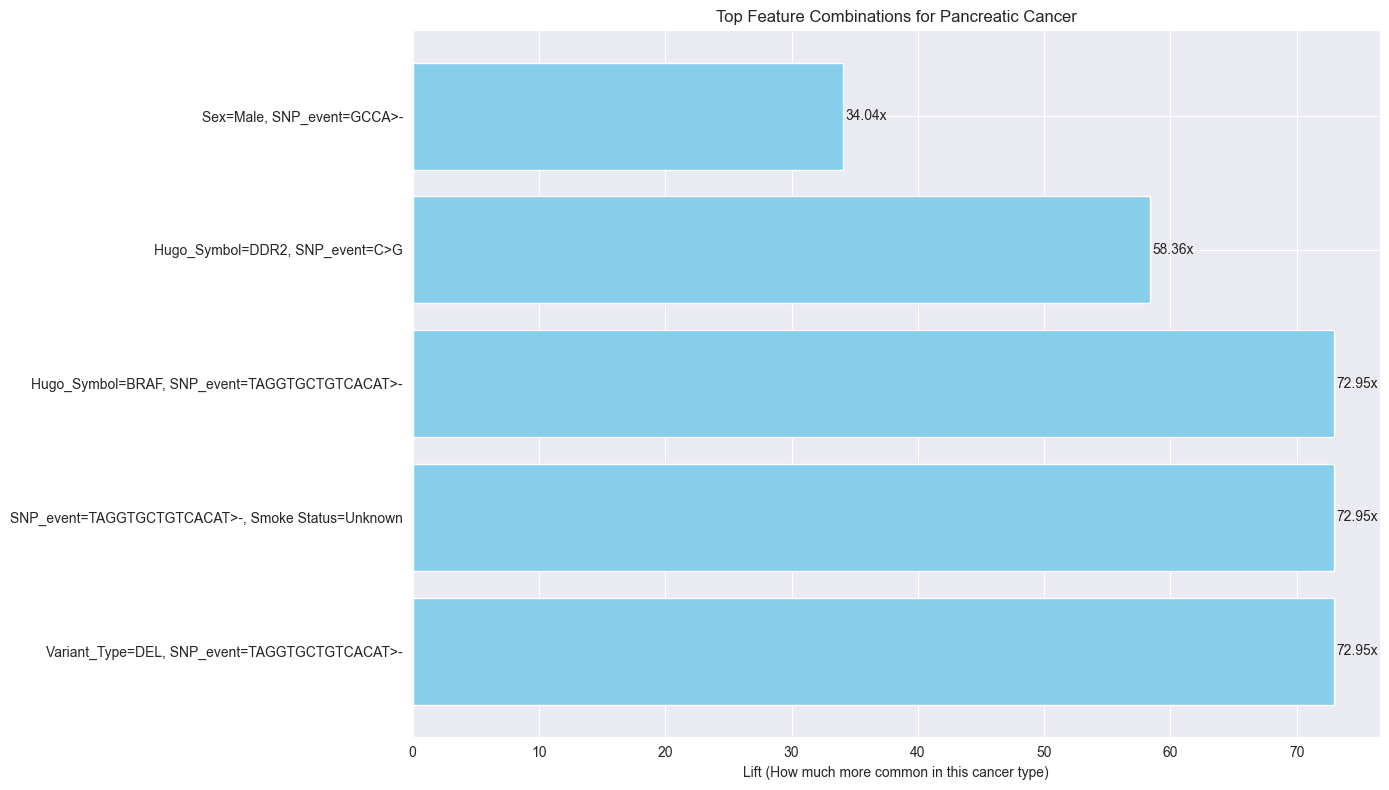


===== ANALYZING CANCER TYPE: Breast Carcinoma =====
Number of samples: 2065

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


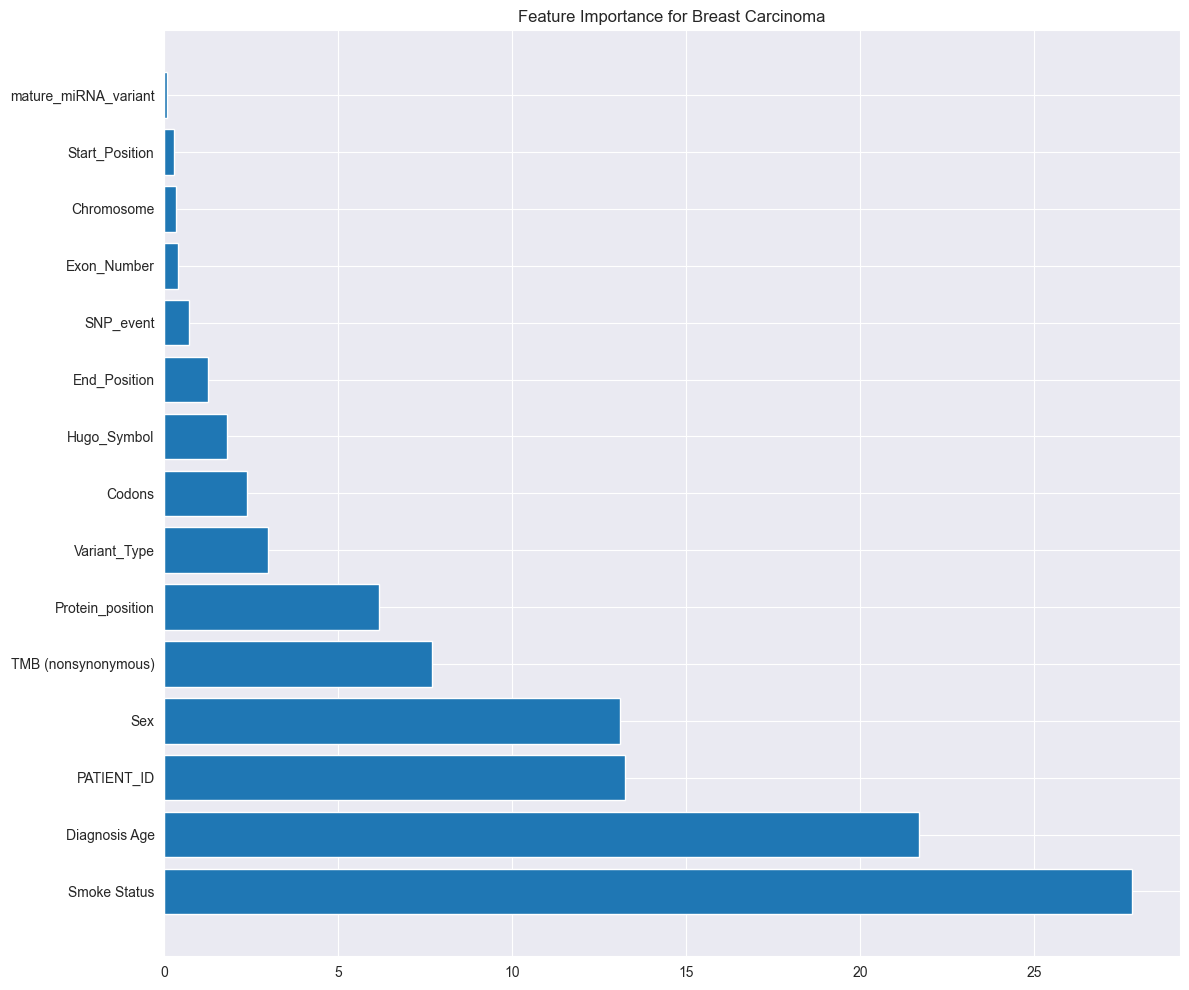


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
GATA3        0.023245  0.001345  17.286863
AKT1         0.008717  0.000845  10.313185
MAP3K1       0.018402  0.002267   8.118477


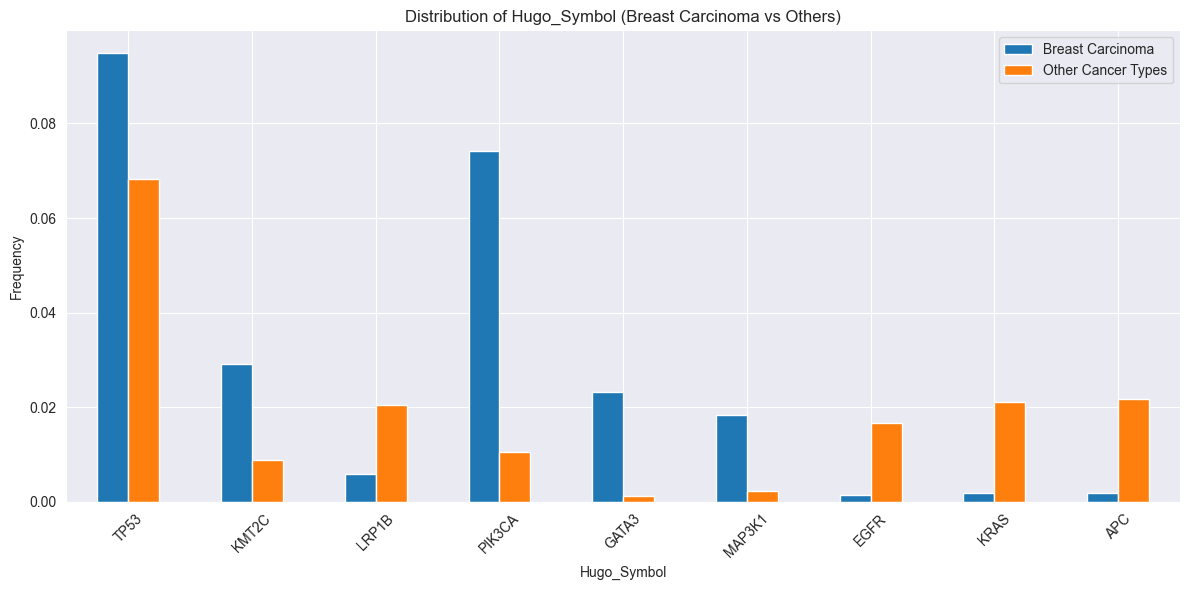


Feature: Sex
Top values by lift ratio:
          Cancer     Other      Lift
Sex                                 
Female  0.995157  0.306078  3.251322
Male    0.004843  0.693922  0.006979


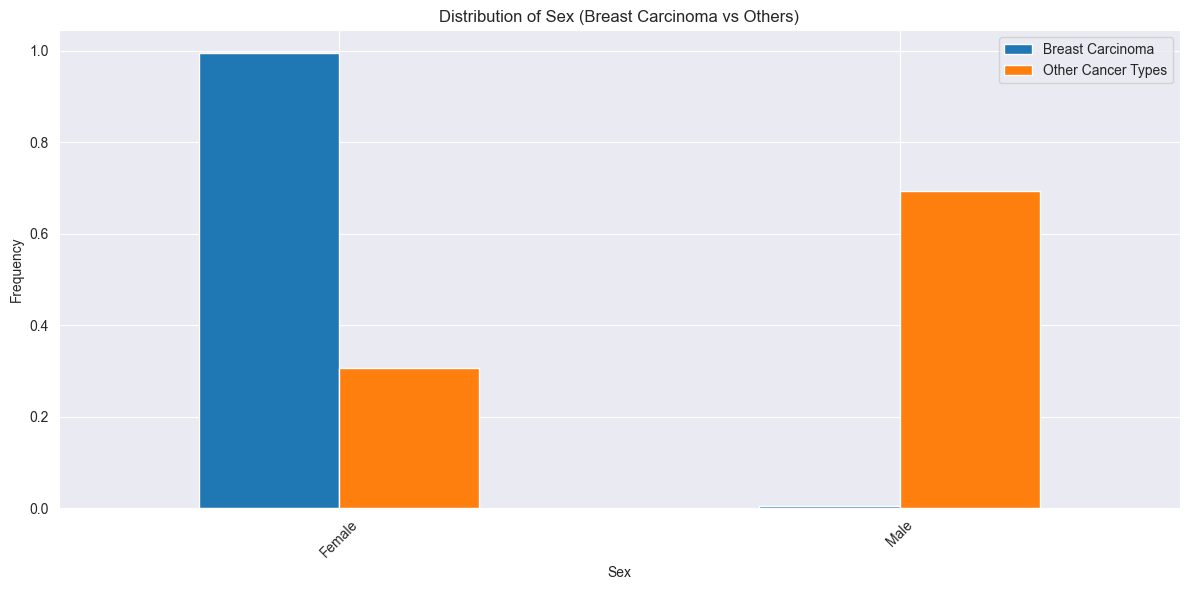


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
INS           0.049395  0.036459  1.354805
SNP           0.857143  0.860427  0.996183
DEL           0.093462  0.102602  0.910921


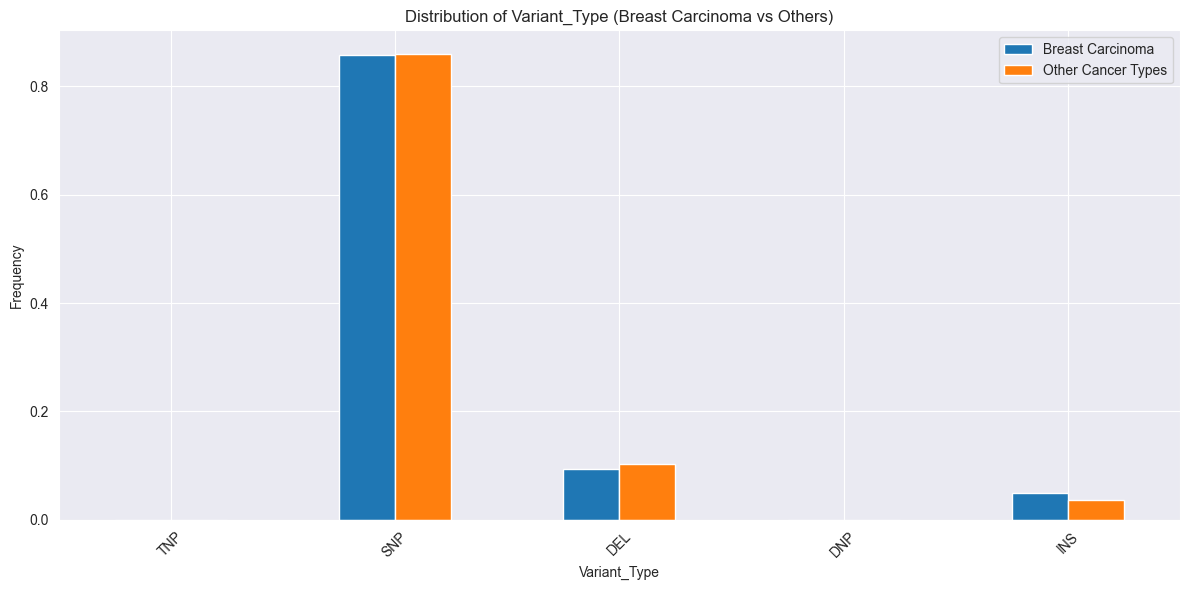


Feature: SNP_event
Top values by lift ratio:
             Cancer     Other       Lift
SNP_event                               
AGT>-      0.001453  0.000026  56.722518
->GGAT     0.000484  0.000013  37.815012
->CTT      0.000484  0.000013  37.815012


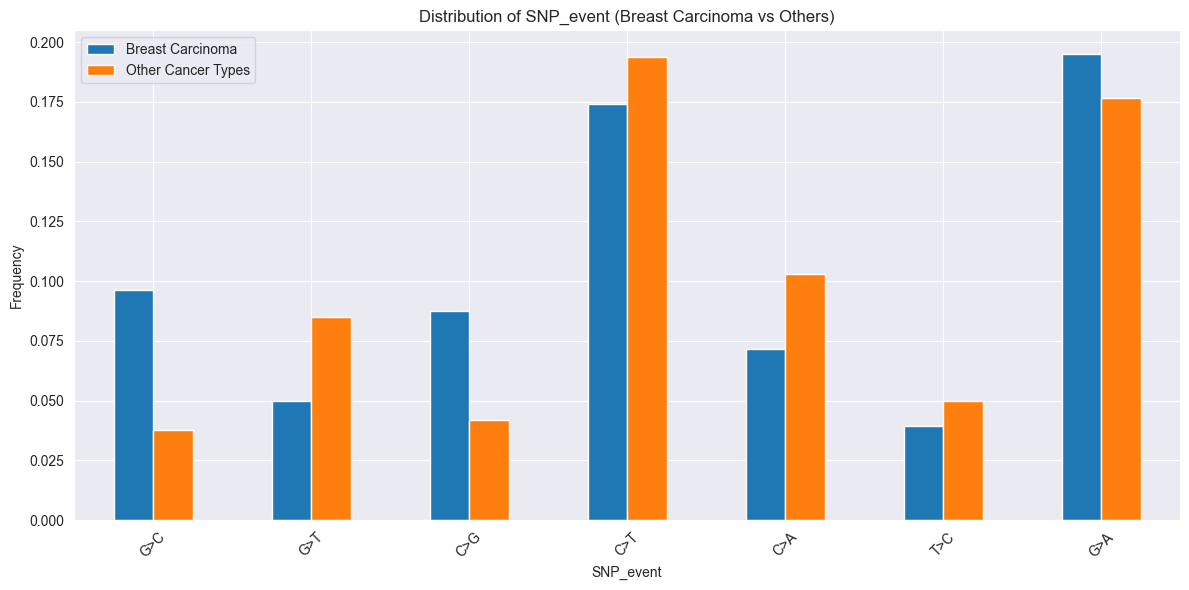


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.806628  1.239728
Nonsmoker        0.0  0.088887  0.000000
Smoker           0.0  0.104485  0.000000


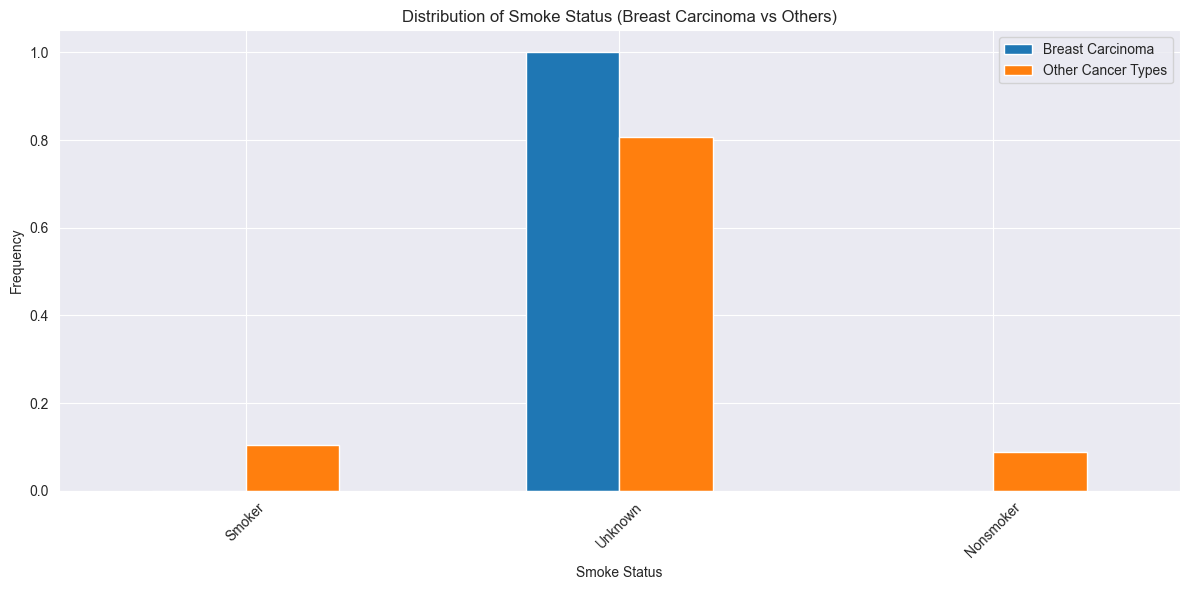

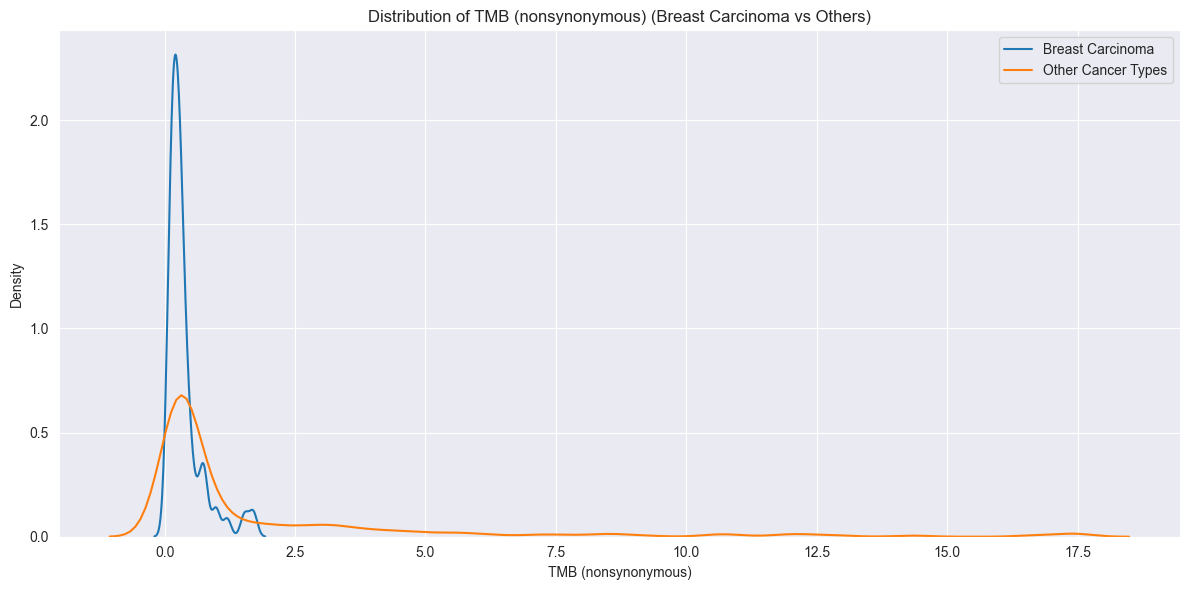


Feature: TMB (nonsynonymous)
Mean for Breast Carcinoma: 0.3781
Mean for Other Cancer Types: 1.8702
Difference: -79.78%


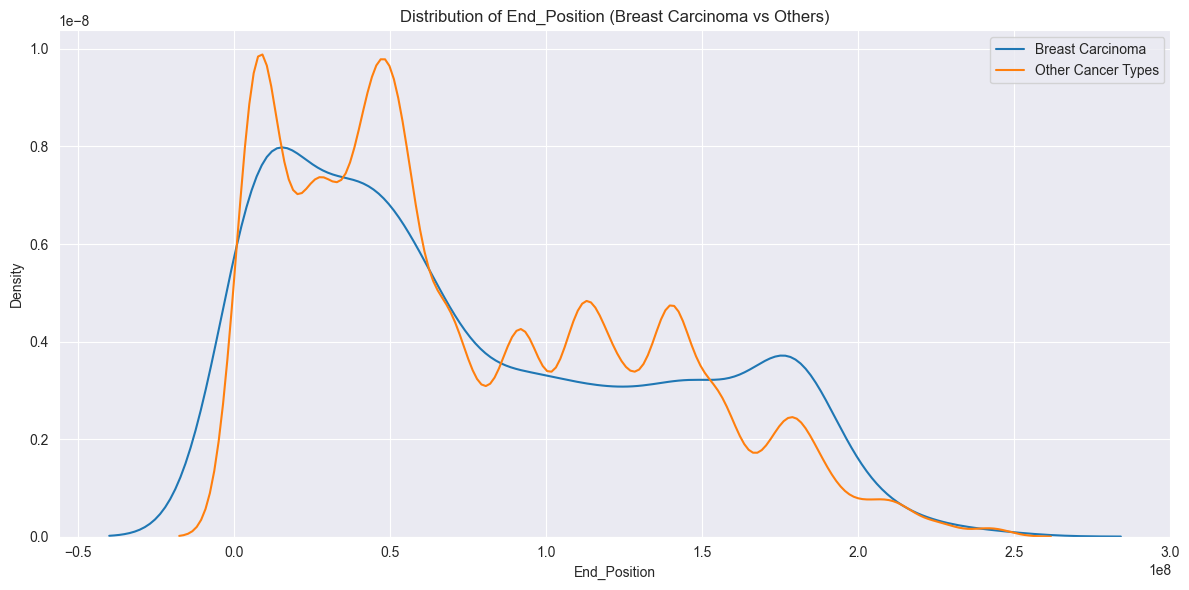


Feature: End_Position
Mean for Breast Carcinoma: 77445541.5022
Mean for Other Cancer Types: 74703913.9433
Difference: 3.67%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                     Cancer     Other      Lift
VAR_TYPE_SX                                    
Truncation          0.22276  0.218779  1.018199
Substitution/Indel  0.77724  0.781221  0.994904


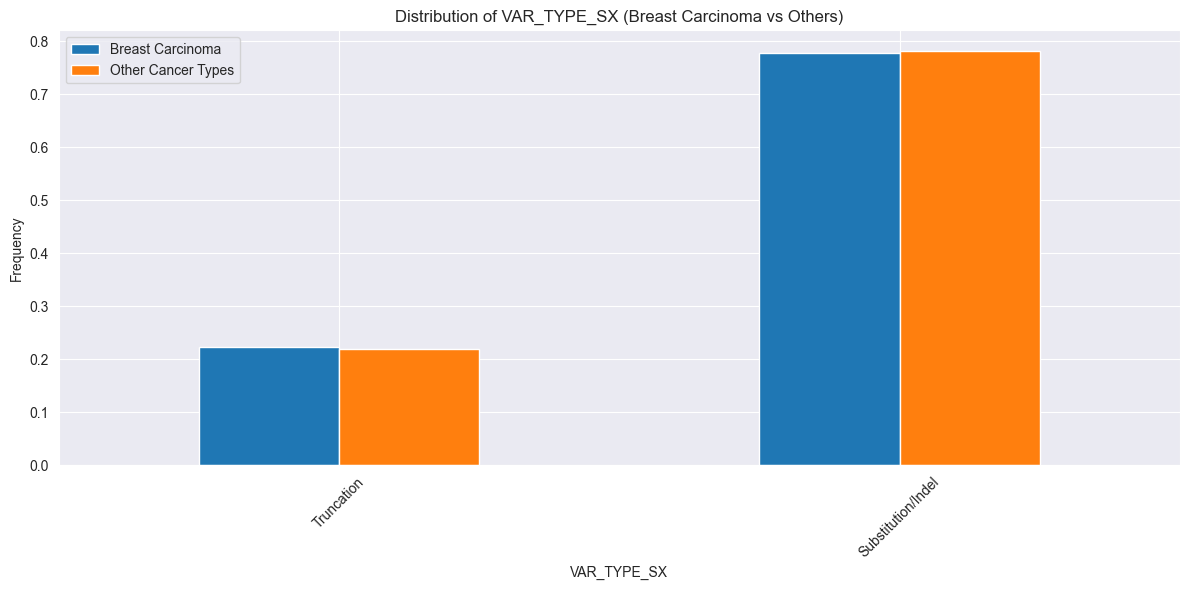

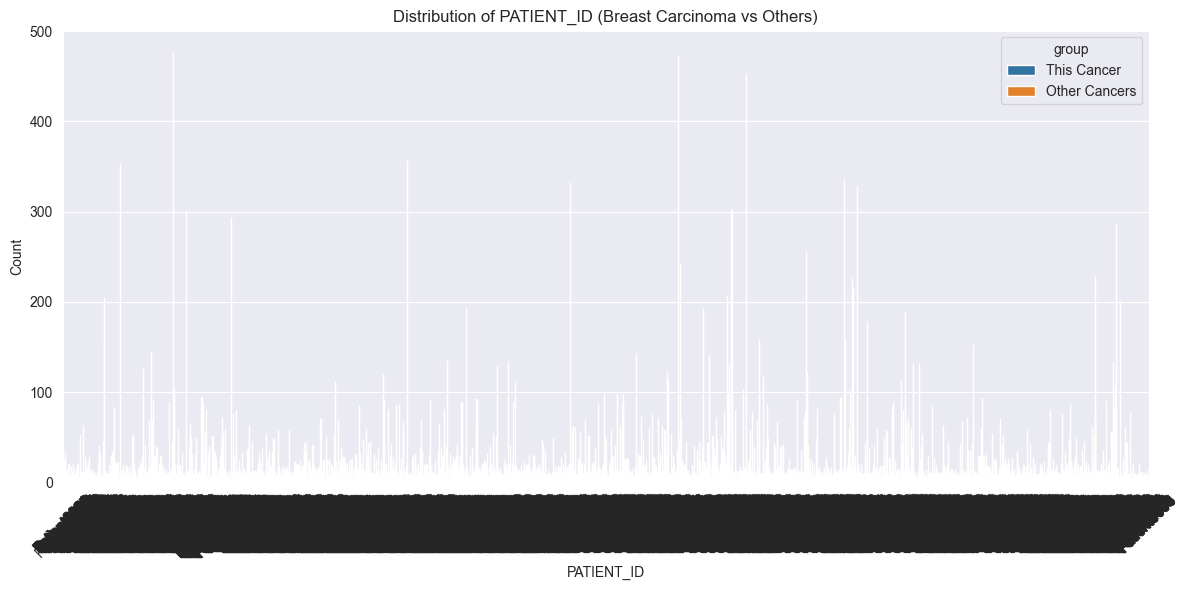

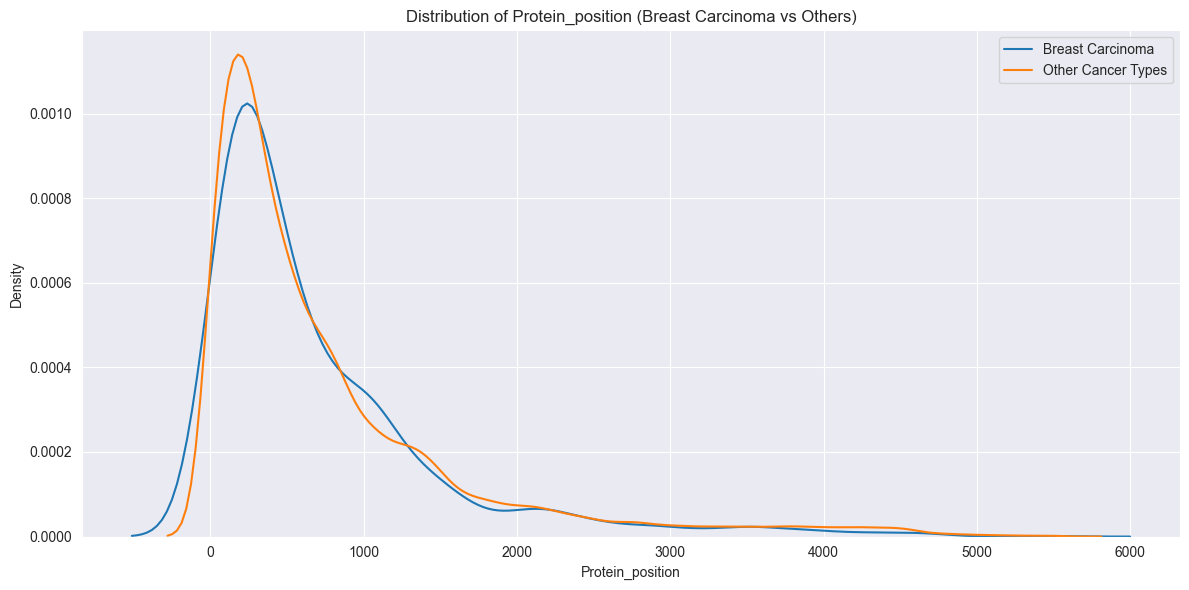


Feature: Protein_position
Mean for Breast Carcinoma: 703.5264
Mean for Other Cancer Types: 768.3721
Difference: -8.44%

Analyzing categorical feature interactions...

Top feature combinations for Breast Carcinoma:
      Feature1  Value1      Feature2  Value2  Cancer_Count  Cancer_Pct  \
6  Hugo_Symbol   GATA3     SNP_event     ->G            10    0.484262   
3  Hugo_Symbol   GATA3  Variant_Type     INS            20    0.968523   
7  Hugo_Symbol  MAP3K1     SNP_event    AG>-             5    0.242131   
8  Hugo_Symbol  MAP3K1     SNP_event     ->T             5    0.242131   
0  Hugo_Symbol   GATA3           Sex  Female            48    2.324455   

   Other_Pct        Lift  
6   0.001000  484.261501  
3   0.002561  378.150121  
7   0.001000  242.130751  
8   0.001000  242.130751  
0   0.026893   86.434313  


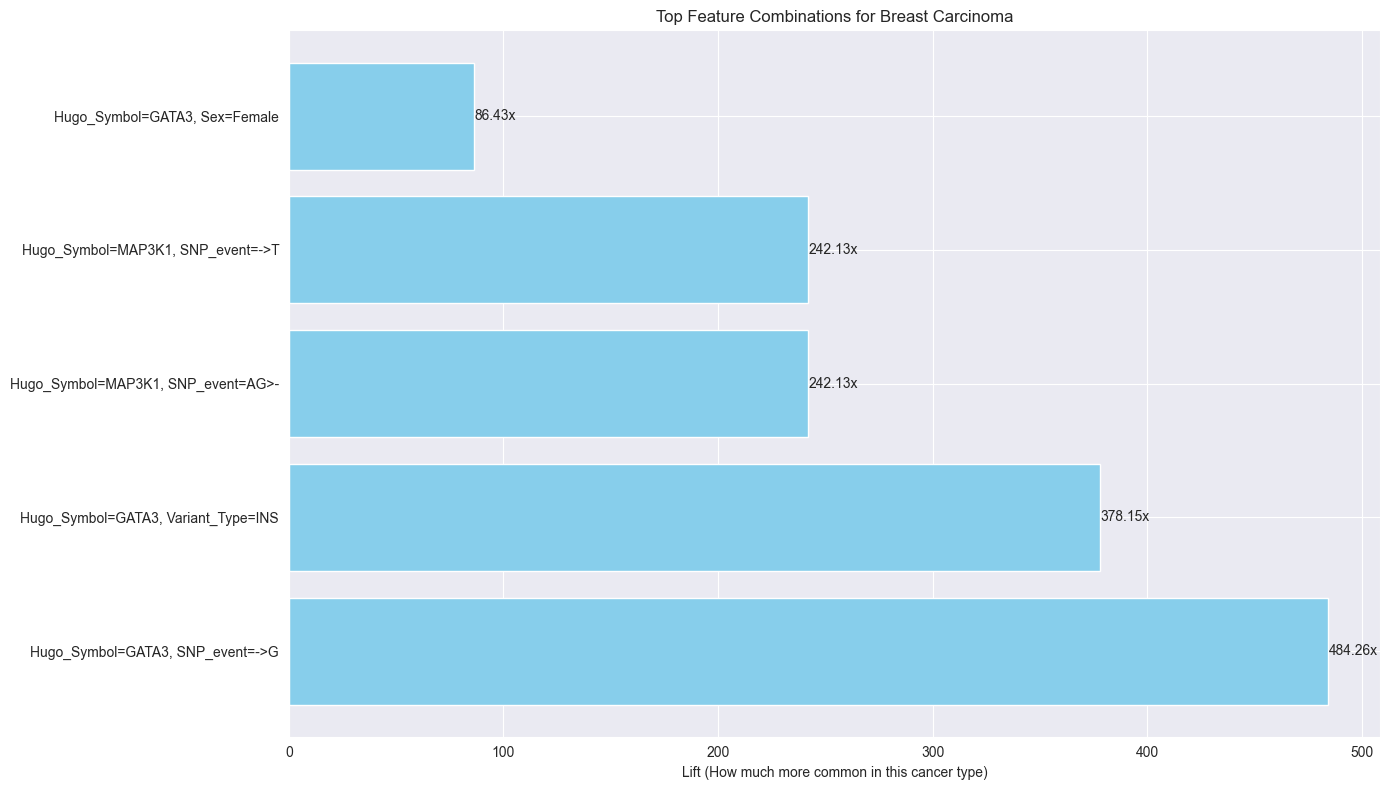


===== ANALYZING CANCER TYPE: Extrahepatic Cholangiocarcinoma =====
Number of samples: 2524

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


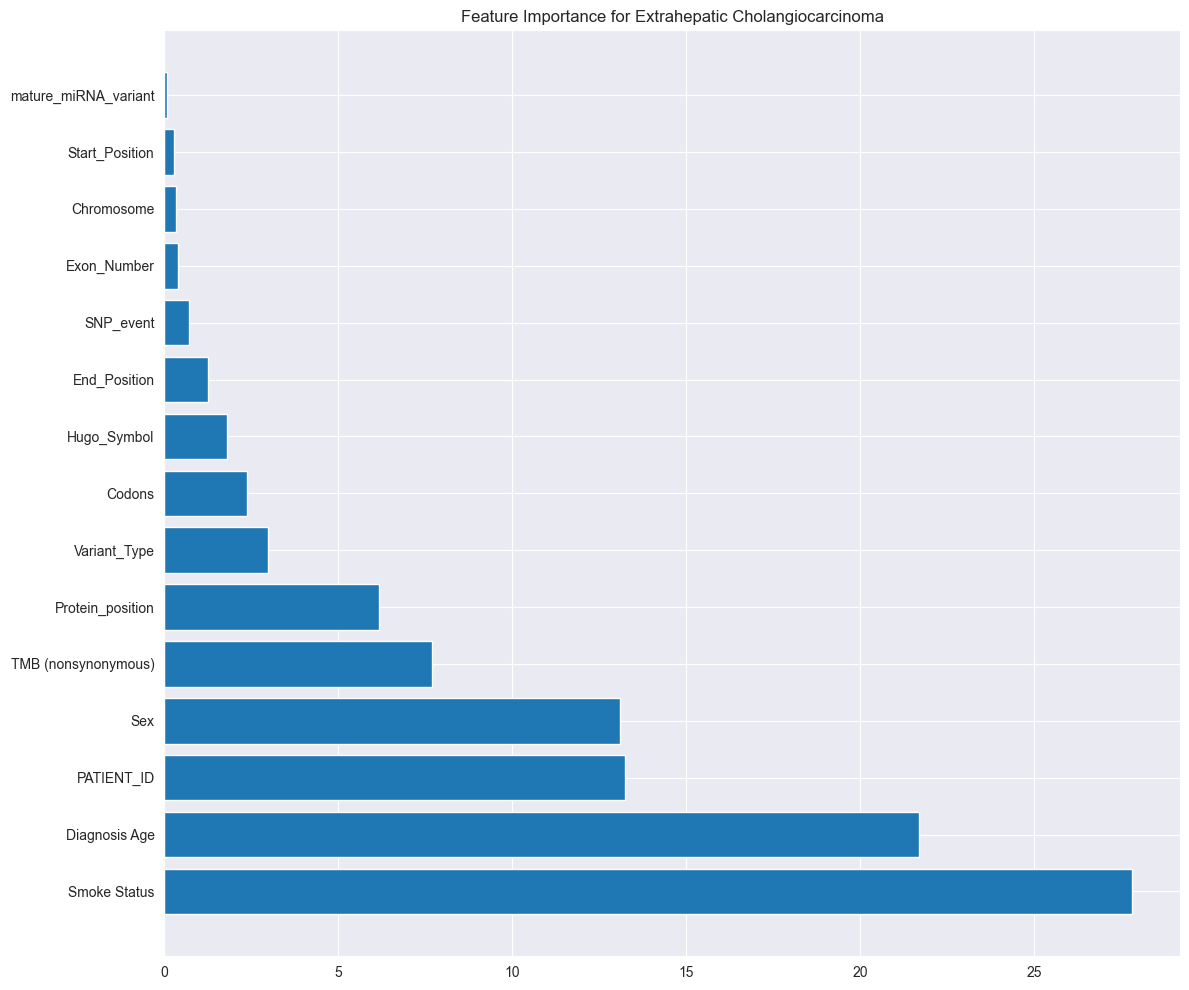


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other      Lift
Hugo_Symbol                              
U2AF1        0.005547  0.000657  8.442917
BCL2L2       0.000396  0.000064  6.151268
CRKL         0.000792  0.000142  5.592062


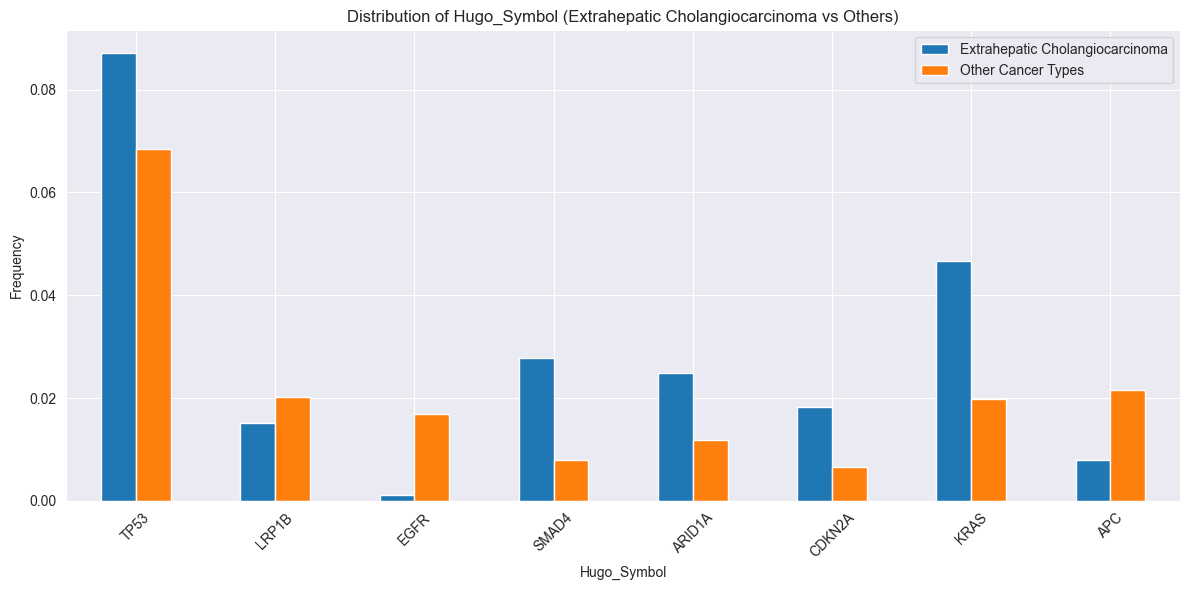


Feature: Sex
Top values by lift ratio:
          Cancer     Other      Lift
Sex                                 
Female  0.448891  0.319765  1.403816
Male    0.551109  0.680235  0.810174


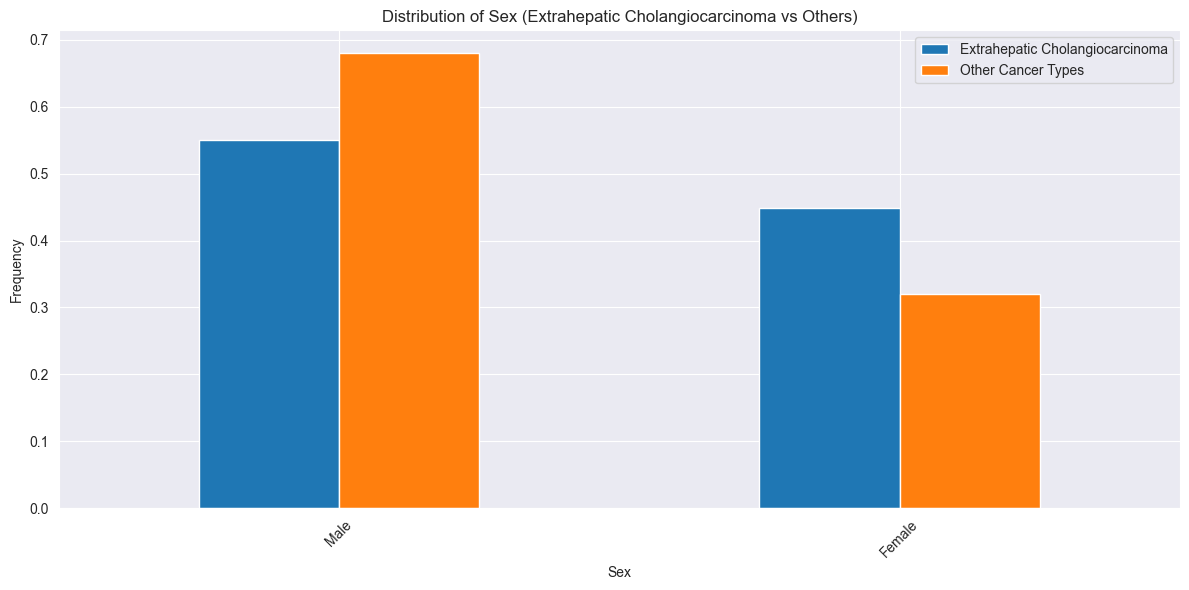


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
INS           0.051109  0.036327  1.406939
DEL           0.111727  0.102062  1.094697
SNP           0.837163  0.861096  0.972207


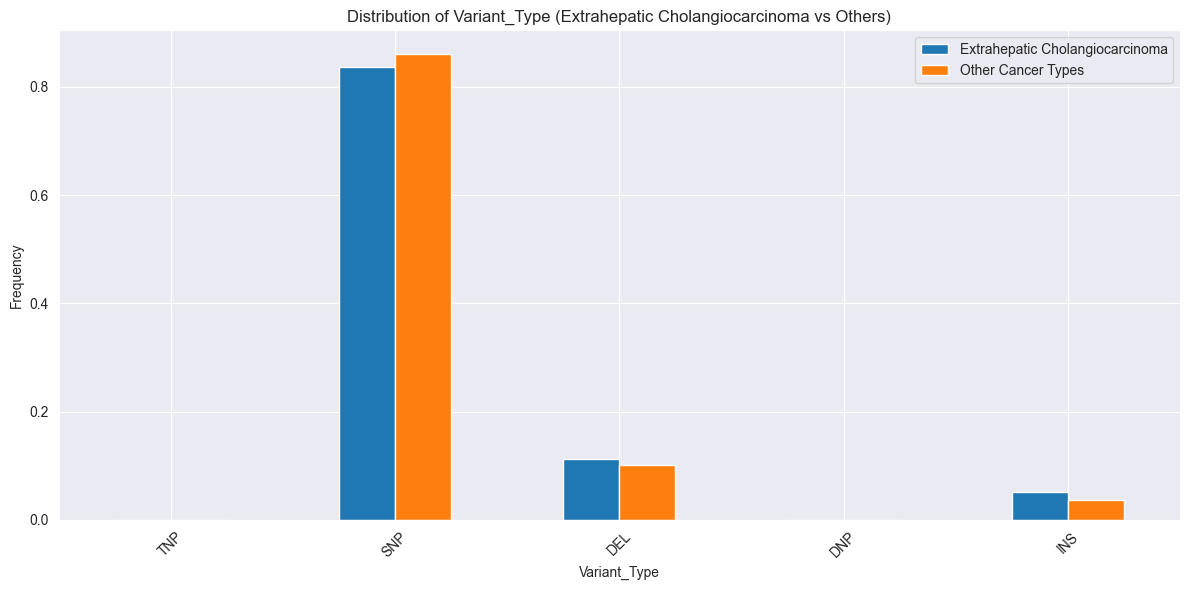


Feature: SNP_event
Top values by lift ratio:
             Cancer     Other       Lift
SNP_event                               
->CATT     0.000792  0.000013  61.512678
->TGA      0.000396  0.000013  30.756339
CC>A       0.000396  0.000013  30.756339


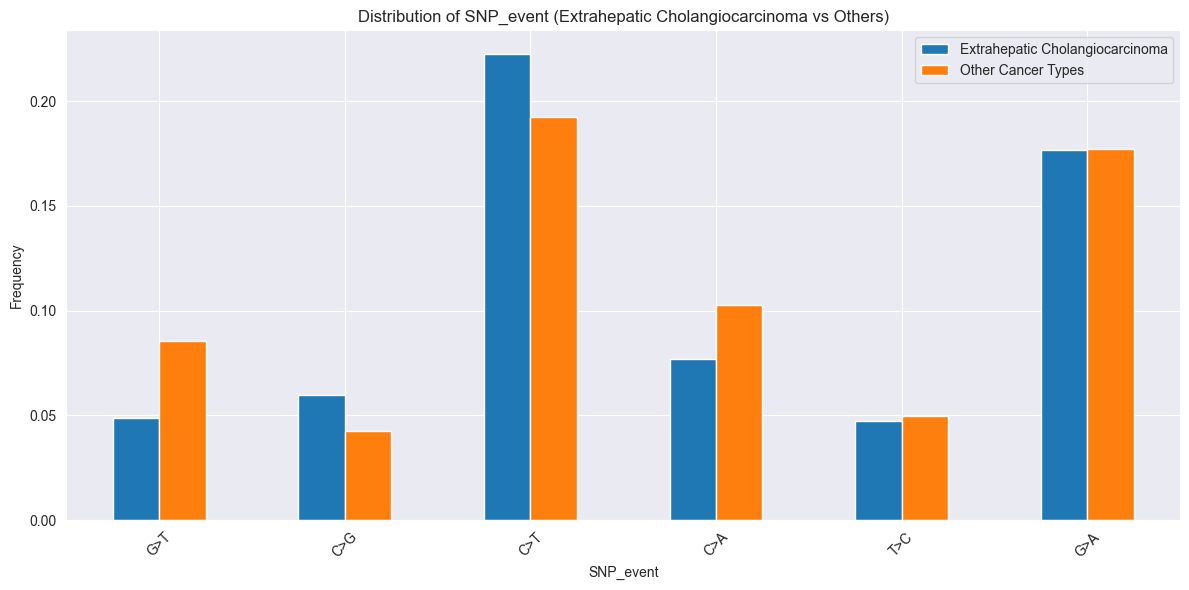


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.805485  1.241488
Nonsmoker        0.0  0.089412  0.000000
Smoker           0.0  0.105102  0.000000


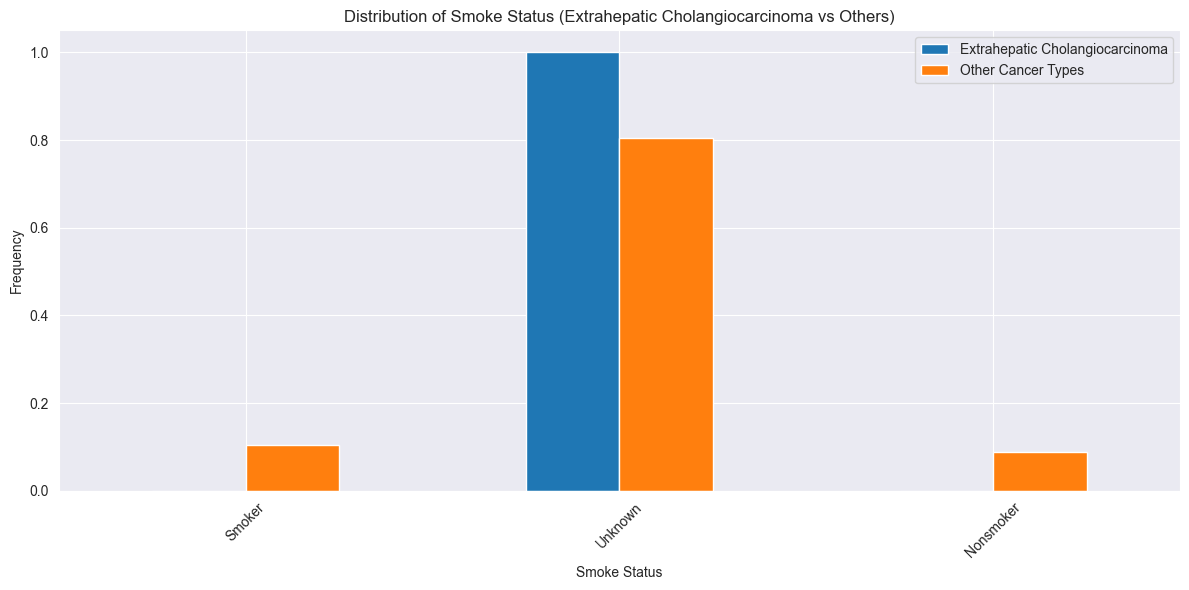

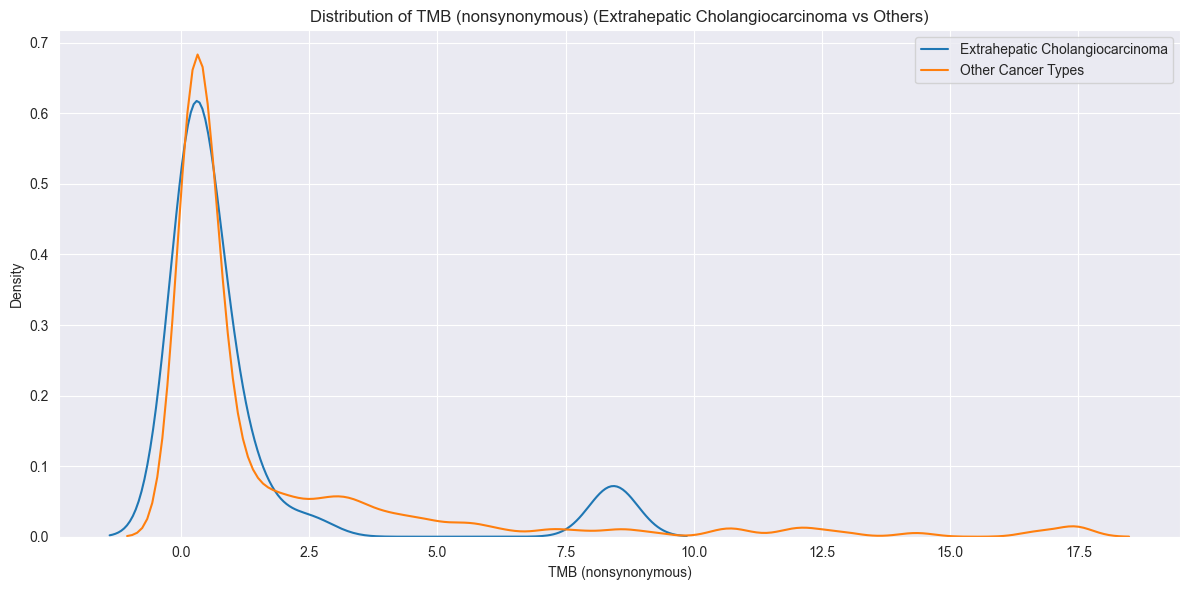


Feature: TMB (nonsynonymous)
Mean for Extrahepatic Cholangiocarcinoma: 1.1759
Mean for Other Cancer Types: 1.8530
Difference: -36.54%


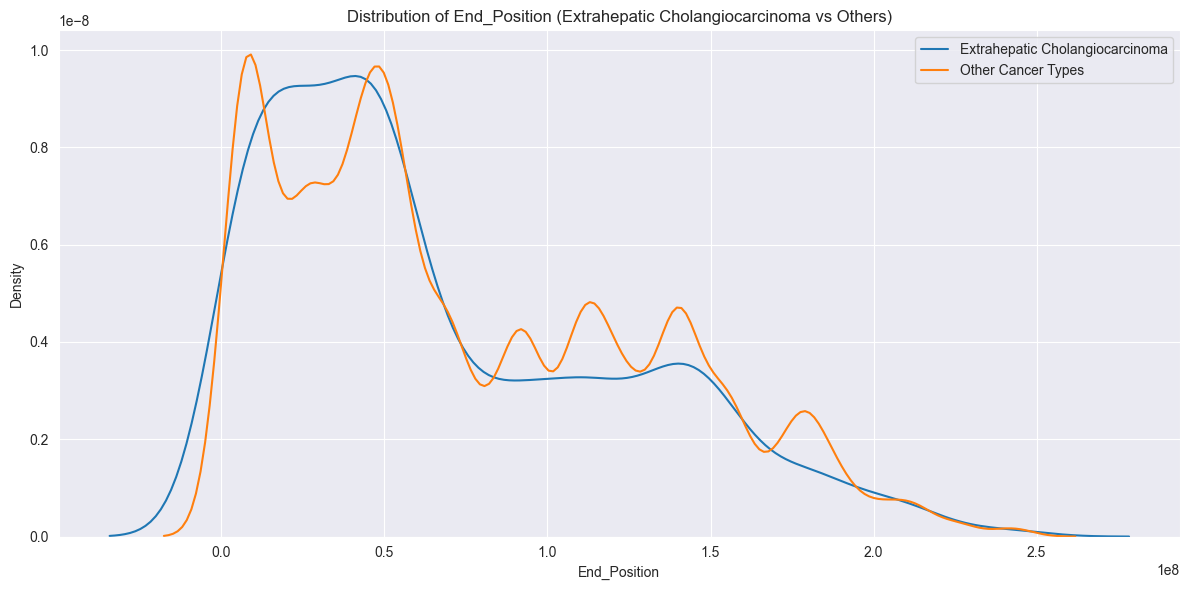


Feature: End_Position
Mean for Extrahepatic Cholangiocarcinoma: 68013052.0840
Mean for Other Cancer Types: 74994387.8157
Difference: -9.31%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                    Cancer    Other      Lift
VAR_TYPE_SX                                  
Truncation            0.25  0.21787  1.147475
Substitution/Indel    0.75  0.78213  0.958919


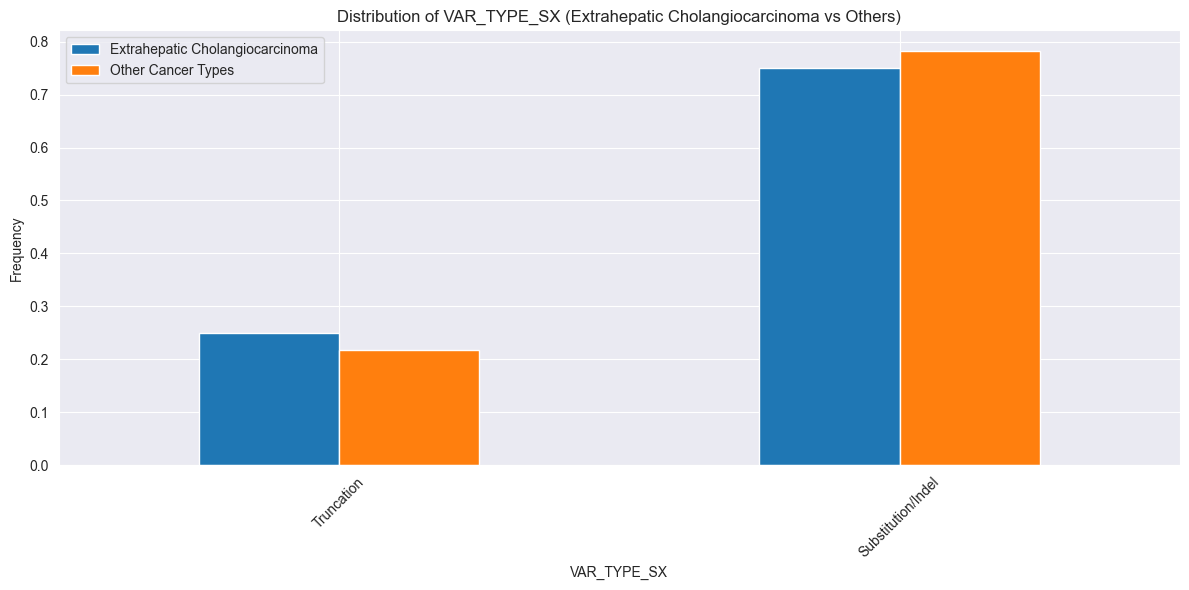

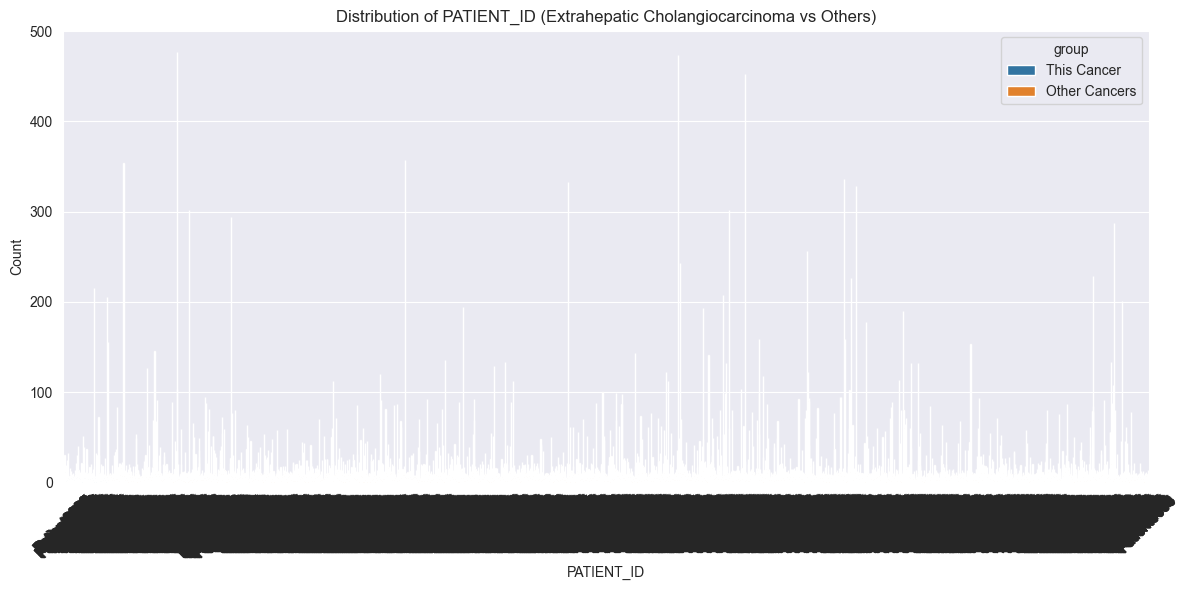

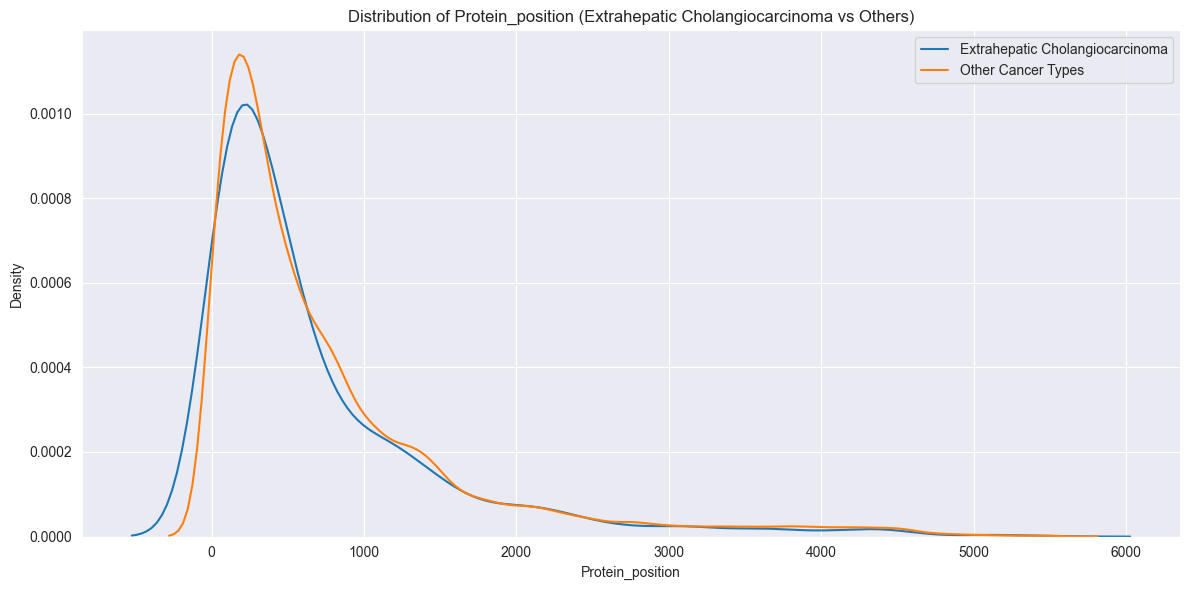


Feature: Protein_position
Mean for Extrahepatic Cholangiocarcinoma: 695.9497
Mean for Other Cancer Types: 769.0019
Difference: -9.50%

Analyzing categorical feature interactions...

Top feature combinations for Extrahepatic Cholangiocarcinoma:
      Feature1  Value1      Feature2   Value2  Cancer_Count  Cancer_Pct  \
3  Hugo_Symbol    JAK2  Variant_Type      DEL             5    0.198098   
6  Hugo_Symbol  NOTCH1     SNP_event      T>G             5    0.198098   
9  Hugo_Symbol   U2AF1  Smoke Status  Unknown            14    0.554675   
7  Hugo_Symbol   U2AF1     SNP_event      G>A             9    0.356577   
4  Hugo_Symbol   U2AF1  Variant_Type      SNP            14    0.554675   

   Other_Pct       Lift  
3   0.010305  19.222712  
6   0.011594  17.086855  
9   0.038645  14.352958  
7   0.028340  12.582139  
4   0.057968   9.568639  


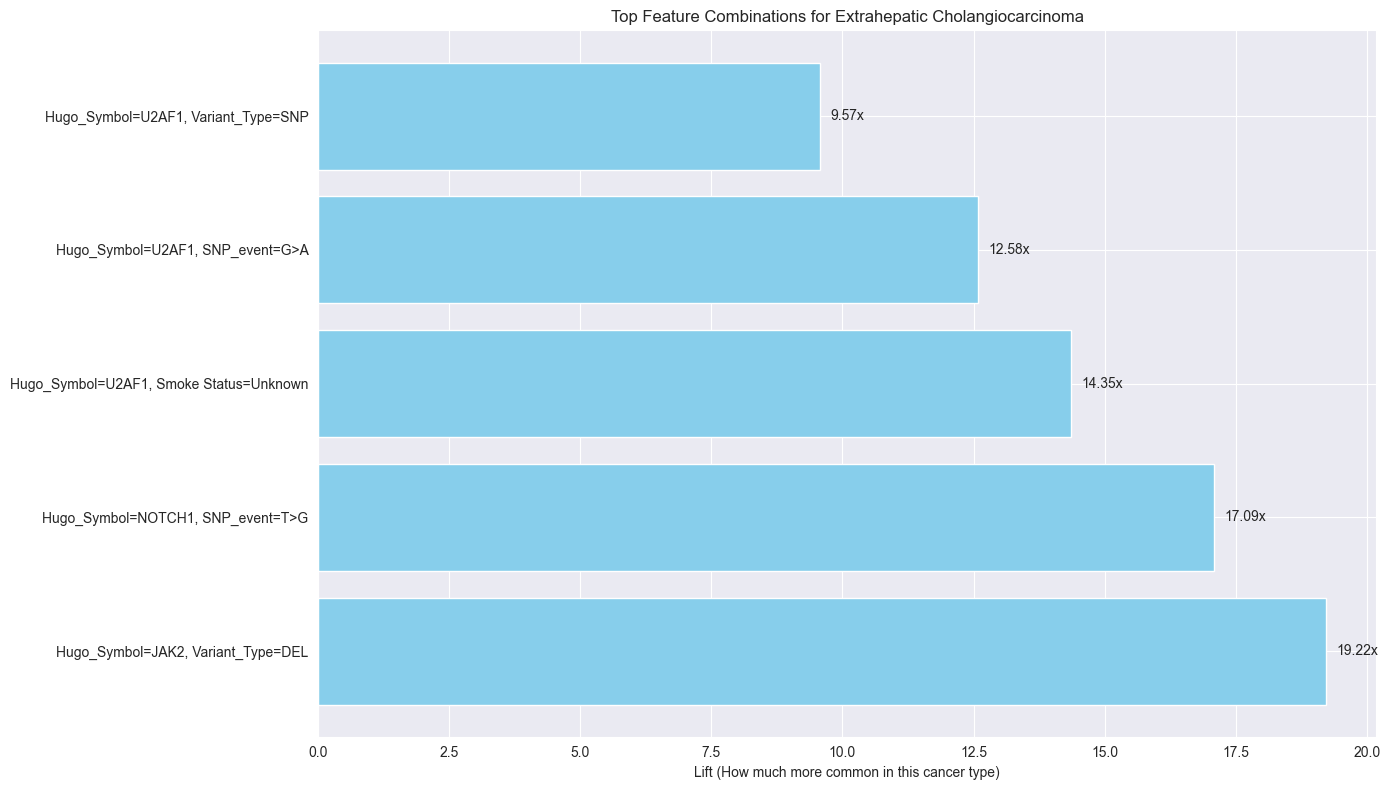


===== ANALYZING CANCER TYPE: Esophageal Carcinoma =====
Number of samples: 5453

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


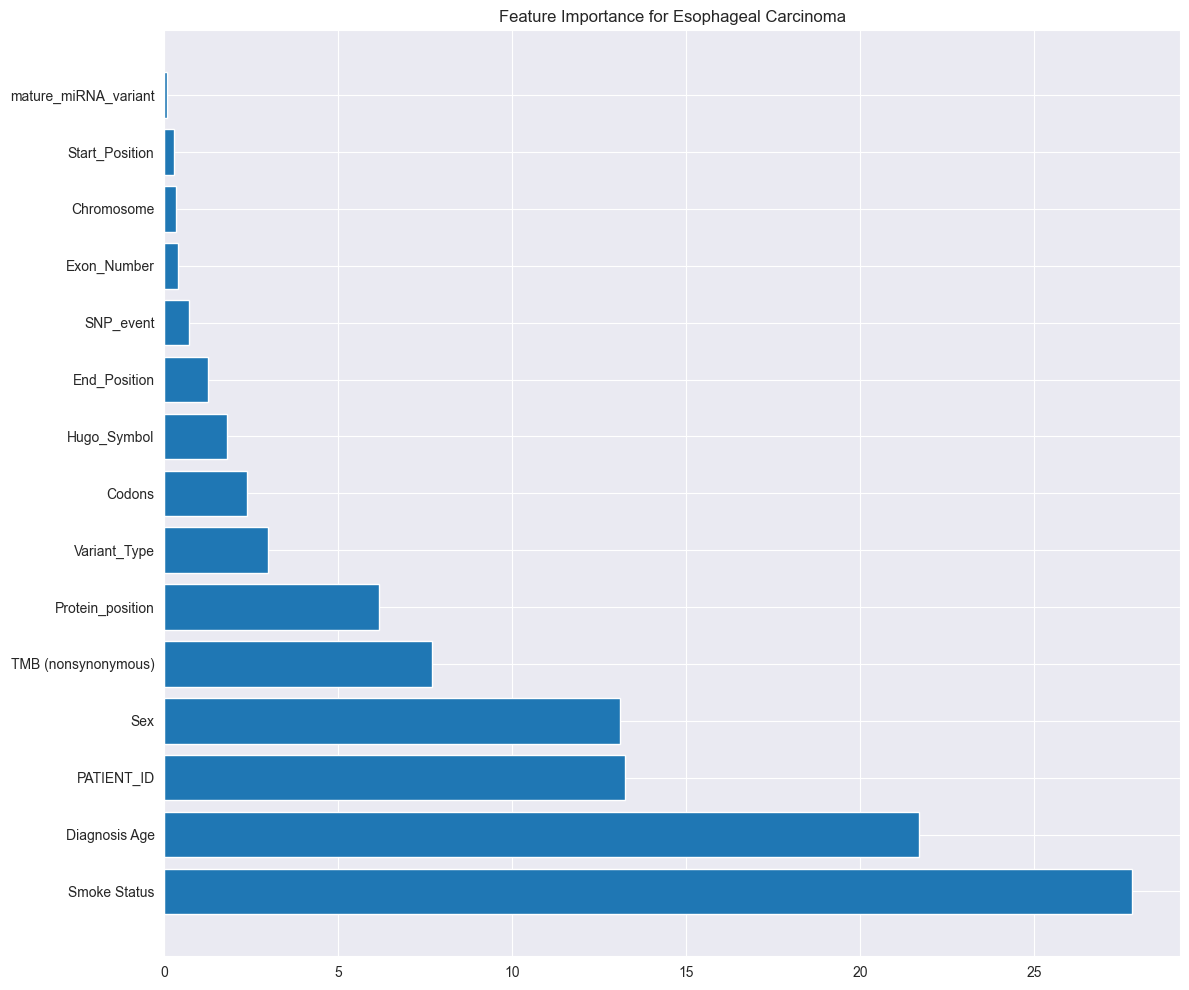


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other       Lift
Hugo_Symbol                               
ZNF750       0.014854  0.000884  16.812263
NOTCH1       0.034843  0.004672   7.457844
EPCAM        0.001467  0.000308   4.764828


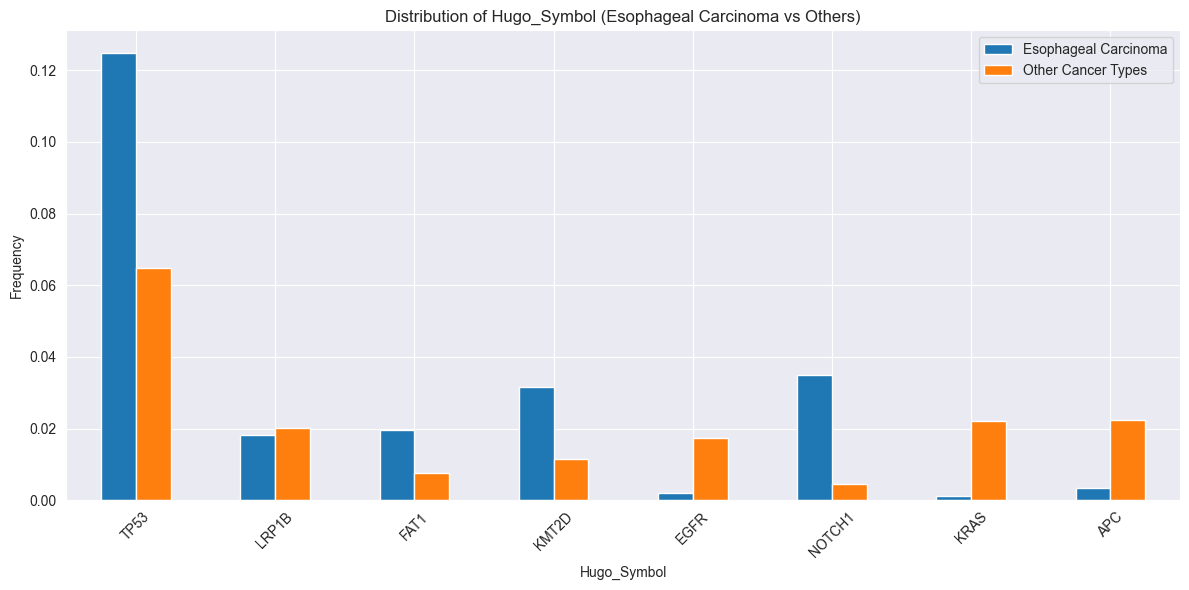


Feature: Sex
Top values by lift ratio:
          Cancer     Other      Lift
Sex                                 
Male    0.814964  0.666037  1.223601
Female  0.185036  0.333963  0.554061


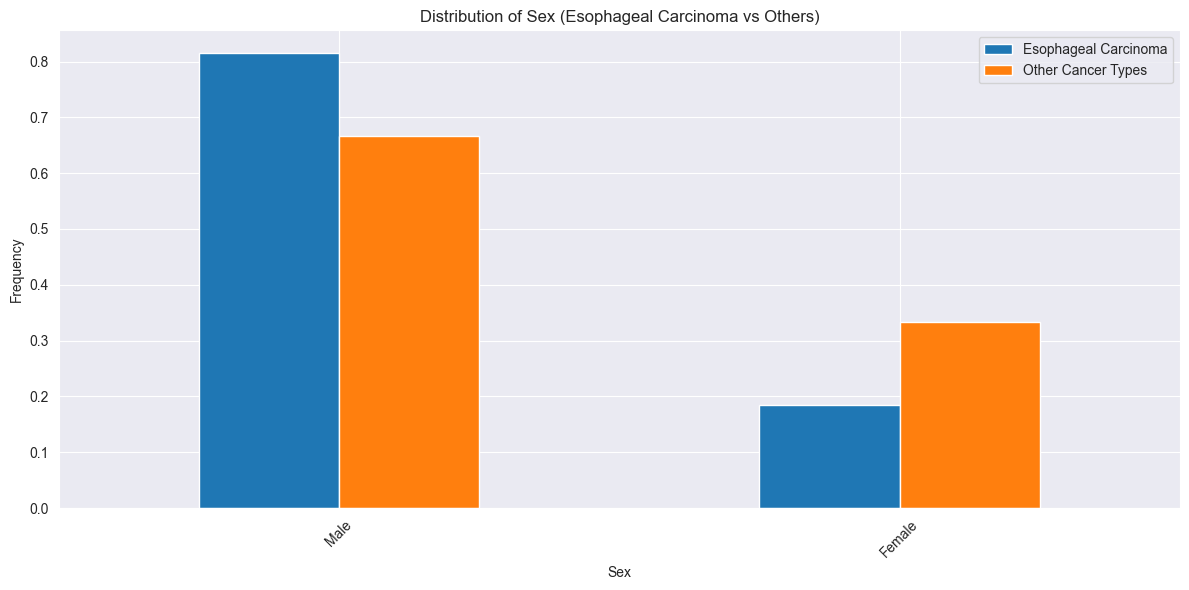


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
DNP           0.001284  0.000415  3.093296
SNP           0.882083  0.858755  1.027165
INS           0.036310  0.036827  0.985961


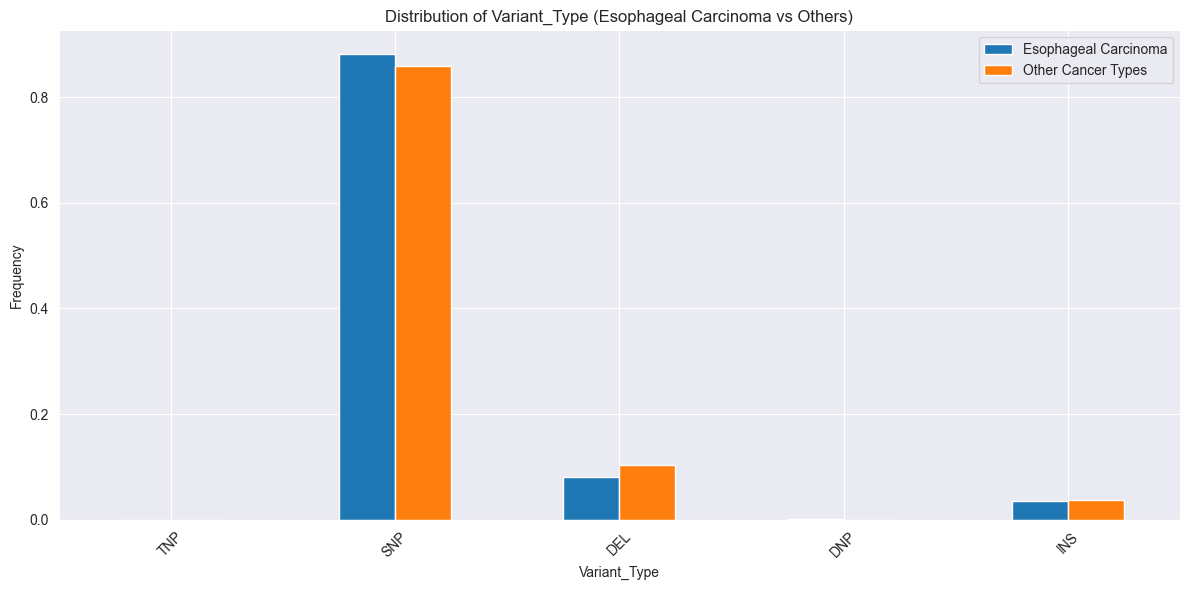


Feature: SNP_event
Top values by lift ratio:
             Cancer     Other       Lift
SNP_event                               
ACC>-      0.000734  0.000040  18.265175
GCC>-      0.000183  0.000013  13.698881
->ATG      0.000183  0.000013  13.698881


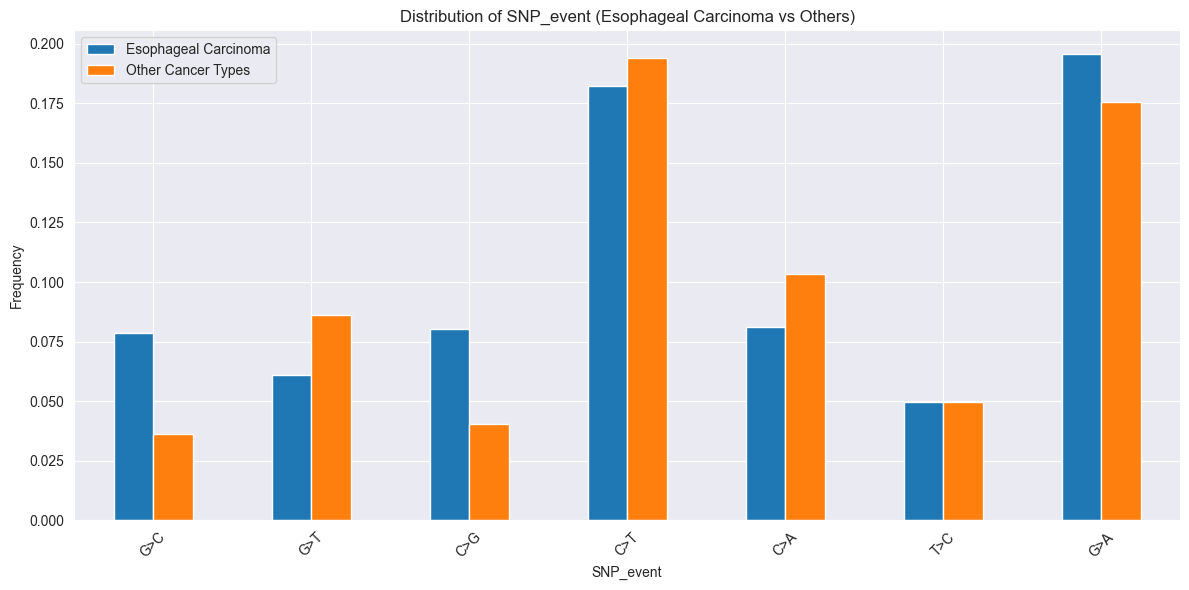


Feature: Smoke Status
Top values by lift ratio:
              Cancer     Other      Lift
Smoke Status                            
Unknown          1.0  0.797858  1.253356
Nonsmoker        0.0  0.092918  0.000000
Smoker           0.0  0.109224  0.000000


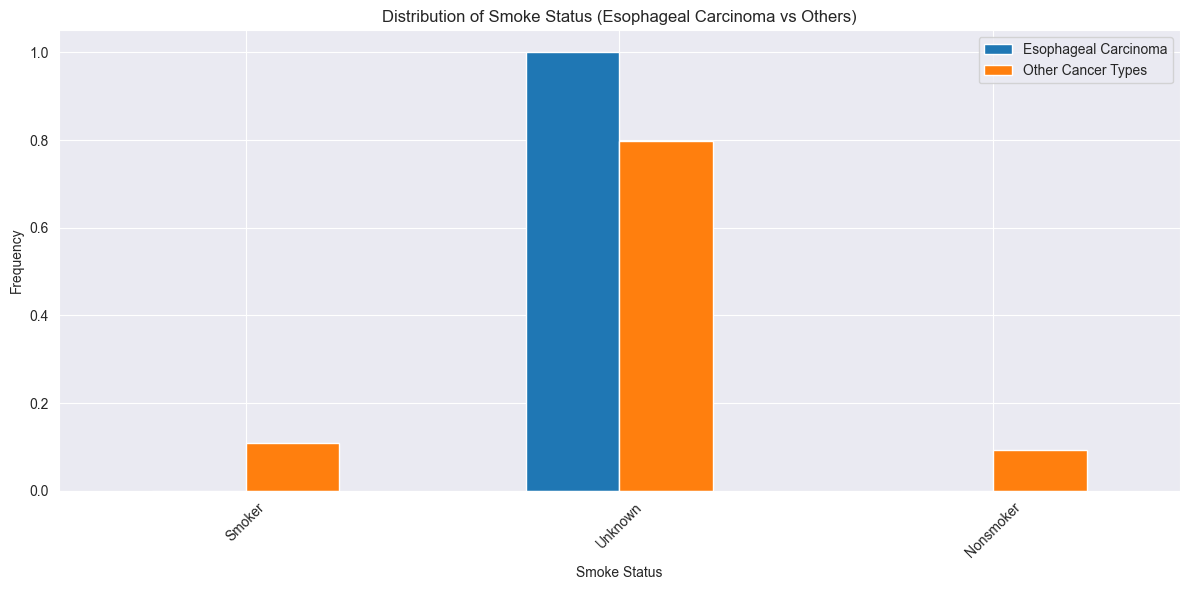

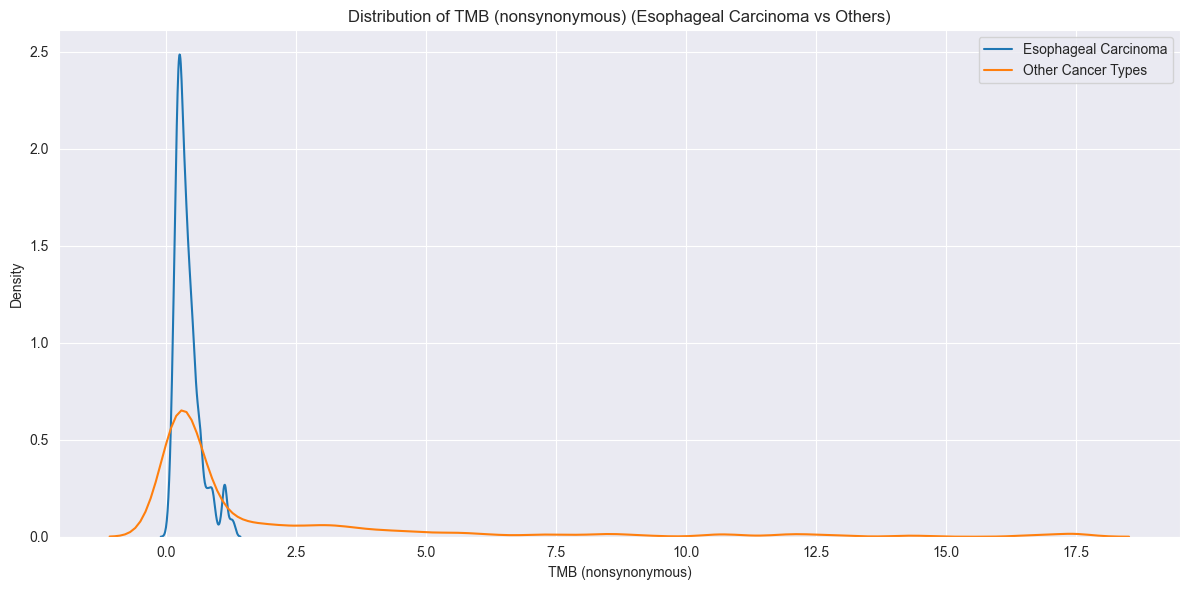


Feature: TMB (nonsynonymous)
Mean for Esophageal Carcinoma: 0.4135
Mean for Other Cancer Types: 1.9352
Difference: -78.63%


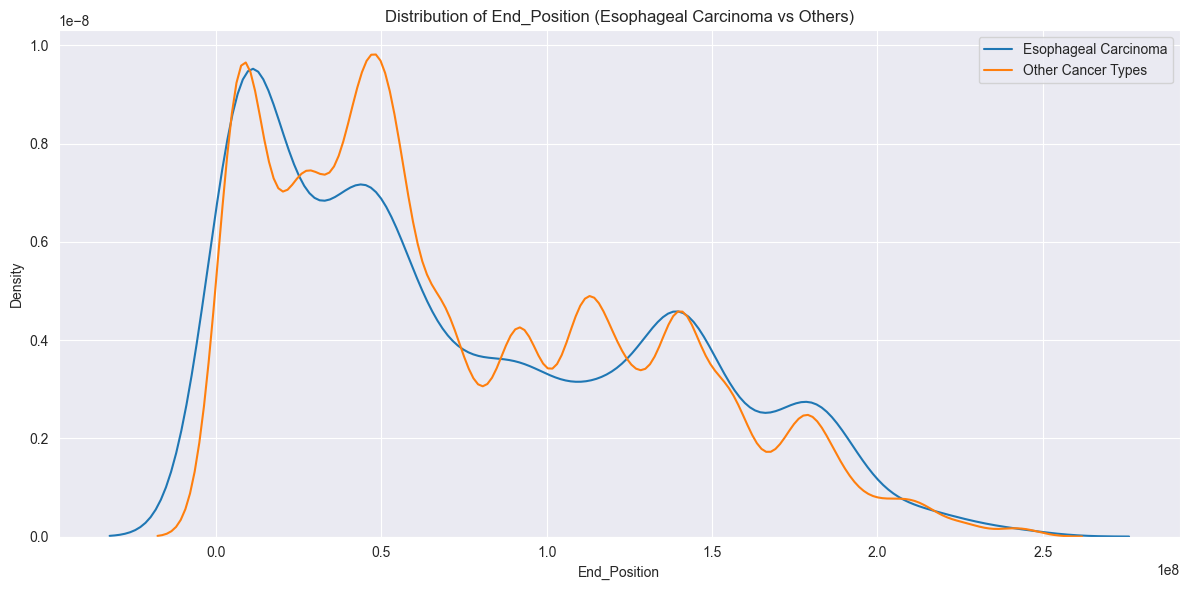


Feature: End_Position
Mean for Esophageal Carcinoma: 74969411.9254
Mean for Other Cancer Types: 74760322.2487
Difference: 0.28%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Substitution/Indel  0.787273  0.780669  1.008459
Truncation          0.212727  0.219331  0.969892


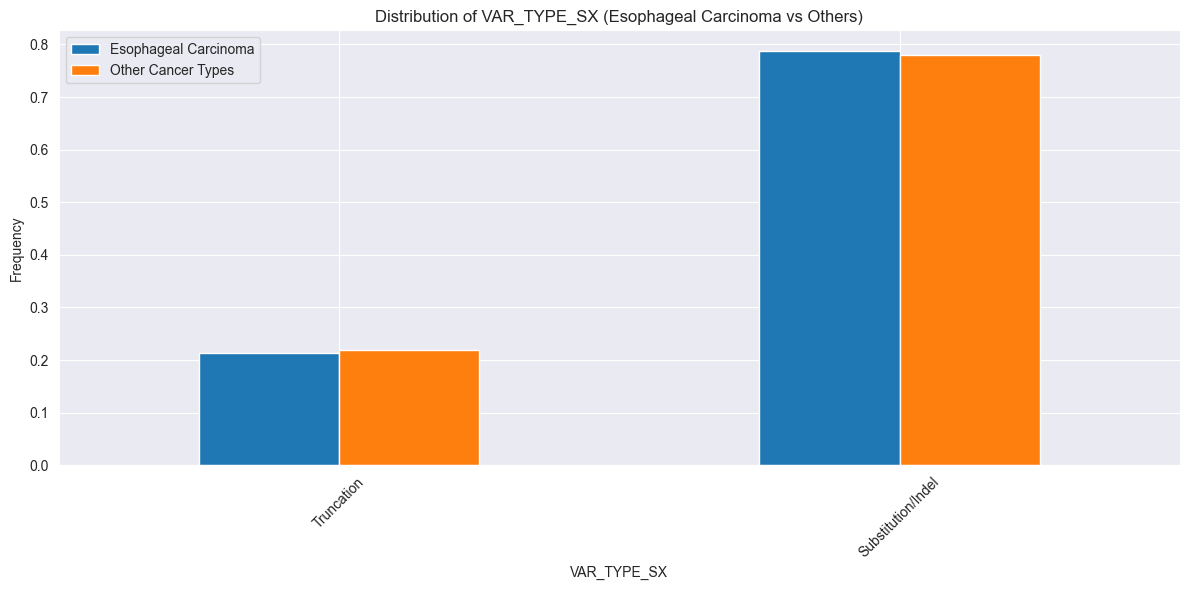

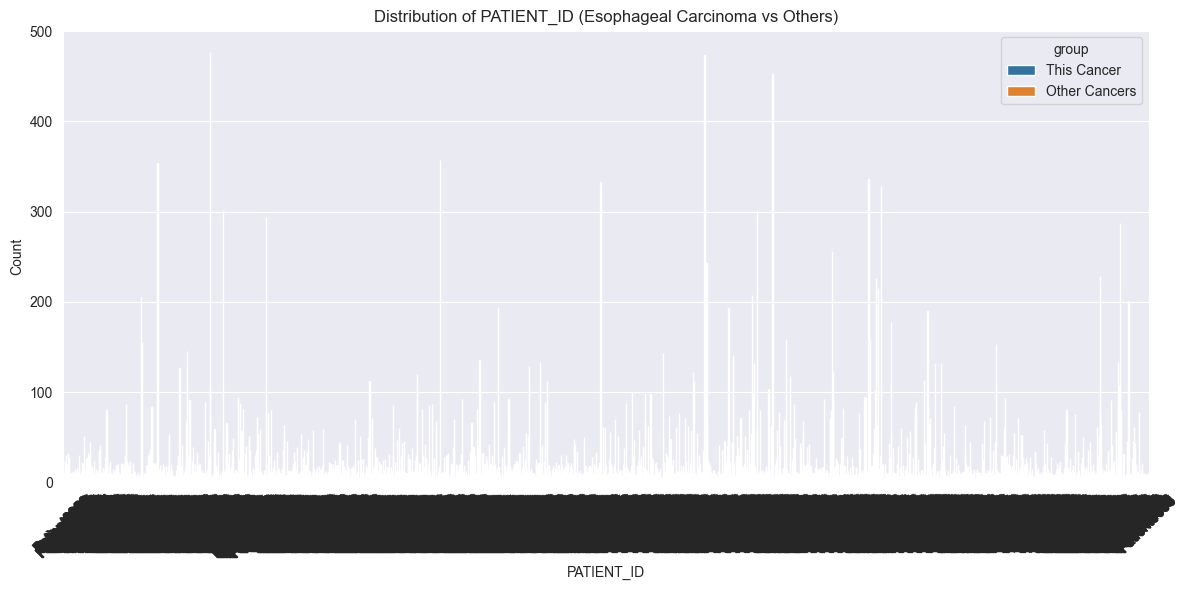

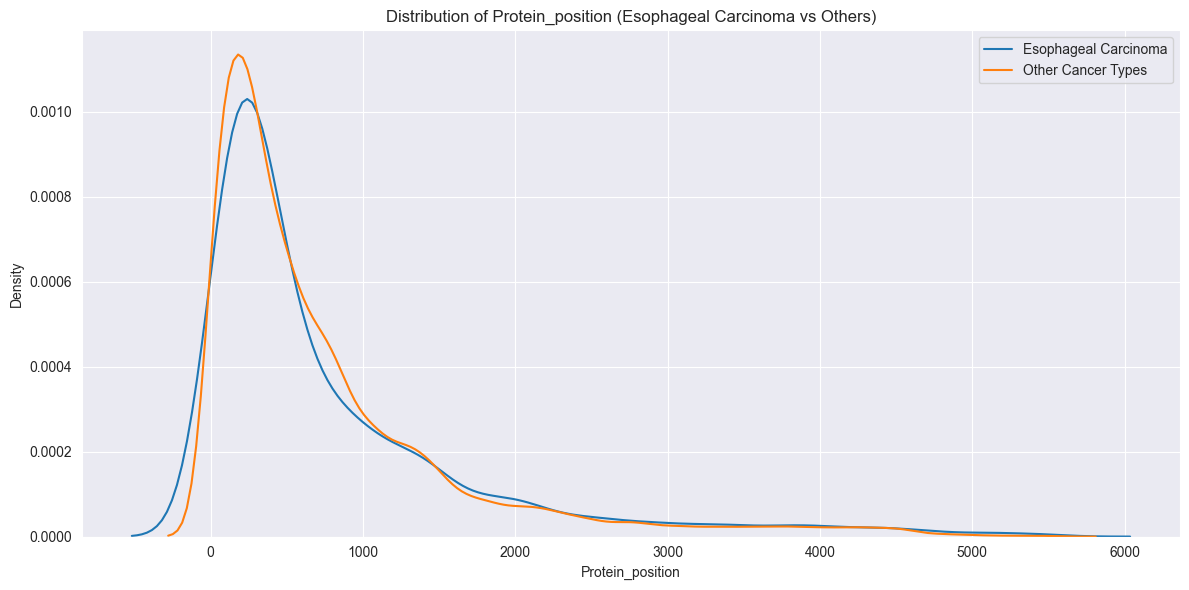


Feature: Protein_position
Mean for Esophageal Carcinoma: 801.6925
Mean for Other Cancer Types: 764.1472
Difference: 4.91%

Analyzing categorical feature interactions...

Top feature combinations for Esophageal Carcinoma:
      Feature1  Value1      Feature2 Value2  Cancer_Count  Cancer_Pct  \
6  Hugo_Symbol  ZNF750     SNP_event    G>C             6    0.110031   
7  Hugo_Symbol  ZNF750     SNP_event    A>-             6    0.110031   
3  Hugo_Symbol  ZNF750  Variant_Type    INS            14    0.256739   
8  Hugo_Symbol  ZNF750     SNP_event    ->T             5    0.091693   
4  Hugo_Symbol  ZNF750  Variant_Type    DEL            19    0.348432   

   Other_Pct        Lift  
6   0.001000  110.031175  
7   0.001000  110.031175  
3   0.002677   95.892169  
8   0.001000   91.692646  
4   0.005355   65.069686  


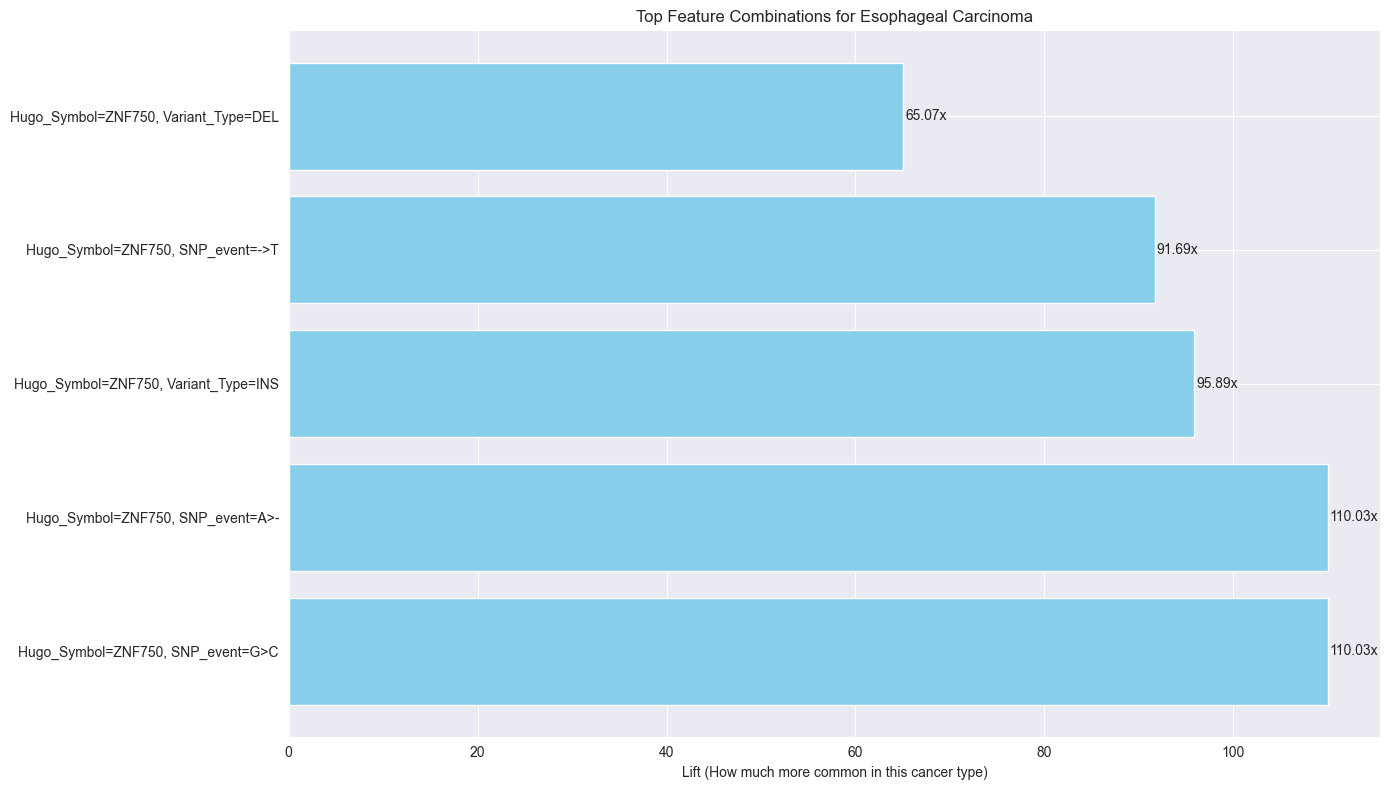


===== ANALYZING CANCER TYPE: Small Cell Lung Cancer =====
Number of samples: 2588

Calculating SHAP values for feature importance...
SHAP analysis error: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="Unknown": Cannot convert 'Unknown' to float
Falling back to CatBoost feature importance


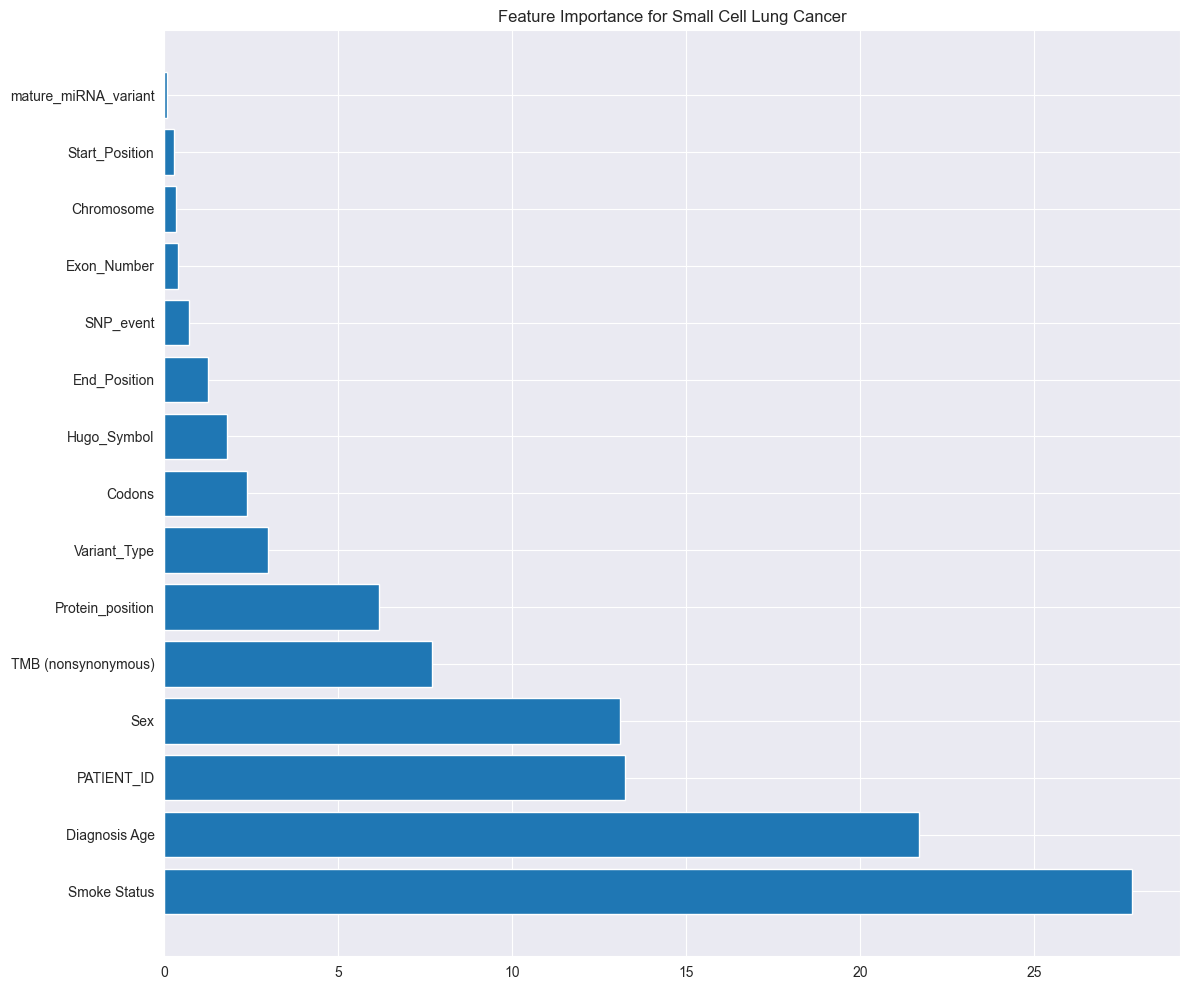


Analyzing feature distributions...

Feature: Hugo_Symbol
Top values by lift ratio:
               Cancer     Other      Lift
Hugo_Symbol                              
RB1          0.042890  0.004744  9.040172
PLA2G1B      0.000773  0.000180  4.281574
FGF19        0.001932  0.000477  4.050138


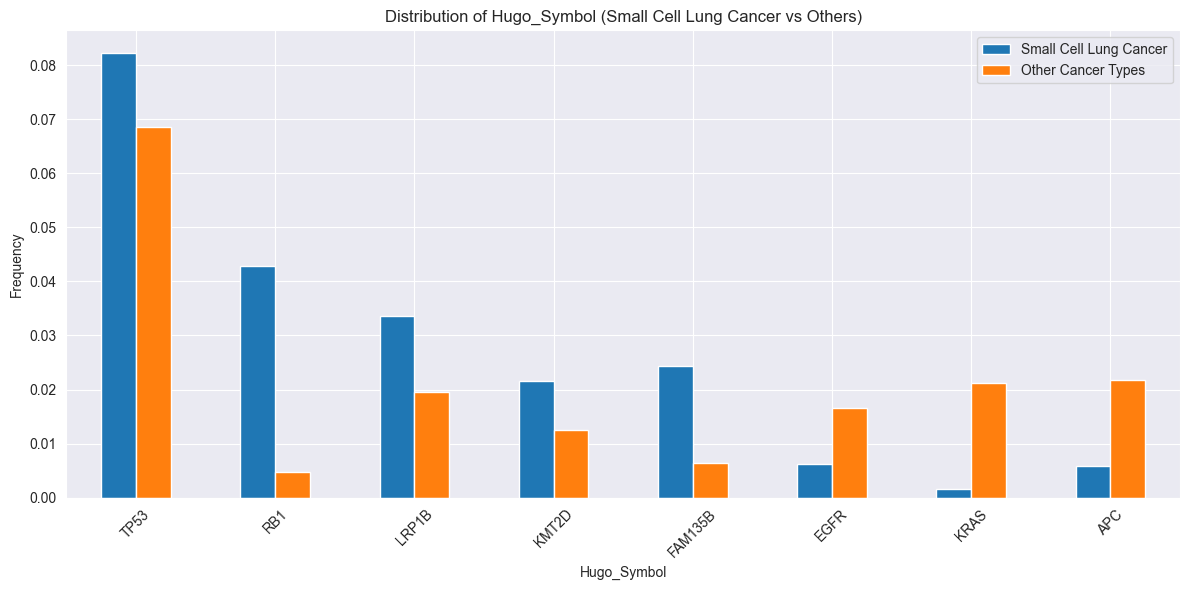


Feature: Sex
Top values by lift ratio:
          Cancer    Other      Lift
Sex                                
Male    0.765456  0.67319  1.137057
Female  0.234544  0.32681  0.717678


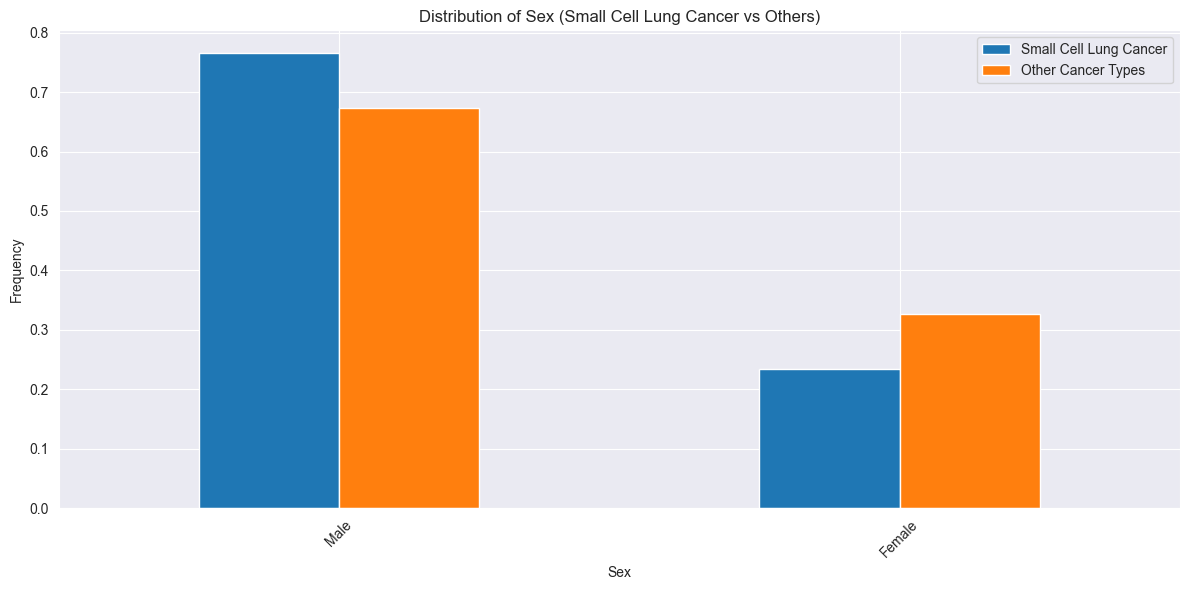


Feature: Variant_Type
Top values by lift ratio:
                Cancer     Other      Lift
Variant_Type                              
SNP           0.908810  0.858725  1.058325
DNP           0.000386  0.000477  0.810028
DEL           0.069938  0.103449  0.676066


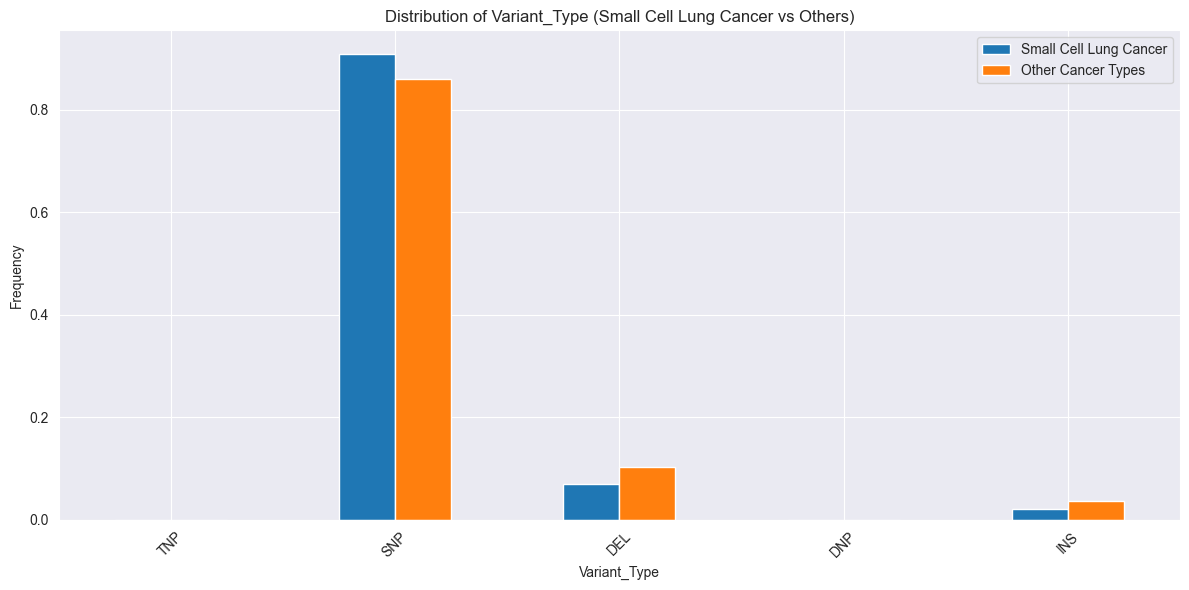


Feature: SNP_event
Top values by lift ratio:
                  Cancer     Other       Lift
SNP_event                                    
GGCGGCGGCGGC>-  0.000386  0.000013  29.971020
TCTT>-          0.000386  0.000039   9.990340
TCT>-           0.001546  0.000219   7.052005


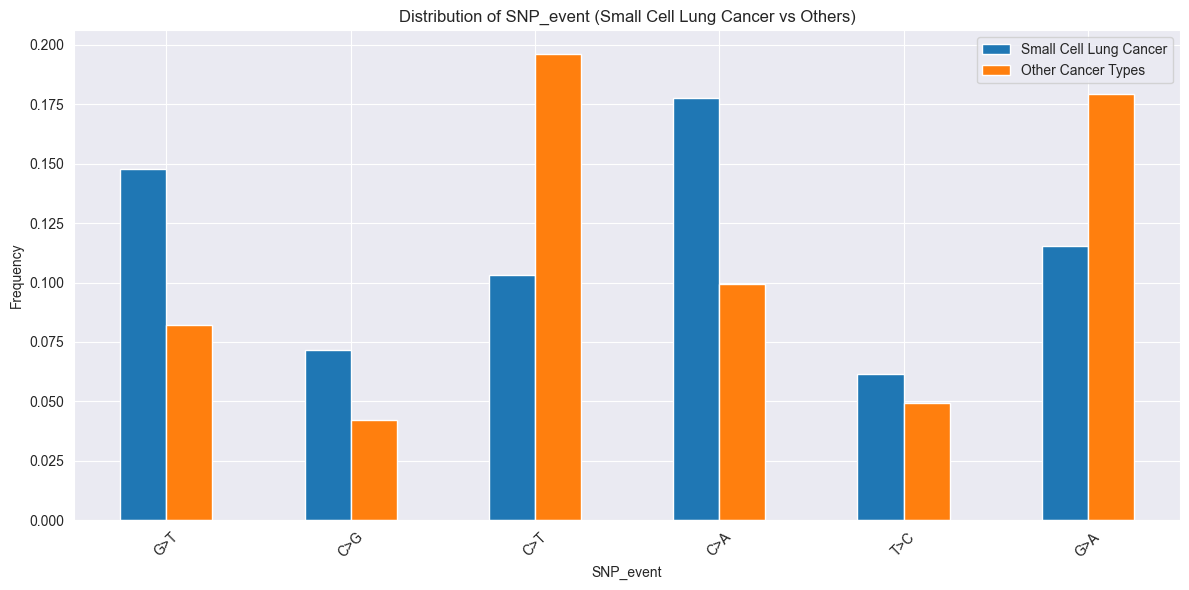


Feature: Smoke Status
Top values by lift ratio:
                Cancer     Other      Lift
Smoke Status                              
Smoker        0.426198  0.090969  4.685096
Nonsmoker     0.280912  0.080113  3.506426
Unknown       0.292890  0.828918  0.353341


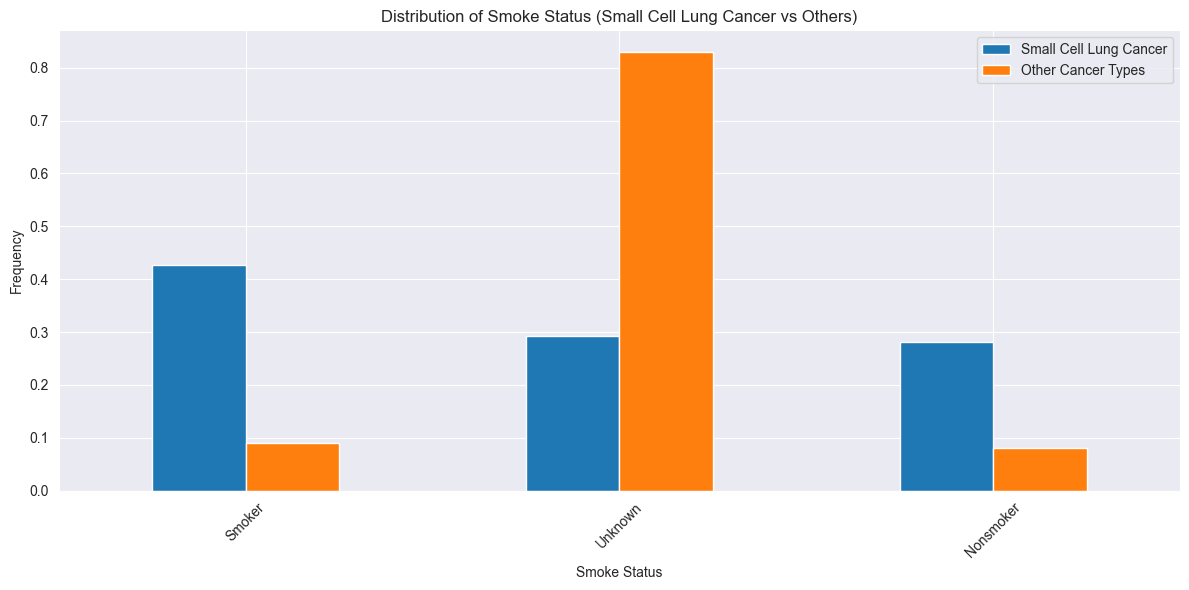

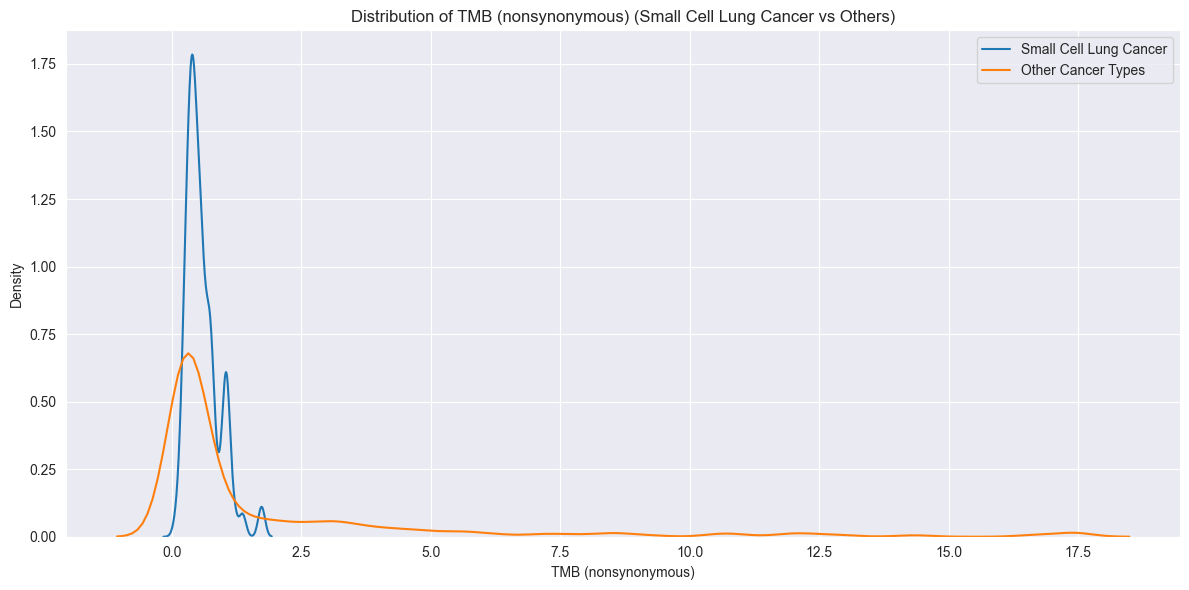


Feature: TMB (nonsynonymous)
Mean for Small Cell Lung Cancer: 0.5870
Mean for Other Cancer Types: 1.8732
Difference: -68.66%


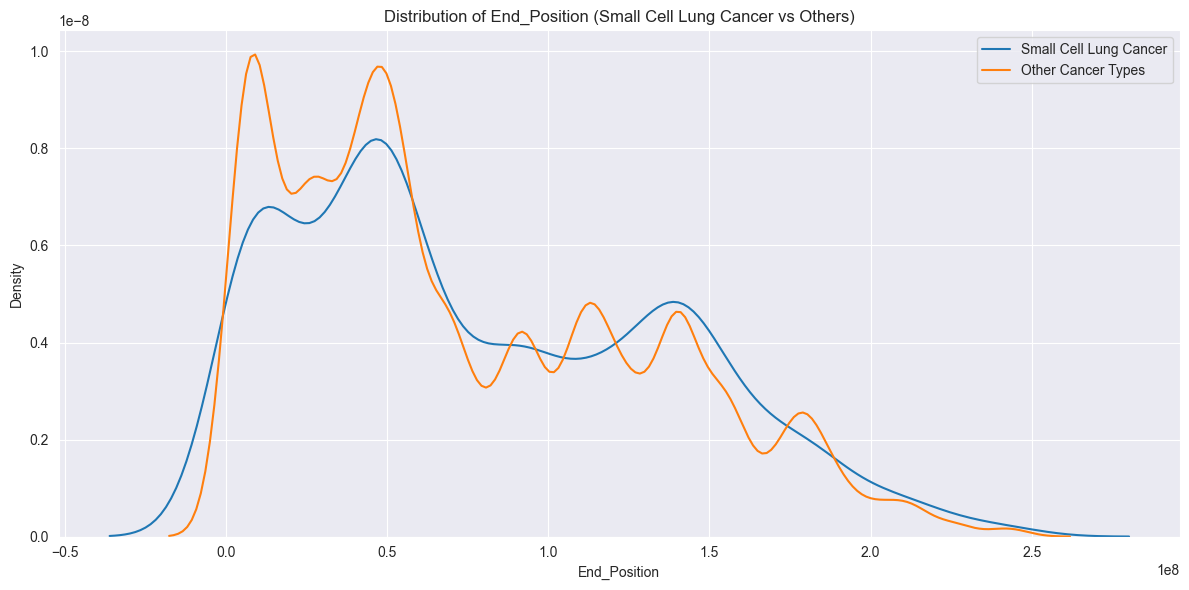


Feature: End_Position
Mean for Small Cell Lung Cancer: 79688729.5097
Mean for Other Cancer Types: 74610582.6498
Difference: 6.81%

Feature: VAR_TYPE_SX
Top values by lift ratio:
                      Cancer     Other      Lift
VAR_TYPE_SX                                     
Substitution/Indel  0.814529  0.780004  1.044262
Truncation          0.185471  0.219996  0.843067


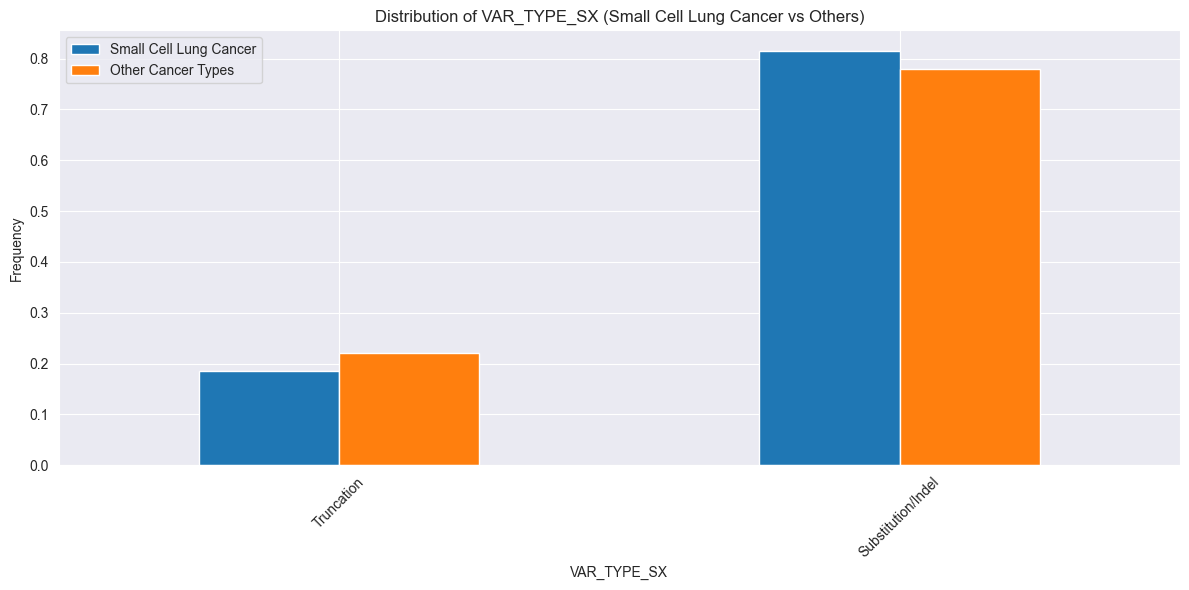

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x10d1c0540> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x12d8d8540> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [6]:
if __name__ == "__main__":
    main()

In [ ]:
X, y = load_data("narrowed_cancers_data.csv")
X_train, X_test, y_train, y_test, X_test_with_id = stratified_split_by_patient(X, y)
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_columns}")

In [ ]:

# Create CatBoost Pool with categorical features identified
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
test_pool = Pool(X_test, y_test, cat_features=categorical_columns)

# Initialize and train CatBoost model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=100
)

model.fit(train_pool)

In [ ]:

# Evaluate model performance
print("\nModel evaluation:")
predictions = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, predictions))